
# Evaluation Tests — Notebook Template

This notebook gives **individual, runnable cells** for each analysis you asked for:
- Data loading & normalization
- Paired **t-test**, **Wilcoxon signed-rank**, **Sign test**, **Permutation test**
- **MAE** (overall & per-category)
- **Bland–Altman** plot
- **Win-rate** matrix & heatmap (ε-margin)
- **Bradley–Terry** ranking (simple MM implementation)
- **Agreement** (Cohen’s κ & Gwet’s AC1) between Human and an LLM judge
- **Mixed-effects** (or fixed-effects fallback) for **Model × Domain** transfer
- **Interaction** plot and **Waterfall** plot

> ⚙️ **How to use**: Set your file paths in the **Setup** cell, then run the cells you need. Each section is independent.


In [39]:
import scipy.stats as stats
import seaborn as sns

In [80]:
import json, math, os
from pathlib import Path
from typing import Optional, Dict, Tuple
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def load_jsonl(p):
    import json, pandas as pd
    rows=[]
    for ln, line in enumerate(open(p, encoding="utf-8"), 1):
        s=line.strip().rstrip(',')
        if s: rows.append(json.loads(s))
    return pd.DataFrame(rows)

human_files = [
    'final_scores_HUMAN/final_score_human_BASE.jsonl',
    'final_scores_HUMAN/final_score_human_CI.jsonl',
    'final_scores_HUMAN/final_score_human_HT.jsonl',
]
human = (pd.concat([load_jsonl(p).assign(source_file=p) for p in human_files], ignore_index=True)
           .assign(judge="human"))

qwen_files = [
    'final_scores_QWEN/final_score_qwenBase.jsonl',
    'final_scores_QWEN/final_score_qwenCI.jsonl',
    'final_scores_QWEN/final_score_qwenHT.jsonl',
]
qwen = (pd.concat([load_jsonl(p).assign(source_file=p) for p in qwen_files], ignore_index=True)
          .assign(judge="qwen7b"))

qwen_clean = qwen[qwen['question_id'] != 'os_5.29g'].copy()

df = pd.concat([human, qwen], ignore_index=True)

qwen = qwen_clean
df = df 

I had an issue where I forgot to remove the question os_5.29g from the QWEN marking results. 

The reason for removing this question is because there was an error identified with the questions gold_answer and thus it was unsuitable to keep as it would mess up the results.

If you are attempting to reproduce this studies results, it is important to run this cell as the checks in the next cell to make sure the data is clean

In [81]:
human_questions = set(human['question_id'].unique())
qwen_questions = set(qwen['question_id'].unique())
common_questions = human_questions.intersection(qwen_questions)
print(f"\nData summary:")
print(f"Human judge questions: {len(human_questions)}")
print(f"QWEN judge questions: {len(qwen_questions)}")
print(f"Common questions: {len(common_questions)}")


Data summary:
Human judge questions: 45
QWEN judge questions: 45
Common questions: 45


In [83]:
df = pd.concat([human, qwen], ignore_index=True)
print("Combined df shape:", df.shape)
print("Combined df columns:", df.columns.tolist())
print("Judges in df:", df['judge'].unique())
print("Models in df:", df['model'].unique())

Combined df shape: (270, 14)
Combined df columns: ['question_id', 'model', 'category', 'subscores', 'score_raw', 'deductions_applied', 'score_final', 'rationale', 'error', 'total_deduction', 'source_file', 'notes', 'fscore_final', 'judge']
Judges in df: ['human' 'qwen7b']
Models in df: ['base' 'ci_rag' 'ht_rag']


In [84]:
def add_domain_from_model(df):
    df = df.copy()
    
    def get_domain(model_name):
        model_name = str(model_name).lower()
        if 'ci_rag' in model_name:
            return 'confidence_intervals'
        elif 'ht_rag' in model_name:
            return 'hypothesis_testing'
        elif 'base' in model_name:
            return 'base_statistics'
        else:
            return 'no_domain'
    
    df['domain'] = df['model'].apply(get_domain)
    return df

human = add_domain_from_model(human)
qwen = add_domain_from_model(qwen)

print("Domains added!")
print("Human domains:", human['domain'].unique())
print("Qwen domains:", qwen['domain'].unique())
print("\nModel to domain mapping:")
for model in human['model'].unique():
    domain = human[human['model']==model]['domain'].iloc[0]
    print(f"  {model} -> {domain}")

Domains added!
Human domains: ['base_statistics' 'confidence_intervals' 'hypothesis_testing']
Qwen domains: ['base_statistics' 'confidence_intervals' 'hypothesis_testing']

Model to domain mapping:
  base -> base_statistics
  ci_rag -> confidence_intervals
  ht_rag -> hypothesis_testing


In [85]:
paired = (human.merge(qwen, on=["question_id","model"], suffixes=("_human","_qwen")))

In [86]:
df = pd.concat([human, qwen], ignore_index=True)
print("Combined df shape:", df.shape)
print("Combined df columns:", df.columns.tolist())
print("Judges in df:", df['judge'].unique())
print("Models in df:", df['model'].unique())

Combined df shape: (270, 15)
Combined df columns: ['question_id', 'model', 'category', 'subscores', 'score_raw', 'deductions_applied', 'score_final', 'rationale', 'error', 'total_deduction', 'source_file', 'notes', 'fscore_final', 'judge', 'domain']
Judges in df: ['human' 'qwen7b']
Models in df: ['base' 'ci_rag' 'ht_rag']


## Select two models to compare (Human judge data)

In [87]:

MODEL_A = 'ht_rag'  
MODEL_B = 'ci_rag' 

human = df[df['judge']=='human']
a = human[human['model']==MODEL_A].set_index('question_id')['score_final']
b = human[human['model']==MODEL_B].set_index('question_id')['score_final']
idx = a.index.intersection(b.index)
a_vec = a.loc[idx].to_numpy()
b_vec = b.loc[idx].to_numpy()
print(f"Overlap n = {len(idx)}")


Overlap n = 45


In [88]:
print("Available models in human data:", human['model'].unique())
print("Available models in qwen data:", qwen['model'].unique())

Available models in human data: ['base' 'ci_rag' 'ht_rag']
Available models in qwen data: ['base' 'ci_rag' 'ht_rag']


In [89]:
comparisons = [
    ('base', 'ci_rag'), 
    ('base', 'ht_rag'),      
    ('ci_rag', 'ht_rag')     
]

for MODEL_A, MODEL_B in comparisons:
    print(f"\n=== Comparing {MODEL_A} vs {MODEL_B} ===")


=== Comparing base vs ci_rag ===

=== Comparing base vs ht_rag ===

=== Comparing ci_rag vs ht_rag ===


## Paired t-test

In [90]:
for MODEL_A, MODEL_B in comparisons:
    print(f"\n=== Comparing {MODEL_A} vs {MODEL_B} ===")

    human_data = df[df['judge']=='human']
    a = human_data[human_data['model']==MODEL_A].set_index('question_id')['score_final']
    b = human_data[human_data['model']==MODEL_B].set_index('question_id')['score_final']
    idx = a.index.intersection(b.index)
    a_vec = a.loc[idx].to_numpy()
    b_vec = b.loc[idx].to_numpy()
    
    print(f"Overlap n = {len(idx)}")

    if len(a_vec)>1:
        t_res = stats.ttest_rel(a_vec, b_vec, nan_policy='omit')
        mean_diff = float((a_vec - b_vec).mean())
        sd_diff = float((a_vec - b_vec).std(ddof=1))
        d = mean_diff / sd_diff if sd_diff not in (0, np.nan) else np.nan
        print("t-stat:", float(t_res.statistic), "p-value:", float(t_res.pvalue))
        print("mean diff:", mean_diff, "sd diff:", sd_diff, "Cohen's d (paired):", d)
    else:
        print("Not enough overlap for t-test.")



=== Comparing base vs ci_rag ===
Overlap n = 45
t-stat: 0.9570202978345286 p-value: 0.3437860957996356
mean diff: 0.3111111111111111 sd diff: 2.180723631172817 Cohen's d (paired): 0.1426641627870067

=== Comparing base vs ht_rag ===
Overlap n = 45
t-stat: 0.399193368094723 p-value: 0.6916817423120798
mean diff: 0.18000000000000008 sd diff: 3.024791502957458 Cohen's d (paired): 0.059508233815126425

=== Comparing ci_rag vs ht_rag ===
Overlap n = 45
t-stat: -0.28444479800471023 p-value: 0.7774039703593061
mean diff: -0.13111111111111115 sd diff: 3.0920589067526323 Cohen's d (paired): -0.04240252694564857


## Wilcoxon signed-rank test

In [91]:
for MODEL_A, MODEL_B in comparisons:
    print(f"\n=== Comparing {MODEL_A} vs {MODEL_B} ===")

    human_data = df[df['judge']=='human']
    a = human_data[human_data['model']==MODEL_A].set_index('question_id')['score_final']
    b = human_data[human_data['model']==MODEL_B].set_index('question_id')['score_final']
    idx = a.index.intersection(b.index)
    a_vec = a.loc[idx].to_numpy()
    b_vec = b.loc[idx].to_numpy()

    if len(a_vec)>0:
        try:
            w = stats.wilcoxon(a_vec - b_vec, zero_method='wilcox', alternative='two-sided')
            print("Wilcoxon statistic:", float(w.statistic), "p-value:", float(w.pvalue))
        except Exception as e:
            print("Wilcoxon error:", e)
    else:
        print("Not enough data for Wilcoxon.")



=== Comparing base vs ci_rag ===
Wilcoxon statistic: 196.5 p-value: 0.3127984485381049

=== Comparing base vs ht_rag ===
Wilcoxon statistic: 201.5 p-value: 0.9727447832177433

=== Comparing ci_rag vs ht_rag ===
Wilcoxon statistic: 144.0 p-value: 0.6186088586261281


## Sign test (binomial on direction)

In [92]:
for MODEL_A, MODEL_B in comparisons:
    print(f"\n=== Comparing {MODEL_A} vs {MODEL_B} ===")

    human_data = df[df['judge']=='human']
    a = human_data[human_data['model']==MODEL_A].set_index('question_id')['score_final']
    b = human_data[human_data['model']==MODEL_B].set_index('question_id')['score_final']
    idx = a.index.intersection(b.index)
    a_vec = a.loc[idx].to_numpy()
    b_vec = b.loc[idx].to_numpy()


    d  = a_vec - b_vec
    n_pos = int((d>0).sum())
    n_neg = int((d<0).sum())
    n_eff = n_pos + n_neg
    if n_eff>0:
        p_two = stats.binomtest(k=min(n_pos,n_neg), n=n_eff, p=0.5, alternative='two-sided').pvalue
        print(f"n_pos={n_pos}, n_neg={n_neg}, two-sided p={p_two:.6f}")
    else:
        print("No non-zero differences (all ties).")



=== Comparing base vs ci_rag ===
n_pos=18, n_neg=13, two-sided p=0.473130

=== Comparing base vs ht_rag ===
n_pos=12, n_neg=16, two-sided p=0.571588

=== Comparing ci_rag vs ht_rag ===
n_pos=10, n_neg=15, two-sided p=0.424356


## Permutation (sign-flip) test of mean difference

In [93]:

for MODEL_A, MODEL_B in comparisons:
    print(f"\n=== Comparing {MODEL_A} vs {MODEL_B} ===")

    human_data = df[df['judge']=='human']
    a = human_data[human_data['model']==MODEL_A].set_index('question_id')['score_final']
    b = human_data[human_data['model']==MODEL_B].set_index('question_id')['score_final']
    idx = a.index.intersection(b.index)
    a_vec = a.loc[idx].to_numpy()
    b_vec = b.loc[idx].to_numpy()


    N_PERM = 10000
    if len(a_vec)>0:
        rng = np.random.default_rng(7)
        diff = a_vec - b_vec
        obs = abs(diff.mean())
        flips = rng.choice([-1.0,1.0], size=(N_PERM, len(diff)))
        perm_means = (flips * diff).mean(axis=1)
        p_perm = float((np.abs(perm_means) >= obs).mean())
        print("Observed |mean diff|:", obs, "Permutation p-value:", p_perm)
    else:
        print("Not enough data for permutation test.")



=== Comparing base vs ci_rag ===
Observed |mean diff|: 0.3111111111111111 Permutation p-value: 0.3462

=== Comparing base vs ht_rag ===
Observed |mean diff|: 0.18000000000000008 Permutation p-value: 0.7

=== Comparing ci_rag vs ht_rag ===
Observed |mean diff|: 0.13111111111111115 Permutation p-value: 0.7797


## MAE (overall & per-category) vs Human

In [94]:

for MODEL_A, MODEL_B in comparisons:
    print(f"\n=== MAE Analysis: {MODEL_A} vs {MODEL_B} ===")
    
    sub = df[df['judge']=='human']
    piv = sub[sub['model']==MODEL_A].set_index('question_id')['score_final']
    ref = sub[sub['model']==MODEL_B].set_index('question_id')['score_final']
    idx = piv.index.intersection(ref.index)
    
    if len(idx) > 0:
        mae_overall = np.abs(piv.loc[idx]-ref.loc[idx]).mean()
        print(f"MAE (Human judge, {MODEL_A} vs {MODEL_B}) overall: {float(mae_overall):.4f}")

    if 'category' in sub.columns: 
        rows = []
        for cat, grp in sub.groupby('category'):
            A = grp[grp['model']==MODEL_A].set_index('question_id')['score_final']
            B = grp[grp['model']==MODEL_B].set_index('question_id')['score_final']
            idc = A.index.intersection(B.index)
            if len(idc)==0: 
                continue
            mae_cat = float(np.abs(A.loc[idc]-B.loc[idc]).mean())   
            rows.append({'category':cat, 'n':len(idc), 'mae': float(np.abs(A.loc[idc]-B.loc[idc]).mean())})

        if rows:
            result_df = pd.DataFrame(rows)
            print("MAE by category:")
            print(result_df)
        else: 
            print("No categories found")
    else:
        print("No 'category' column found - skipping per-category analysis.")
else:
    print(f"No overlap between {MODEL_A} and {MODEL_B}")



=== MAE Analysis: base vs ci_rag ===
MAE (Human judge, base vs ci_rag) overall: 1.4133
MAE by category:
                                  category  n       mae
0                      Checking Conditions  1  4.900000
1                   Conceptual Application  2  1.250000
2                        Conceptual Errors  7  1.171429
3                        Experiment Design  3  0.066667
4                      Full Test Procedure  4  1.500000
5          Full Test Procedure (Reasoning)  6  2.216667
6         Full Test Procedure (Two-sample)  1  0.100000
7                   Hypothesis Formulation  6  1.083333
8        Interpretation (CI to Hypothesis)  9  1.155556
9    Interpretation of confidence interval  3  3.500000
10               Interpretation of p-value  1  0.000000
11  Practical vs. Statistical Significance  2  0.500000

=== MAE Analysis: base vs ht_rag ===
MAE (Human judge, base vs ht_rag) overall: 1.7044
MAE by category:
                                  category  n       mae
0     


=== MAE Analysis: base vs ci_rag ===
MAE (Human judge, base vs ci_rag) overall: 1.4133
MAE by category:
                                  category  n       mae
0                      Checking Conditions  1  4.900000
1                   Conceptual Application  2  1.250000
2                        Conceptual Errors  7  1.171429
3                        Experiment Design  3  0.066667
4                      Full Test Procedure  4  1.500000
5          Full Test Procedure (Reasoning)  6  2.216667
6         Full Test Procedure (Two-sample)  1  0.100000
7                   Hypothesis Formulation  6  1.083333
8        Interpretation (CI to Hypothesis)  9  1.155556
9    Interpretation of confidence interval  3  3.500000
10               Interpretation of p-value  1  0.000000
11  Practical vs. Statistical Significance  2  0.500000

=== MAE Analysis: base vs ht_rag ===
MAE (Human judge, base vs ht_rag) overall: 1.7044
MAE by category:
                                  category  n       mae
0     

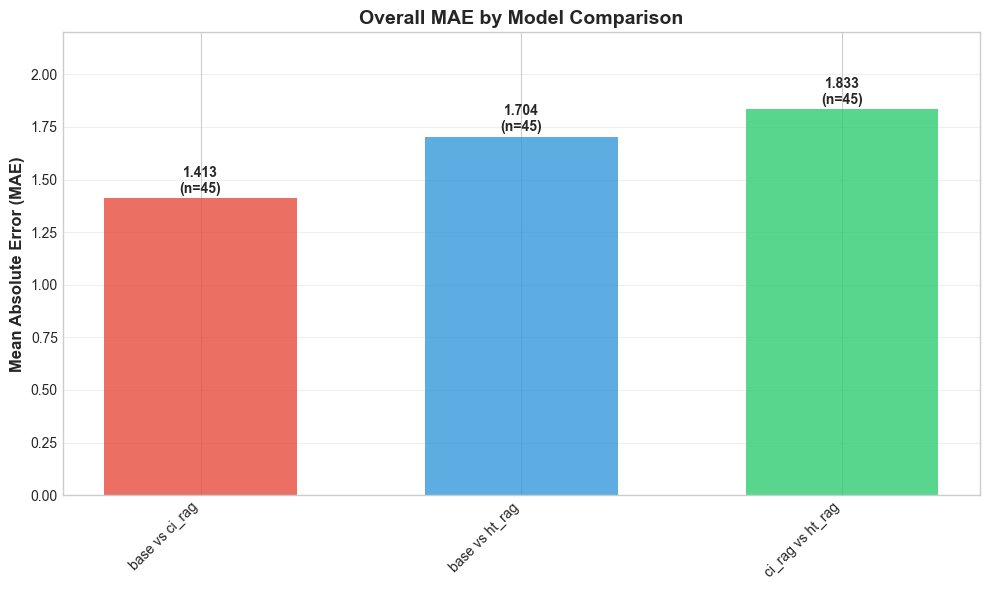

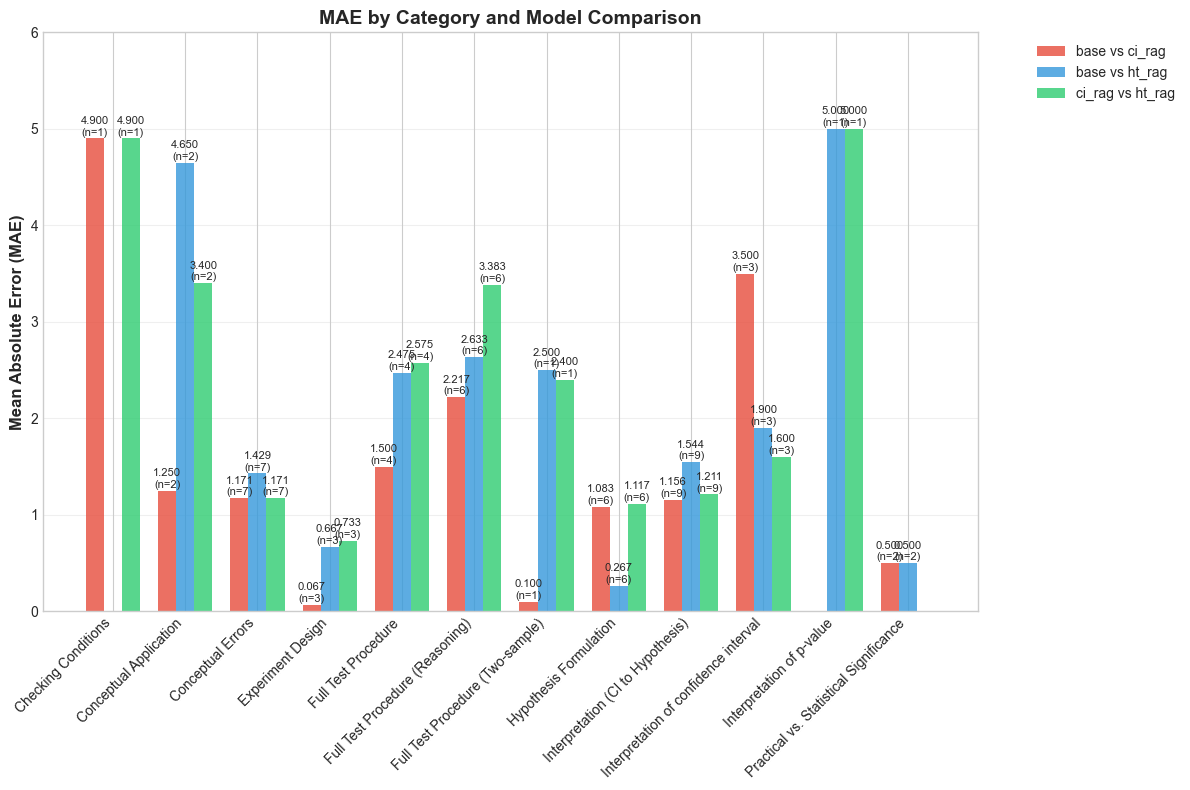


MAE SUMMARY TABLE:
------------------------------------------------------------
comparison                              base vs ci_rag  base vs ht_rag  \
category                                                                 
Checking Conditions                             4.9000          0.0000   
Conceptual Application                          1.2500          4.6500   
Conceptual Errors                               1.1714          1.4286   
Experiment Design                               0.0667          0.6667   
Full Test Procedure                             1.5000          2.4750   
Full Test Procedure (Reasoning)                 2.2167          2.6333   
Full Test Procedure (Two-sample)                0.1000          2.5000   
Hypothesis Formulation                          1.0833          0.2667   
Interpretation (CI to Hypothesis)               1.1556          1.5444   
Interpretation of confidence interval           3.5000          1.9000   
Interpretation of p-value      

In [123]:
# MAE Analysis with Separate Visualizations

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Collect MAE results for visualization
mae_results = []

for MODEL_A, MODEL_B in comparisons:
    print(f"\n=== MAE Analysis: {MODEL_A} vs {MODEL_B} ===")
    
    sub = df[df['judge']=='human']
    piv = sub[sub['model']==MODEL_A].set_index('question_id')['score_final']
    ref = sub[sub['model']==MODEL_B].set_index('question_id')['score_final']
    idx = piv.index.intersection(ref.index)
    
    if len(idx) > 0:
        mae_overall = np.abs(piv.loc[idx]-ref.loc[idx]).mean()
        print(f"MAE (Human judge, {MODEL_A} vs {MODEL_B}) overall: {float(mae_overall):.4f}")
        
        # Store overall MAE result
        mae_results.append({
            'comparison': f'{MODEL_A} vs {MODEL_B}',
            'category': 'Overall',
            'mae': float(mae_overall),
            'n': len(idx)
        })

        if 'category' in sub.columns: 
            rows = []
            for cat, grp in sub.groupby('category'):
                A = grp[grp['model']==MODEL_A].set_index('question_id')['score_final']
                B = grp[grp['model']==MODEL_B].set_index('question_id')['score_final']
                idc = A.index.intersection(B.index)
                if len(idc)==0: 
                    continue
                mae_cat = float(np.abs(A.loc[idc]-B.loc[idc]).mean())   
                rows.append({
                    'category': cat, 
                    'n': len(idc), 
                    'mae': mae_cat
                })
                
                # Store category-specific MAE result
                mae_results.append({
                    'comparison': f'{MODEL_A} vs {MODEL_B}',
                    'category': cat,
                    'mae': mae_cat,
                    'n': len(idc)
                })

            if rows:
                result_df = pd.DataFrame(rows)
                print("MAE by category:")
                print(result_df)
            else: 
                print("No categories found")
        else:
            print("No 'category' column found - skipping per-category analysis.")
    else:
        print(f"No overlap between {MODEL_A} and {MODEL_B}")

# Convert to DataFrame for visualization
mae_df = pd.DataFrame(mae_results)

if len(mae_df) > 0:
    print(f"\n{'='*60}")
    print("MAE VISUALIZATION")
    print(f"{'='*60}")
    
    # Plot 1: Overall MAE comparison (separate figure)
    overall_data = mae_df[mae_df['category'] == 'Overall']
    
    if len(overall_data) > 0:
        plt.figure(figsize=(10, 6))
        x_pos = np.arange(len(overall_data))
        bars1 = plt.bar(x_pos, overall_data['mae'], 
                       color=['#E74C3C', '#3498DB', '#2ECC71'], 
                       alpha=0.8, width=0.6)
        
        # Add value labels on bars
        for i, (bar, row) in enumerate(zip(bars1, overall_data.iterrows())):
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{height:.3f}\n(n={row[1]["n"]})',
                    ha='center', va='bottom', fontweight='bold', fontsize=10)
        
        plt.xticks(x_pos, overall_data['comparison'], rotation=45, ha='right')
        plt.ylabel('Mean Absolute Error (MAE)', fontweight='bold', fontsize=12)
        plt.title('Overall MAE by Model Comparison', fontweight='bold', fontsize=14)
        plt.grid(True, alpha=0.3, axis='y')
        plt.ylim(0, overall_data['mae'].max() * 1.2)
        plt.tight_layout()
        plt.show()
    
    # Plot 2: MAE by category (separate figure)
    category_data = mae_df[mae_df['category'] != 'Overall']
    
    if len(category_data) > 0:
        # Create pivot table for easier plotting
        pivot_data = category_data.pivot(index='category', columns='comparison', values='mae')
        pivot_counts = category_data.pivot(index='category', columns='comparison', values='n')
        
        plt.figure(figsize=(12, 8))
        
        # Create grouped bar chart
        x_pos = np.arange(len(pivot_data.index))
        width = 0.25
        colors = ['#E74C3C', '#3498DB', '#2ECC71']
        
        for i, comparison in enumerate(pivot_data.columns):
            if comparison in pivot_data.columns:
                values = pivot_data[comparison].fillna(0)
                counts = pivot_counts[comparison].fillna(0)
                
                bars2 = plt.bar(x_pos + i * width, values, width, 
                              label=comparison, color=colors[i % len(colors)], alpha=0.8)
                
                # Add value labels
                for j, (bar, val, count) in enumerate(zip(bars2, values, counts)):
                    if val > 0:  # Only label non-zero bars
                        plt.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.01,
                                f'{val:.3f}\n(n={int(count)})',
                                ha='center', va='bottom', fontsize=8, rotation=0)
        
        plt.xticks(x_pos + width, pivot_data.index, rotation=45, ha='right')
        plt.ylabel('Mean Absolute Error (MAE)', fontweight='bold', fontsize=12)
        plt.title('MAE by Category and Model Comparison', fontweight='bold', fontsize=14)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True, alpha=0.3, axis='y')
        
        if len(pivot_data.values[pivot_data.values > 0]) > 0:
            plt.ylim(0, np.max(pivot_data.values) * 1.2)
        
        plt.tight_layout()
        plt.show()
    else:
        print("No category-specific data available for visualization")
    
    # Summary table
    print(f"\nMAE SUMMARY TABLE:")
    print("-" * 60)
    summary_table = mae_df.pivot_table(index='category', columns='comparison', 
                                      values='mae', aggfunc='mean')
    print(summary_table.round(4))
    
    # Find best and worst comparisons
    overall_mae = mae_df[mae_df['category'] == 'Overall']
    if len(overall_mae) > 0:
        best_comparison = overall_mae.loc[overall_mae['mae'].idxmin()]
        worst_comparison = overall_mae.loc[overall_mae['mae'].idxmax()]
        
        print(f"\nKEY FINDINGS:")
        print(f"• Lowest MAE (most similar): {best_comparison['comparison']} = {best_comparison['mae']:.4f}")
        print(f"• Highest MAE (most different): {worst_comparison['comparison']} = {worst_comparison['mae']:.4f}")
        print(f"• MAE range: {overall_mae['mae'].min():.4f} to {overall_mae['mae'].max():.4f}")
        
        # Interpretation
        avg_mae = overall_mae['mae'].mean()
        print(f"\n🔍 INTERPRETATION:")
        print(f"• Average MAE across comparisons: {avg_mae:.4f}")
        if avg_mae < 0.5:
            print("• Models show relatively small differences (MAE < 0.5)")
        elif avg_mae < 1.0:
            print("• Models show moderate differences (0.5 ≤ MAE < 1.0)")
        else:
            print("• Models show substantial differences (MAE ≥ 1.0)")

else:
    print("No MAE data available for visualization")

print(f"\n{'='*60}")
print("MAE ANALYSIS COMPLETE")
print(f"{'='*60}")

## Bland–Altman plot


 === Bland-Altman: Human vs Qwen for base ===


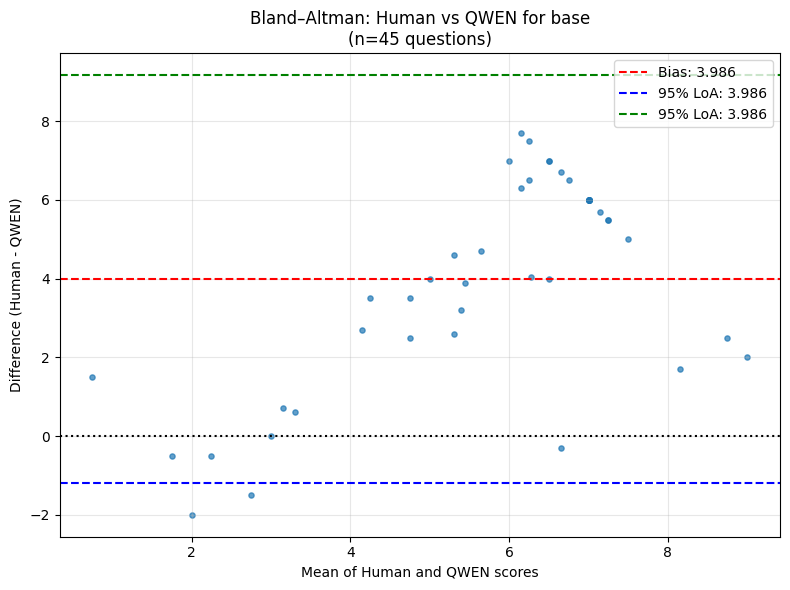

Bias (Human - QWEN): 3.9856
95% Limits of Agreement: [-1.1983, 9.1694]

 === Bland-Altman: Human vs Qwen for ci_rag ===


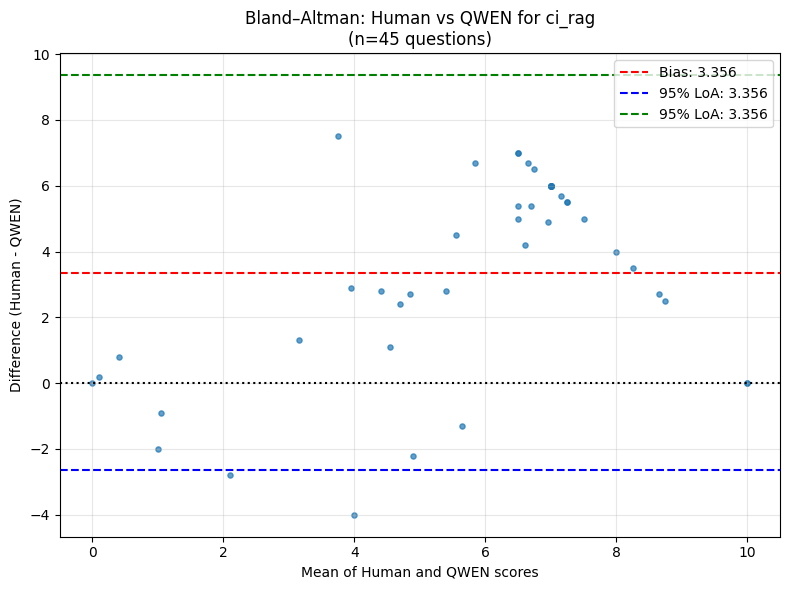

Bias (Human - QWEN): 3.3556
95% Limits of Agreement: [-2.6456, 9.3567]

 === Bland-Altman: Human vs Qwen for ht_rag ===


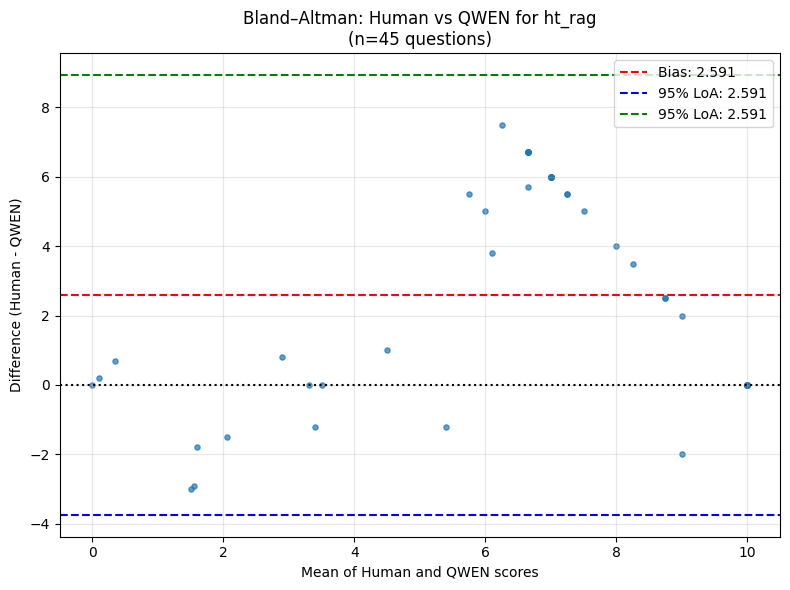

Bias (Human - QWEN): 2.5911
95% Limits of Agreement: [-3.7391, 8.9213]


In [95]:

model_comparison = ['base', 'ci_rag', 'ht_rag']
for model in model_comparison:
    print(f'\n === Bland-Altman: Human vs Qwen for {model} ===')
    human_scores = df[(df['judge'] == 'human') & (df['model'] == model)].set_index('question_id')['score_final']
    qwen_scores = df[(df['judge']=='qwen7b') & (df['model']==model)].set_index('question_id')['score_final']

    idx = human_scores.index.intersection(qwen_scores.index)


    if len(idx)>0:
        human_vec = human_scores.loc[idx].to_numpy()
        qwen_vec = qwen_scores.loc[idx].to_numpy()
        mean = (human_vec + qwen_vec)/2.0
        diff_scores = human_vec - qwen_vec
        bias = diff_scores.mean()
        sd = diff_scores.std(ddof=1) if len(diff_scores)>1 else 0.0
        lo, hi = bias - 1.96*sd, bias + 1.96*sd
   
        plt.figure(figsize=(8, 6))
        plt.scatter(mean, diff_scores, s=14, alpha=0.7)
        plt.axhline(bias, color = 'red', linestyle='--', label = f'Bias: {bias:.3f}')
        plt.axhline(lo, color = 'blue', linestyle='--', label = f'95% LoA: {bias:.3f}')
        plt.axhline(hi, color = 'green', linestyle='--', label = f'95% LoA: {bias:.3f}')
        plt.axhline(0, color='black', linestyle=':')

        plt.title(f'Bland–Altman: Human vs QWEN for {model}\n(n={len(idx)} questions)')
        plt.xlabel('Mean of Human and QWEN scores')
        plt.ylabel('Difference (Human - QWEN)')
        plt.legend()
        plt.grid(True, alpha = 0.3)
        plt.tight_layout()
        plt.show()

        print(f"Bias (Human - QWEN): {bias:.4f}")
        print(f"95% Limits of Agreement: [{lo:.4f}, {hi:.4f}]")
    else:
        print(f"No overlapping questions found for {model}.")


## Pairwise win-rate matrix & heatmap (ε margin)

In [96]:

EPSILON = 0.5

win_matrices = {}

for judge_name in ['human', 'qwen7b']:
    print(f"\n=== Win Matrix for judge: {judge_name} ===")

    sub = df[df['judge']==judge_name]
    models = sorted(sub['model'].dropna().unique().tolist())
    by_model = {m: sub[sub['model']==m].set_index('question_id')['score_final'] for m in models}
    win = pd.DataFrame(np.nan, index=models, columns=models)

    counts = {}

    for A in models:
        for B in models:
            if A == B:
                continue
            a = by_model[A]; b = by_model[B]
            idx = a.index.intersection(b.index)
            if len(idx)==0:
                counts[(A,B)] = 0
                continue
            d = (a.loc[idx] - b.loc[idx]).to_numpy()
            win.loc[A,B] = float((d > EPSILON).mean())
            counts[(A,B)] = len(idx)

    win_matrices[judge_name] = win.copy()

    print(f"\nWinrate Matrix for {judge_name}:")
    print(win.round(3))
    print(f"Sample sizes: {dict(list(counts.items())[:3])}")
          
    



=== Win Matrix for judge: human ===

Winrate Matrix for human:
         base  ci_rag  ht_rag
base      NaN   0.356   0.244
ci_rag  0.222     NaN   0.222
ht_rag  0.289   0.311     NaN
Sample sizes: {('base', 'ci_rag'): 45, ('base', 'ht_rag'): 45, ('ci_rag', 'base'): 45}

=== Win Matrix for judge: qwen7b ===

Winrate Matrix for qwen7b:
         base  ci_rag  ht_rag
base      NaN   0.200   0.133
ci_rag  0.289     NaN   0.067
ht_rag  0.356   0.311     NaN
Sample sizes: {('base', 'ci_rag'): 45, ('base', 'ht_rag'): 45, ('ci_rag', 'base'): 45}


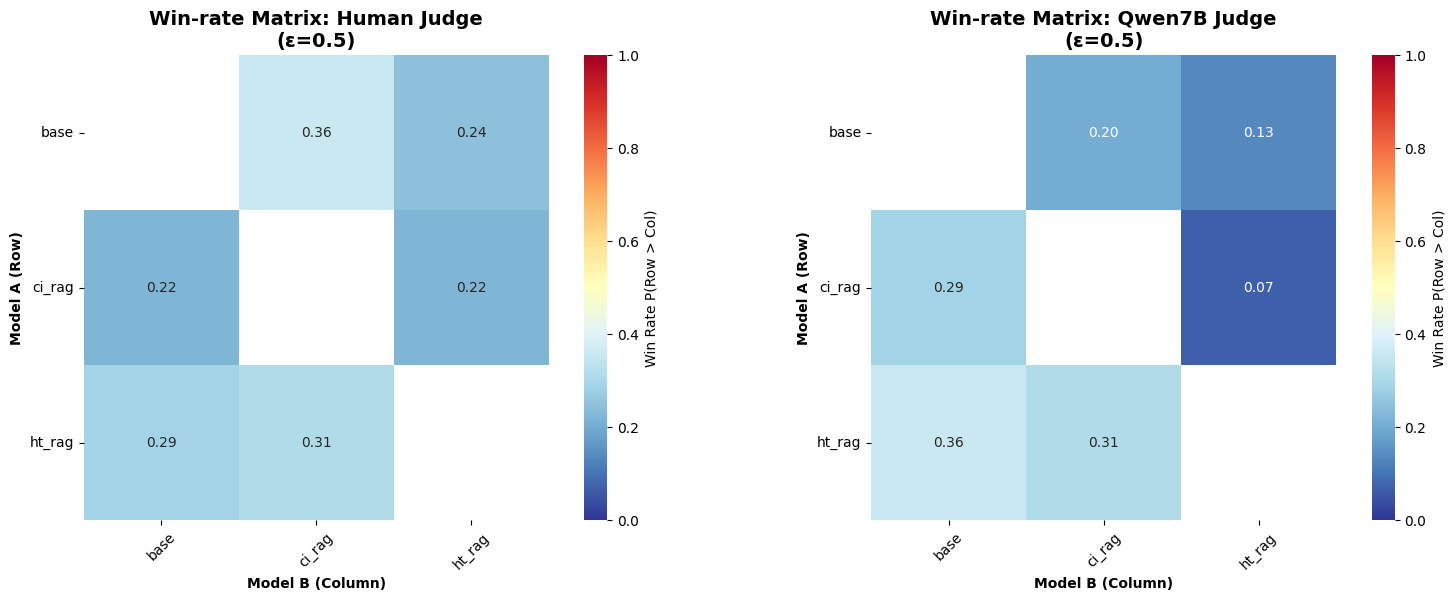

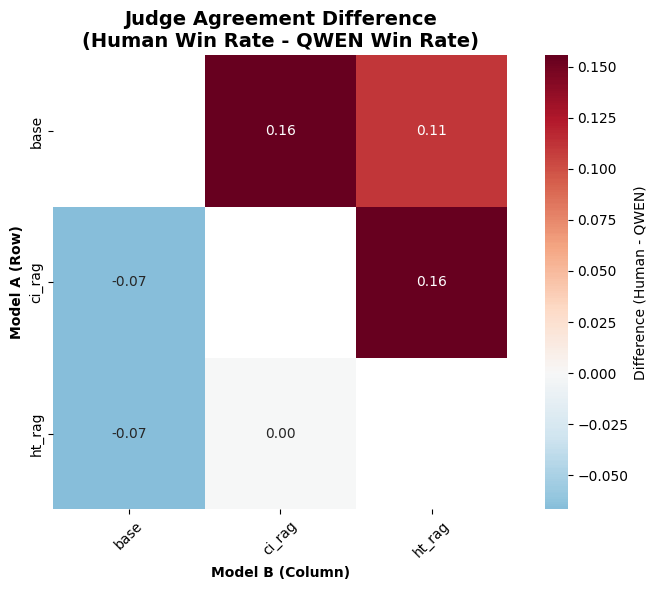

In [97]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for idx, (judge_name, win_matrix) in enumerate(win_matrices.items()):
    if win_matrix.size > 0:
        sns.heatmap(
            win_matrix.values.astype(float), 
            annot=True, 
            fmt='.2f',
            xticklabels=win_matrix.columns,
            yticklabels=win_matrix.index,
            cmap='RdYlBu_r',
            center=0.5,
            vmin=0, 
            vmax=1,
            square=True,
            cbar_kws={'label': 'Win Rate P(Row > Col)'},
            ax=axes[idx]
        )
        
        axes[idx].set_title(f'Win-rate Matrix: {judge_name.title()} Judge\n(ε={EPSILON})', 
                           fontsize=14, fontweight='bold')
        axes[idx].set_xlabel('Model B (Column)', fontweight='bold')
        axes[idx].set_ylabel('Model A (Row)', fontweight='bold')
        
        axes[idx].tick_params(axis='x', rotation=45)
        axes[idx].tick_params(axis='y', rotation=0)
        
    else:
        axes[idx].text(0.5, 0.5, f'No data for {judge_name}', 
                      ha='center', va='center', transform=axes[idx].transAxes)
        axes[idx].set_title(f'{judge_name.title()} Judge - No Data')

plt.tight_layout()
plt.show()

if len(win_matrices) == 2:
    human_matrix = win_matrices['human']
    qwen_matrix = win_matrices['qwen7b']
    
    common_models = human_matrix.index.intersection(qwen_matrix.index)
    if len(common_models) > 1:
        human_aligned = human_matrix.loc[common_models, common_models]
        qwen_aligned = qwen_matrix.loc[common_models, common_models]
        diff_matrix = human_aligned - qwen_aligned
        
        plt.figure(figsize=(8, 6))
        sns.heatmap(
            diff_matrix.values.astype(float),
            annot=True,
            fmt='.2f',
            xticklabels=diff_matrix.columns,
            yticklabels=diff_matrix.index,
            cmap='RdBu_r',  
            center=0,
            square=True,
            cbar_kws={'label': 'Difference (Human - QWEN)'}
        )
        
        plt.title('Judge Agreement Difference\n(Human Win Rate - QWEN Win Rate)', 
                 fontsize=14, fontweight='bold')
        plt.xlabel('Model B (Column)', fontweight='bold')
        plt.ylabel('Model A (Row)', fontweight='bold')
        plt.tick_params(axis='x', rotation=45)
        plt.tight_layout()
        plt.show()

Categories found: ['Hypothesis Formulation' 'Interpretation (CI to Hypothesis)'
 'Checking Conditions' 'Conceptual Application' 'Conceptual Errors'
 'Full Test Procedure' 'Interpretation of confidence interval'
 'Interpretation of p-value' 'Practical vs. Statistical Significance'
 'Full Test Procedure (Reasoning)' 'Full Test Procedure (Two-sample)'
 'Experiment Design' 'Interpretation (CI to Hypothesis']
category
Interpretation (CI to Hypothesis)         53
Conceptual Errors                         45
Hypothesis Formulation                    36
Full Test Procedure (Reasoning)           36
Full Test Procedure                       24
Interpretation of confidence interval     18
Experiment Design                         18
Practical vs. Statistical Significance    12
Conceptual Application                     9
Checking Conditions                        6
Interpretation of p-value                  6
Full Test Procedure (Two-sample)           6
Interpretation (CI to Hypothesis           

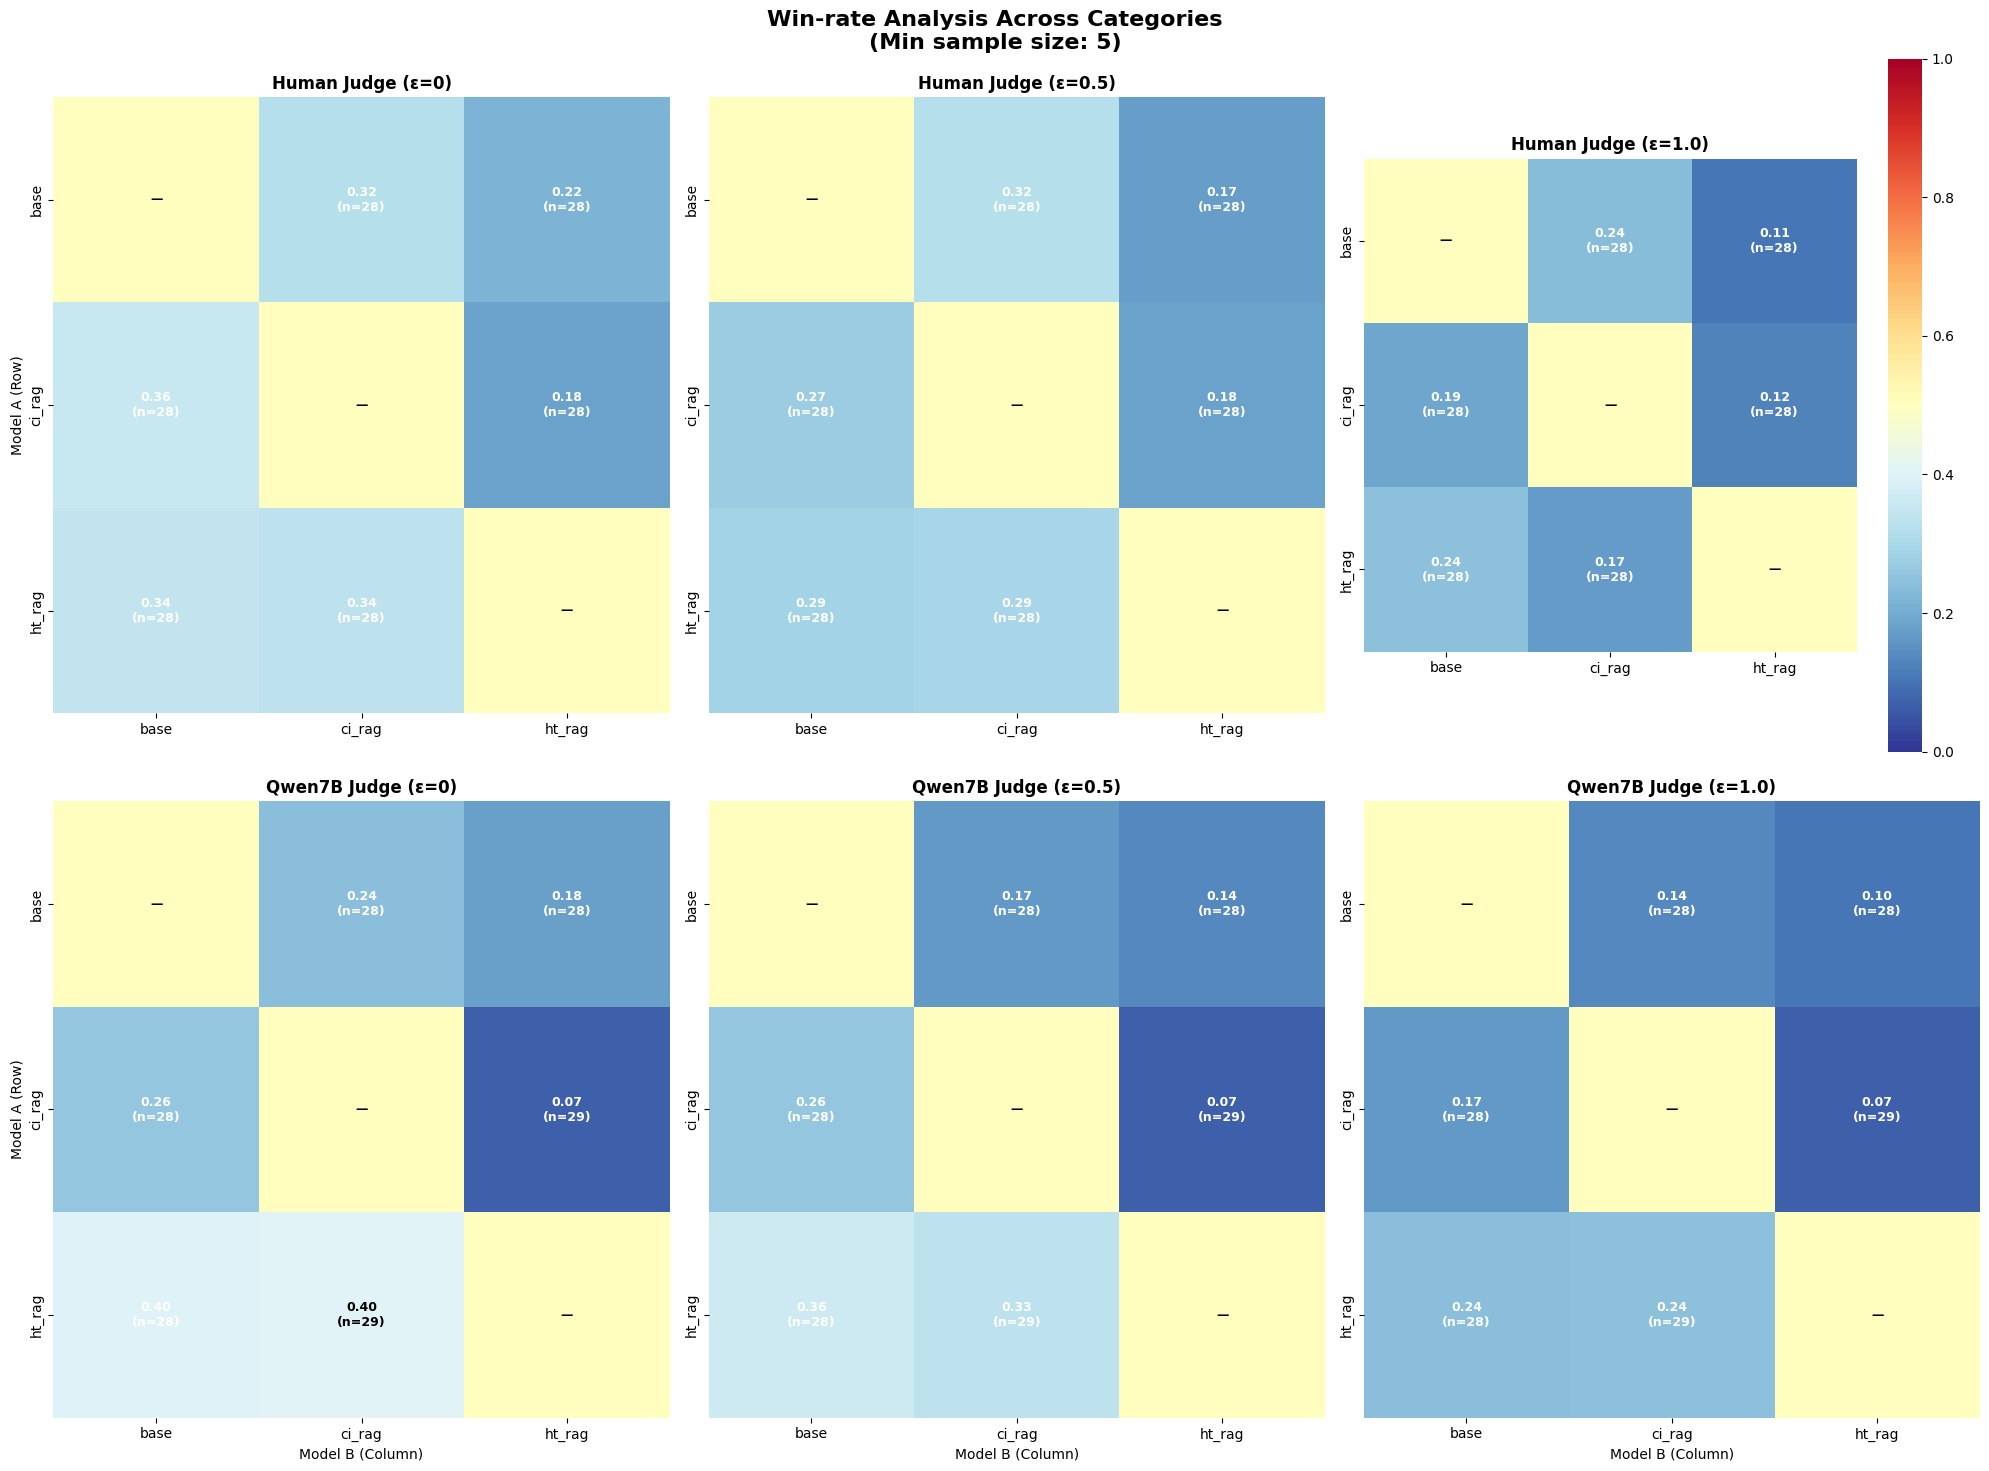

In [98]:
if 'category' not in df.columns:
    print("No category found for this column")
    df['category'] = df['domain']

print("Categories found:", df['category'].unique())
print(df['category'].value_counts())

EPSILONS = [0, 0.5, 1.0]
min_sample_size = 5

def calculate_category_wr(df, judge_name, epsilon, min_n=5):
    sub = df[df['judge'] == judge_name]
    models = sorted(sub['model'].dropna().unique().tolist())
    categories = sorted(sub['category'].dropna().unique().tolist())

    results = {}

    for category in categories:
        cat_data = sub[sub['category'] == category] 
        by_model = {m: cat_data[cat_data['model']==m].set_index('question_id')['score_final']
                    for m in models}
        
        win_matrix = pd.DataFrame(np.nan, index=models, columns=models)
        count_matrix = pd.DataFrame(0, index=models, columns=models)

        for A in models:
            for B in models:
                if A == B:
                    win_matrix.loc[A, B] = 0.5
                    continue 

                a_scores = by_model[A]
                b_scores = by_model[B]
                idx = a_scores.index.intersection(b_scores.index)

                if len(idx) >= min_n:
                    d = (a_scores.loc[idx] - b_scores.loc[idx]).to_numpy()
                    win_rate = float((d > epsilon).mean())
                    win_matrix.loc[A, B] = win_rate
                    count_matrix.loc[A, B] = len(idx)
        
        results[category] = {
            'win_matrix': win_matrix,
            'count_matrix': count_matrix
        }
    
    return results


category_results = {}
for judge in ['human', 'qwen7b']: 
    category_results[judge] = {}
    for eps in EPSILONS:
        category_results[judge][eps] = calculate_category_wr(df, judge, eps, min_sample_size)


fig = plt.figure(figsize=(20, 15))

for judge_idx, judge_name in enumerate(['human', 'qwen7b']):
    for eps_idx, eps in enumerate(EPSILONS):
        subplot_idx = judge_idx * len(EPSILONS) + eps_idx + 1
        ax = plt.subplot(2, 3, subplot_idx)
        

        results = category_results[judge_name][eps]

        if not results:
            ax.text(0.5, 0.5, 'No data', ha='center', va='center')
            ax.set_title(f'{judge_name.title()} (ε={eps})')
            continue

        categories = list(results.keys())
        if not categories:  
            ax.text(0.5, 0.5, 'No categories', ha='center', va='center')
            ax.set_title(f'{judge_name.title()} (ε={eps})')
            continue
            
        models = list(results[categories[0]]['win_matrix'].index)

        agg_win_matrix = np.full((len(models), len(models)), np.nan)
        agg_count_matrix = np.zeros((len(models), len(models)))

        for i, model_a in enumerate(models):
            for j, model_b in enumerate(models):
                if i == j:
                    agg_win_matrix[i, j] = 0.5
                    continue 
                
                valid_winrates = []
                total_count = 0

                for category in categories: 
                    win_val = results[category]['win_matrix'].loc[model_a, model_b]
                    count_val = results[category]['count_matrix'].loc[model_a, model_b]
                    
                    if not pd.isna(win_val) and count_val >= min_sample_size:
                        valid_winrates.append(win_val)
                        total_count += count_val
                
                if valid_winrates:
                    agg_win_matrix[i, j] = np.mean(valid_winrates)
                    agg_count_matrix[i, j] = total_count


        mask = agg_count_matrix < min_sample_size
        mask[np.diag_indices_from(mask)] = False 

        sns.heatmap(agg_win_matrix,
            annot=False,
            mask=mask,
            xticklabels=models,
            yticklabels=models,
            cmap='RdYlBu_r',
            center=0.5,
            vmin=0,
            vmax=1,
            square=True,
            cbar=subplot_idx == 3, 
            ax=ax
        )

  
        for i in range(len(models)):
            for j in range(len(models)):
                if not mask[i, j]:
                    win_rate = agg_win_matrix[i, j]
                    n_samples = int(agg_count_matrix[i, j])
                        
                    if i == j:
                        text = "—"
                    else:
                        text = f"{win_rate:.2f}\n(n={n_samples})"
                        
                    text_color = 'white' if win_rate > 0.6 or win_rate < 0.4 else 'black'
                    ax.text(j + 0.5, i + 0.5, text, ha='center', va='center',
                            color=text_color, fontsize=9, fontweight='bold')

        ax.set_title(f'{judge_name.title()} Judge (ε={eps})', 
                    fontsize=12, fontweight='bold')
        ax.set_xlabel('Model B (Column)' if judge_idx == 1 else '')
        ax.set_ylabel('Model A (Row)' if eps_idx == 0 else '')

plt.suptitle(f'Win-rate Analysis Across Categories\n(Min sample size: {min_sample_size})', 
            fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


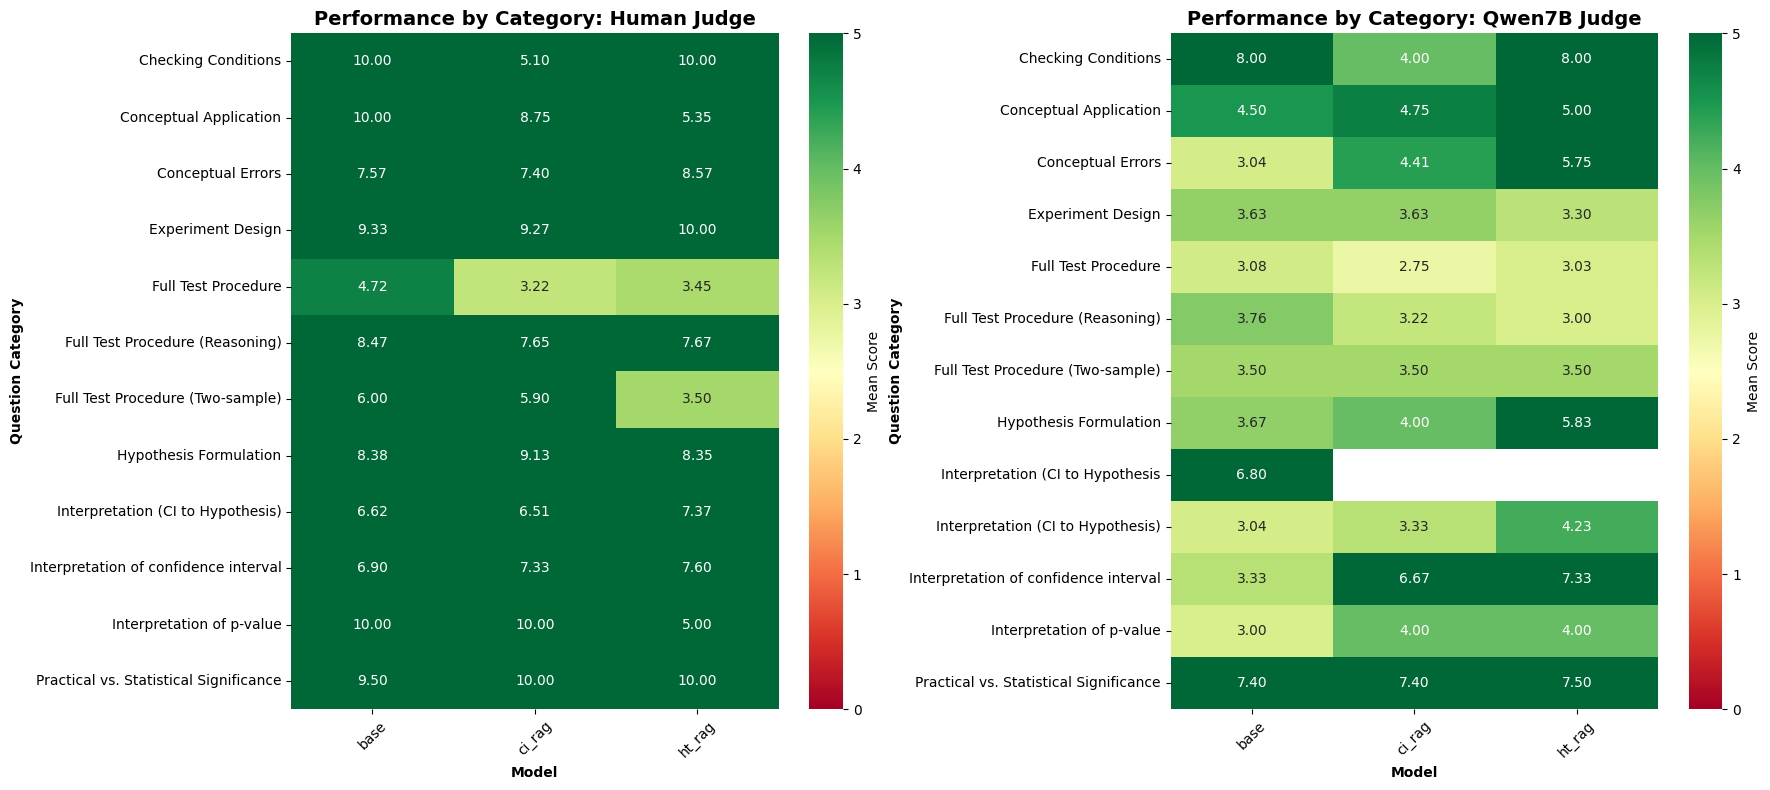

In [71]:
# Category-based Performance Analysis
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

for idx, judge_name in enumerate(['human', 'qwen7b']):
    sub = df[df['judge'] == judge_name]
    
    # Prepare data for heatmap
    models = sorted(sub['model'].unique())
    categories = sorted(sub['category'].unique())
    
    # Create matrix of mean scores
    heatmap_data = np.full((len(categories), len(models)), np.nan)
    for j, model in enumerate(models):
        for i, category in enumerate(categories):
            model_cat_data = sub[(sub['model'] == model) & (sub['category'] == category)]
            if len(model_cat_data) > 0:
                heatmap_data[i, j] = model_cat_data['score_final'].mean()
    
    # Create heatmap
    sns.heatmap(
        heatmap_data,
        annot=True,
        fmt='.2f',
        xticklabels=models,
        yticklabels=categories,
        cmap='RdYlGn',  # Red=low, Yellow=medium, Green=high performance
        center=2.5,     # Adjust based on your scoring scale
        vmin=0,
        vmax=5,         # Adjust based on your scoring scale
        square=False,
        cbar_kws={'label': 'Mean Score'},
        ax=axes[idx]
    )
    
    axes[idx].set_title(f'Performance by Category: {judge_name.title()} Judge', 
                       fontsize=14, fontweight='bold')
    axes[idx].set_xlabel('Model', fontweight='bold')
    axes[idx].set_ylabel('Question Category', fontweight='bold')
    axes[idx].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

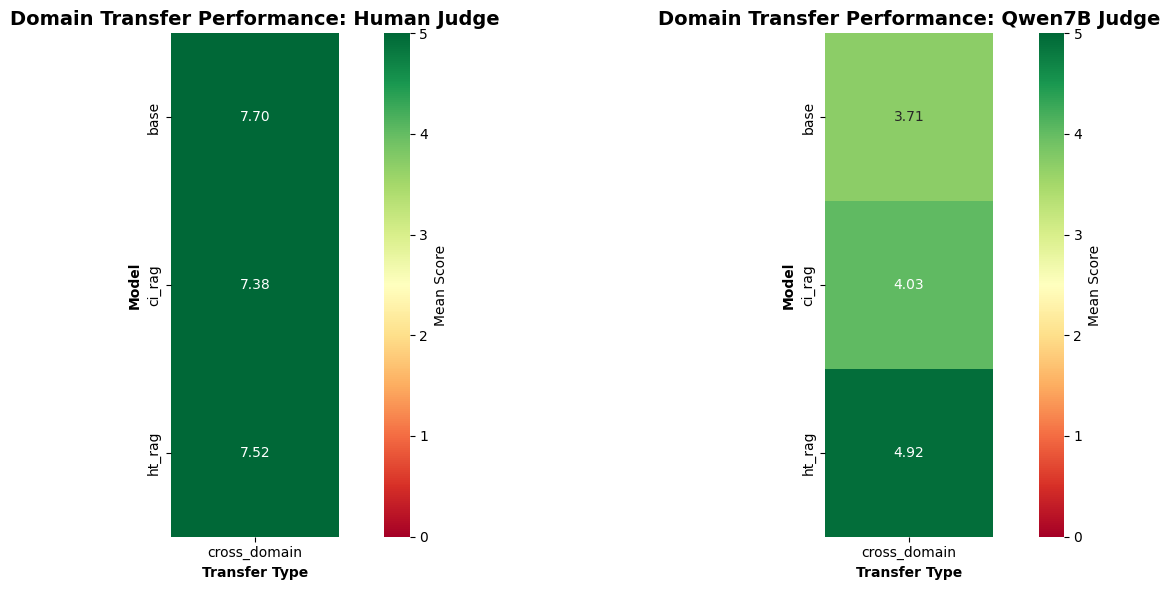

In [99]:
# Cross-Domain Transfer Analysis Heatmap
transfer_results = []

for judge_name in ['human', 'qwen7b']:
    sub = df[df['judge']==judge_name]
    
    for _, row in sub.iterrows():
        model_domain = row['domain']
        question_category = row['category']
        
        # Determine if this is in-domain or cross-domain
        domain_match = 'in_domain' if model_domain.replace('_', '') in question_category.replace('_', '') else 'cross_domain'
        
        transfer_results.append({
            'judge': judge_name,
            'model': row['model'],
            'model_domain': model_domain,
            'question_category': question_category,
            'transfer_type': domain_match,
            'score': row['score_final']
        })

transfer_df = pd.DataFrame(transfer_results)

# Visualize transfer performance
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for idx, judge in enumerate(['human', 'qwen7b']):
    judge_data = transfer_df[transfer_df['judge']==judge]
    
    # Create pivot table for heatmap
    pivot_data = judge_data.pivot_table(
        values='score', 
        index='model', 
        columns='transfer_type', 
        aggfunc='mean'
    )
    
    sns.heatmap(
        pivot_data,
        annot=True,
        fmt='.2f',
        cmap='RdYlGn',
        center=2.5,
        vmin=0,
        vmax=5,
        square=True,
        cbar_kws={'label': 'Mean Score'},
        ax=axes[idx]
    )
    
    axes[idx].set_title(f'Domain Transfer Performance: {judge.title()} Judge', 
                       fontsize=14, fontweight='bold')
    axes[idx].set_xlabel('Transfer Type', fontweight='bold')
    axes[idx].set_ylabel('Model', fontweight='bold')

plt.tight_layout()
plt.show()

## Bradley–Terry ranking (simple MM)

Bradley-Terry Ranking
Bradley-Terry ranking for judge: human
--------------------------------------------------
Win-rate matrix (ε=0.5):
         base  ci_rag  ht_rag
base      NaN   0.311   0.311
ci_rag  0.311     NaN   0.311
ht_rag  0.311   0.311     NaN

Bradley-Terry Rankings:
   rank   model  ability   logit
2     1  ht_rag   1.3732  0.3172
1     2  ci_rag   0.8997 -0.1057
0     3    base   0.8094 -0.2114
Bradley-Terry ranking for judge: qwen7b
--------------------------------------------------
Win-rate matrix (ε=0.5):
         base  ci_rag  ht_rag
base      NaN   0.311   0.311
ci_rag  0.311     NaN   0.311
ht_rag  0.311   0.311     NaN

Bradley-Terry Rankings:
   rank   model  ability   logit
2     1  ht_rag   1.3732  0.3172
1     2  ci_rag   0.8997 -0.1057
0     3    base   0.8094 -0.2114
Ranking comparison between HUMAN AND QWEN judges
--------------------------------------------------
Model comparison:
         model  human_rank  qwen_rank  human_ability  qwen_ability  rank_di

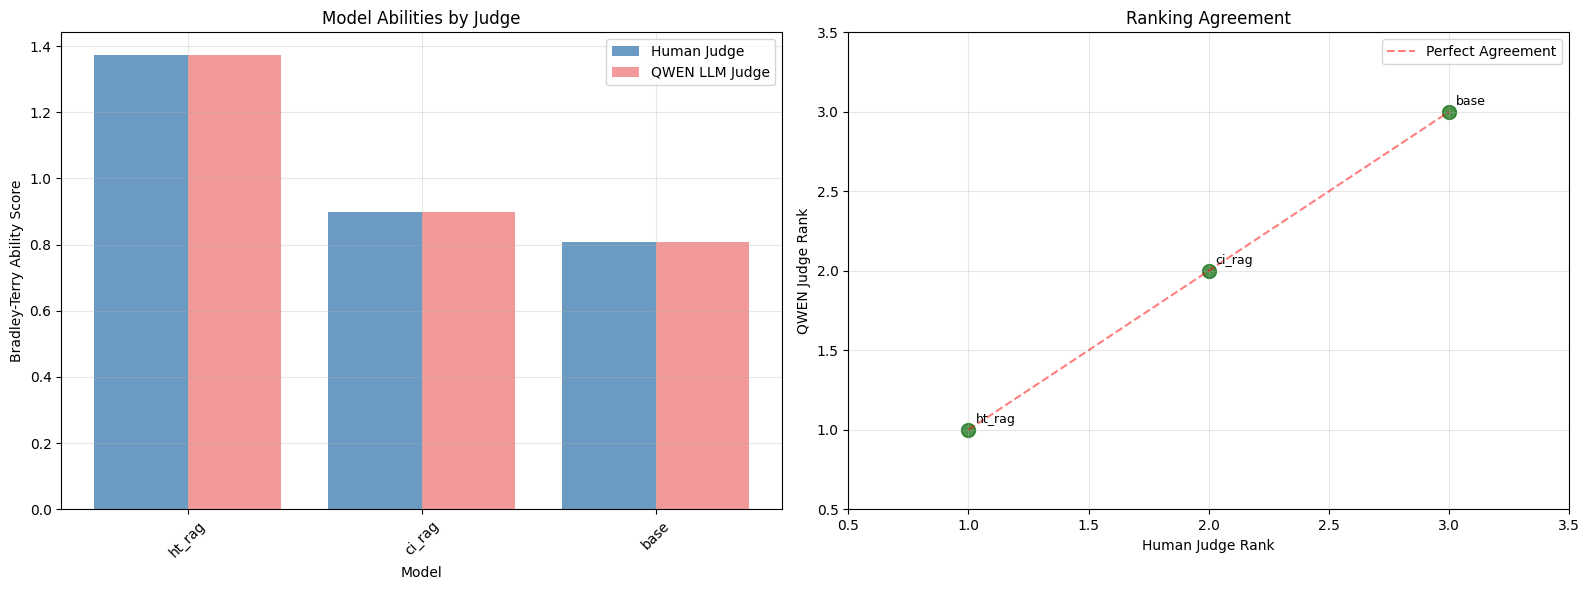


INTERPRETATION:
• Higher ability score = Better overall performance
• Rank 1 = Best performing model
• Ability scores are relative (normalized to geometric mean = 1)
• Strong rank correlation = Judges agree on model ordering


In [102]:
def bt_ranking(win_matrix, counts_dict, judge_name):
    models = list(win.index)
    k = len(models)
    W = np.zeros((k,k))
    N = np.zeros((k,k))

    for i,A in enumerate(models):
        for j,B in enumerate(models):
            if A==B: 
                continue
            wr = win.loc[A,B]
            n  = counts.get((A,B),0)
            if pd.notna(wr) and n>0:
                W[i,j] = wr * n
                N[i,j] = n

    abil = np.ones(k, dtype=float)
    for iteration in range(300):
        old_abil = abil.copy()
        for i in range(k):
            denom = 0.0
            for j in range(k):
                if i==j or (N[i,j]+N[j,i])==0: 
                    continue
                denom += (N[i,j]+N[j,i])/(abil[i]+abil[j])
    #total wins for model 1        
            wins_i = W[i,:].sum() + (N[:,i].sum() - W[:,i].sum())
            if denom>0:
                abil[i] = wins_i / denom

        geometric_mean = abil.prod()**(1.0/k) if k>0 else 1.0
        if geometric_mean > 0:
            abil /= geometric_mean
        if np.max(np.abs(abil-old_abil)) < 1e-8:
            break

    results_dataframe = pd.DataFrame({'model': models, 'ability': abil, 'logit': np.log(abil+1e-12)}).sort_values('ability', ascending=False)

    results_dataframe['rank'] = range(1, len(results_dataframe)+1)
    return results_dataframe

print('='*60)
print('Bradley-Terry Ranking')
print('='*60)

EPSILON = 0.5
rankings = {}

for judge_name in ['human', 'qwen7b']:
    print(f'Bradley-Terry ranking for judge: {judge_name}')
    print("-"*50)

    sub = df[df['judge']==judge_name]
    models = sorted(sub['model'].dropna().unique().tolist())


    by_model = {m: sub[sub['model'] == m].set_index('question_id')['score_final']
                for m in models}
    win_matrix = pd.DataFrame(np.nan, index=models, columns=models)
    counts = {}

    for A in models:
        for B in models:
            if A == B:
                continue
            scores_a = by_model[A]
            scores_b = by_model[B]
            idx = a.index.intersection(b.index)
            if len(idx) == 0:
                counts[(A, B)] = 0
                continue
            diff = (scores_a.loc[idx] - scores_b.loc[idx]).to_numpy()
            win_matrix.loc[A, B] = float((d > EPSILON).mean())
            counts[(A, B)] = len(idx)

    bt_results = bt_ranking(win_matrix, counts, judge_name)
    rankings[judge_name] = bt_results

    print(f"Win-rate matrix (ε={EPSILON}):")
    print(win_matrix.round(3))
    print(f"\nBradley-Terry Rankings:")
    print(bt_results[['rank', 'model', 'ability', 'logit']].round(4))

    """Comapre rankings between QWEN and Human judges"""

if len(rankings) == 2: 
    print('Ranking comparison between HUMAN AND QWEN judges')   
    print('-'*50)

    human_rank = rankings['human'].set_index('model')['rank']
    qwen_rank = rankings['qwen7b'].set_index('model')['rank']   

    common_models = human_rank.index.intersection(qwen_rank.index)
    
    comparison = pd.DataFrame({
        'model': common_models,
        'human_rank': human_rank.loc[common_models],
        'qwen_rank': qwen_rank.loc[common_models],
        'human_ability': rankings['human'].set_index('model')['ability'].loc[common_models],
        'qwen_ability': rankings['qwen7b'].set_index('model')['ability'].loc[common_models]
    })
    
    comparison['rank_diff'] = comparison['qwen_rank'] - comparison['human_rank']
    comparison = comparison.sort_values('human_rank')
    
    print("Model comparison:")
    print(comparison.round(4))

    from scipy.stats import spearmanr, kendalltau
    
    if len(common_models) > 2:
        spearman_corr, spearman_p = spearmanr(comparison['human_rank'], comparison['qwen_rank'])
        kendall_corr, kendall_p = kendalltau(comparison['human_rank'], comparison['qwen_rank'])
        
        print(f"\nRanking Agreement:")
        print(f"  Spearman ρ: {spearman_corr:.3f} (p={spearman_p:.3f})")
        print(f"  Kendall τ: {kendall_corr:.3f} (p={kendall_p:.3f})")
        
        if abs(spearman_corr) > 0.8:
            agreement = "Strong"
        elif abs(spearman_corr) > 0.6:
            agreement = "Moderate" 
        elif abs(spearman_corr) > 0.3:
            agreement = "Weak"
        else:
            agreement = "Very weak"
            
        print(f"Agreement leve between judges: {agreement}")

if len(rankings) == 2:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    models = comparison['model'].tolist()
    x_pos = np.arange(len(models))
    
    ax1.bar(x_pos - 0.2, comparison['human_ability'], 0.4, 
            label='Human Judge', alpha=0.8, color='steelblue')
    ax1.bar(x_pos + 0.2, comparison['qwen_ability'], 0.4, 
            label='QWEN LLM Judge', alpha=0.8, color='lightcoral')
    
    ax1.set_xlabel('Model')
    ax1.set_ylabel('Bradley-Terry Ability Score')
    ax1.set_title('Model Abilities by Judge')
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels(models, rotation=45)
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    ax2.scatter(comparison['human_rank'], comparison['qwen_rank'], 
               s=100, alpha=0.7, color='darkgreen')
    
    for i, model in enumerate(comparison['model']):
        ax2.annotate(model, 
                    (comparison.iloc[i]['human_rank'], comparison.iloc[i]['qwen_rank']),
                    xytext=(5, 5), textcoords='offset points', fontsize=9)
        
    min_rank, max_rank = 1, len(models)
    ax2.plot([min_rank, max_rank], [min_rank, max_rank], 
             'r--', alpha=0.5, label='Perfect Agreement')
    
    ax2.set_xlabel('Human Judge Rank')
    ax2.set_ylabel('QWEN Judge Rank')
    ax2.set_title('Ranking Agreement')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_xlim(0.5, len(models) + 0.5)
    ax2.set_ylim(0.5, len(models) + 0.5)
    
    plt.tight_layout()
    plt.show()

print(f"\n" + "="*60)
print("INTERPRETATION:")
print("• Higher ability score = Better overall performance")
print("• Rank 1 = Best performing model") 
print("• Ability scores are relative (normalized to geometric mean = 1)")
print("• Strong rank correlation = Judges agree on model ordering")
print("="*60)
    

ENHANCED BRADLEY-TERRY ANALYSIS WITH UNCERTAINTY

1. DETAILED PAIRWISE WIN/LOSS/TIE ANALYSIS
--------------------------------------------------

HUMAN JUDGE:

Pairwise Comparison Summary:
  Model_A Model_B  Wins_A  Wins_B  Ties  Total  WinRate_A  CI_Lower  CI_Upper
0    base  ci_rag      16      10    19     45      0.356     0.232     0.502
1    base  ht_rag      11      13    21     45      0.244     0.142     0.387
2  ci_rag    base      10      16    19     45      0.222     0.125     0.363
3  ci_rag  ht_rag      10      14    21     45      0.222     0.125     0.363
4  ht_rag    base      13      11    21     45      0.289     0.177     0.434
5  ht_rag  ci_rag      14      10    21     45      0.311     0.195     0.457


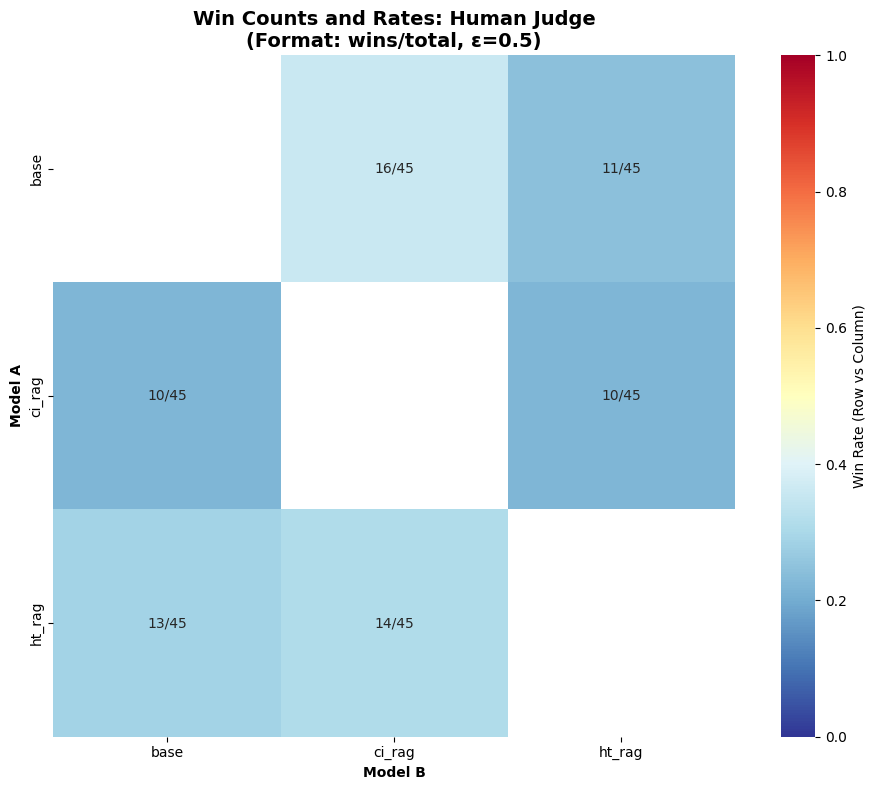


QWEN7B JUDGE:

Pairwise Comparison Summary:
  Model_A Model_B  Wins_A  Wins_B  Ties  Total  WinRate_A  CI_Lower  CI_Upper
0    base  ci_rag       9      13    23     45      0.200     0.109     0.338
1    base  ht_rag       6      16    23     45      0.133     0.063     0.262
2  ci_rag    base      13       9    23     45      0.289     0.177     0.434
3  ci_rag  ht_rag       3      14    28     45      0.067     0.023     0.179
4  ht_rag    base      16       6    23     45      0.356     0.232     0.502
5  ht_rag  ci_rag      14       3    28     45      0.311     0.195     0.457


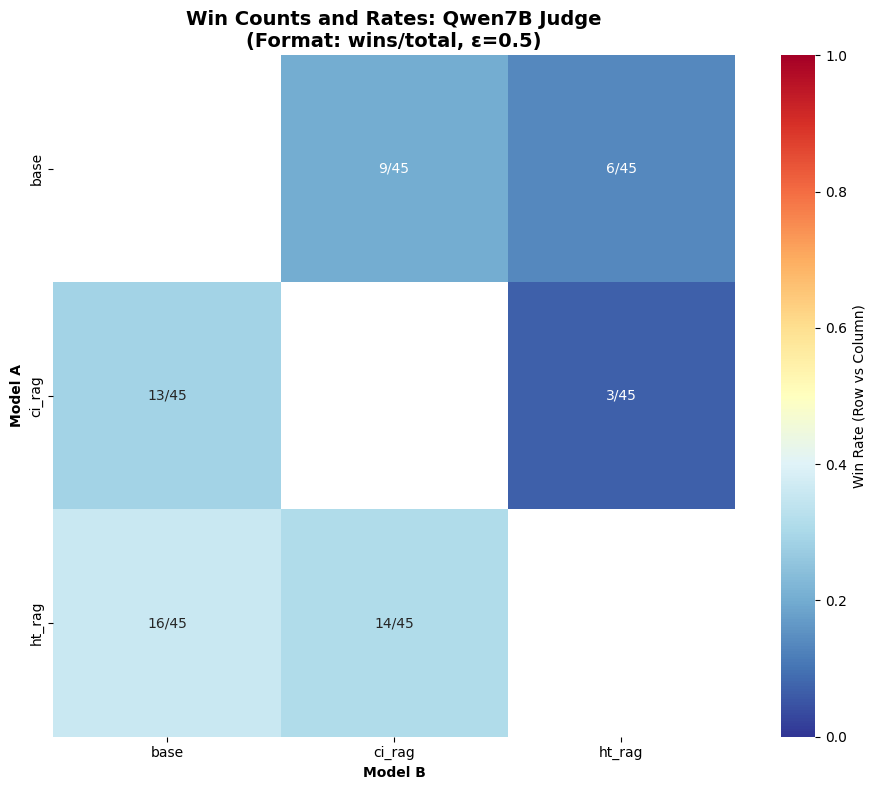


2. BRADLEY-TERRY RANKINGS WITH UNCERTAINTY
--------------------------------------------------

HUMAN JUDGE:

Rankings with 95% Confidence Intervals:
   rank   model  ability  ci_lower  ci_upper
2     1  ht_rag   1.0934    0.9013    1.2933
0     2    base   1.0613    0.9010    1.2911
1     3  ci_rag   0.8618    0.7275    1.0150

QWEN7B JUDGE:

Rankings with 95% Confidence Intervals:
   rank   model  ability  ci_lower  ci_upper
2     1  ht_rag   1.3732    1.1784    1.6434
1     2  ci_rag   0.8997    0.7608    1.0304
0     3    base   0.8094    0.6892    0.9849


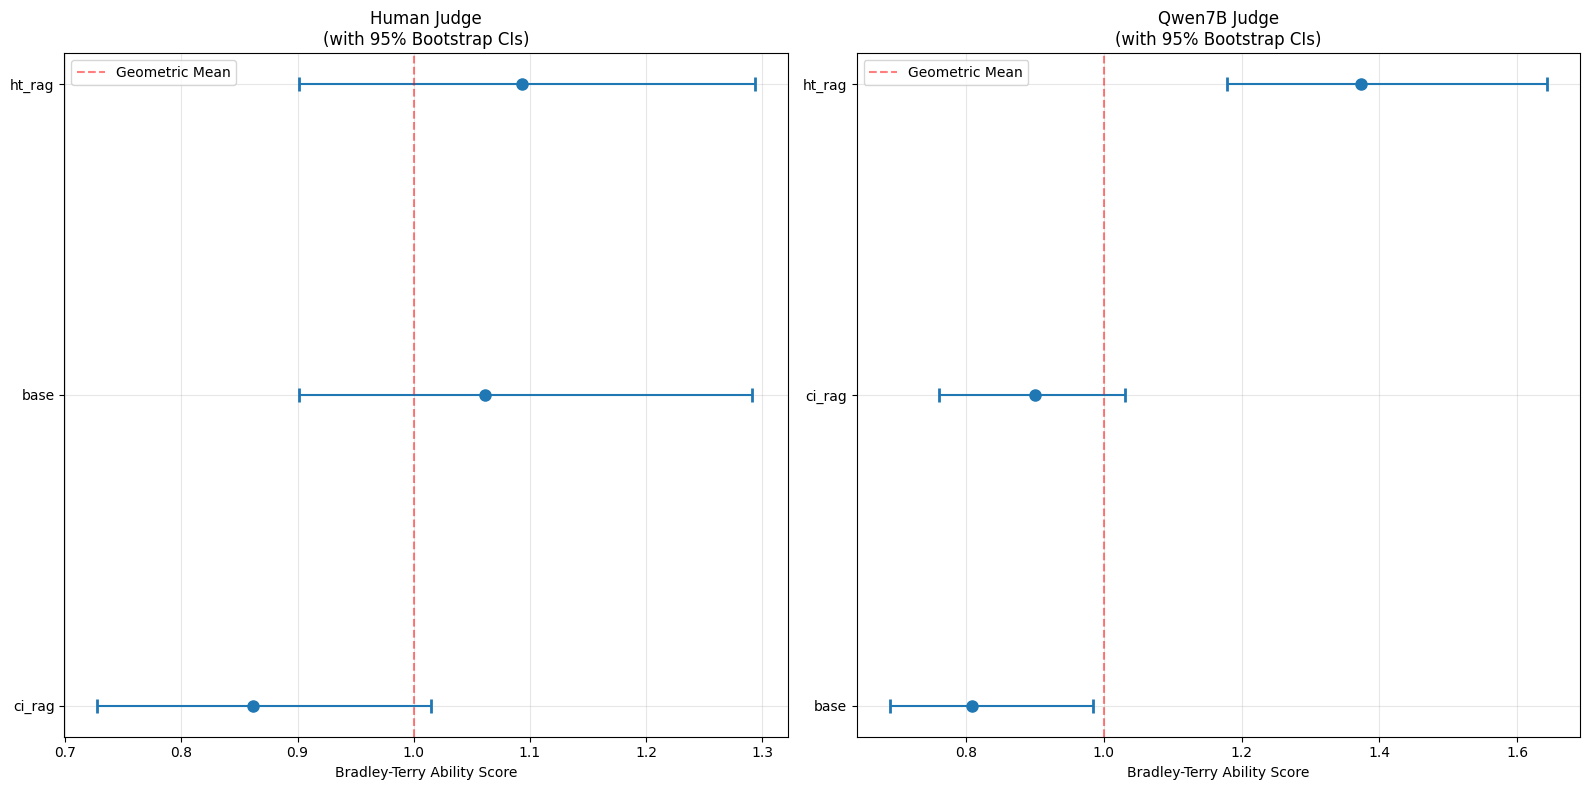


3. PER-CATEGORY BRADLEY-TERRY ANALYSIS
--------------------------------------------------

HUMAN JUDGE - CATEGORY RANKINGS:

  HYPOTHESIS FORMULATION:
   rank   model  ability  ci_lower  ci_upper
1     1  ci_rag    1.118     0.711     1.808
2     2  ht_rag    1.000     0.626     1.435
0     3    base    0.895     0.553     1.406

  INTERPRETATION (CI TO HYPOTHESIS):
   rank   model  ability  ci_lower  ci_upper
0     1    base    1.077     0.738     1.729
2     2  ht_rag    1.077     0.683     1.592
1     3  ci_rag    0.862     0.578     1.252

  CHECKING CONDITIONS:
   rank   model  ability  ci_lower  ci_upper
0     1    base    1.252     1.252     1.252
2     2  ht_rag    1.252     1.252     1.252
1     3  ci_rag    0.000     0.000     0.000

  CONCEPTUAL APPLICATION:
   rank   model  ability  ci_lower  ci_upper
0     1    base    2.130     1.000   112.420
1     2  ci_rag    1.000     0.097     2.368
2     3  ht_rag    0.469     0.000     1.000

  CONCEPTUAL ERRORS:
   rank   model  

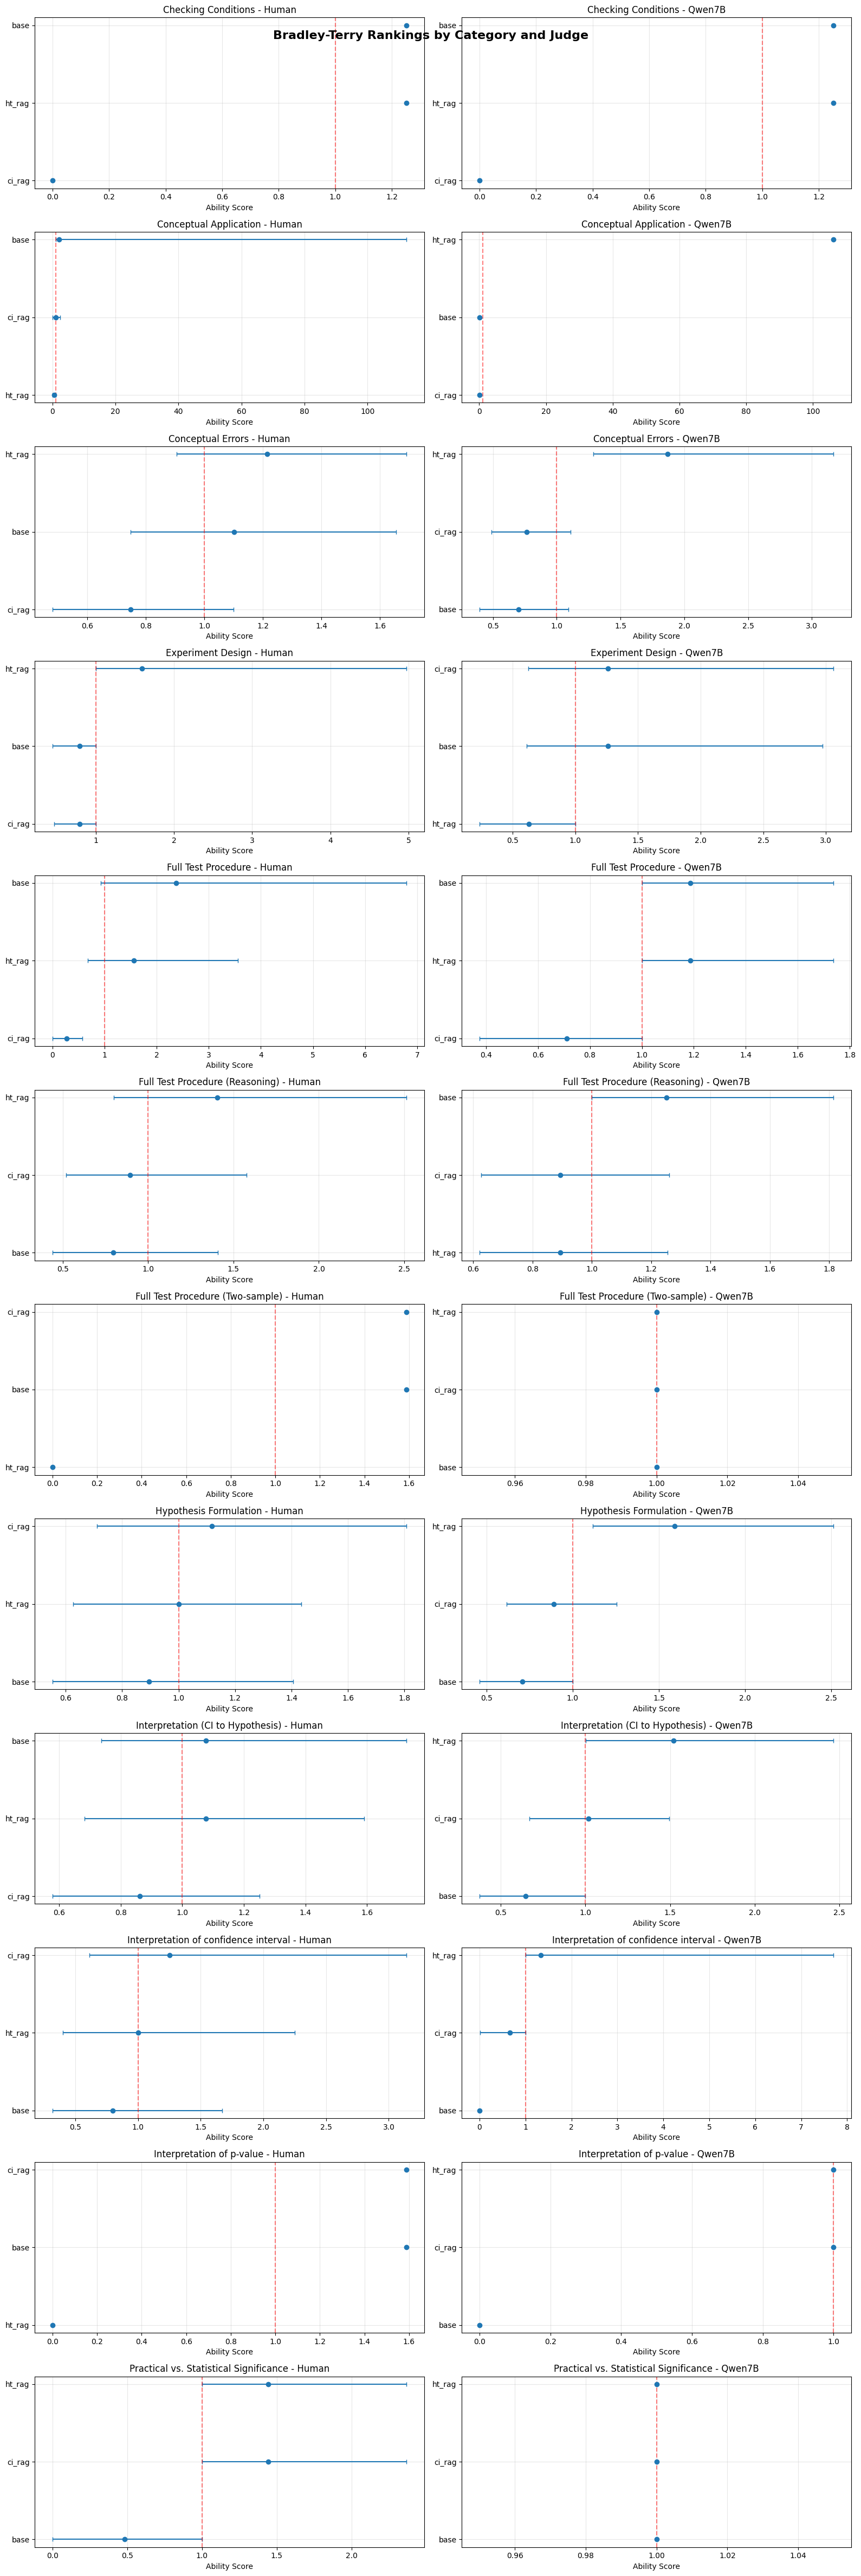


INTERPRETATION:
• Win counts show raw pairwise comparisons (A beats B)
• Confidence intervals indicate uncertainty in ability estimates
• Per-category analysis reveals task-specific ranking patterns
• Bootstrap CIs account for sampling uncertainty
• Narrow CIs = more confident estimates


In [103]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2
import warnings

def detailed_pairwise_analysis(df, judge_name, epsilon=0.5):
    """
    Calculate detailed win/loss/tie counts between all model pairs
    """
    sub = df[df['judge'] == judge_name]
    models = sorted(sub['model'].dropna().unique().tolist())
    
    # Create detailed results matrix
    results = []
    
    for A in models:
        for B in models:
            if A == B:
                continue
                
            scores_a = sub[sub['model'] == A].set_index('question_id')['score_final']
            scores_b = sub[sub['model'] == B].set_index('question_id')['score_final']
            idx = scores_a.index.intersection(scores_b.index)
            
            if len(idx) == 0:
                continue
                
            diff = scores_a.loc[idx] - scores_b.loc[idx]
            
            wins_a = int((diff > epsilon).sum())
            wins_b = int((diff < -epsilon).sum())
            ties = int((np.abs(diff) <= epsilon).sum())
            total = len(diff)
            
            win_rate_a = wins_a / total if total > 0 else 0
            
            # Calculate Wilson confidence interval for win rate
            if total > 0:
                z = 1.96  # 95% CI
                p_hat = win_rate_a
                n = total
                
                denominator = 1 + z**2/n
                center = (p_hat + z**2/(2*n)) / denominator
                margin = z * np.sqrt(p_hat*(1-p_hat)/n + z**2/(4*n**2)) / denominator
                
                ci_lower = max(0, center - margin)
                ci_upper = min(1, center + margin)
            else:
                ci_lower = ci_upper = 0
            
            results.append({
                'Model_A': A,
                'Model_B': B,
                'Wins_A': wins_a,
                'Wins_B': wins_b,
                'Ties': ties,
                'Total': total,
                'WinRate_A': win_rate_a,
                'CI_Lower': ci_lower,
                'CI_Upper': ci_upper,
                'Judge': judge_name
            })
    
    return pd.DataFrame(results)

def bt_ranking_with_uncertainty(win_matrix, counts_dict, models, bootstrap_samples=1000):
    """
    Bradley-Terry ranking with bootstrap uncertainty estimation
    """
    def bt_fit(W, N):
        k = len(models)
        abil = np.ones(k, dtype=float)
        
        for iteration in range(300):
            old_abil = abil.copy()
            for i in range(k):
                denom = 0.0
                for j in range(k):
                    if i == j or (N[i,j] + N[j,i]) == 0:
                        continue
                    denom += (N[i,j] + N[j,i]) / (abil[i] + abil[j])
                
                wins_i = W[i,:].sum() + (N[:,i].sum() - W[:,i].sum())
                if denom > 0:
                    abil[i] = wins_i / denom
            
            # Normalize to geometric mean = 1
            geometric_mean = abil.prod()**(1.0/k) if k > 0 else 1.0
            if geometric_mean > 0:
                abil /= geometric_mean
                
            if np.max(np.abs(abil - old_abil)) < 1e-8:
                break
        
        return abil
    
    # Original fit
    k = len(models)
    W = np.zeros((k, k))
    N = np.zeros((k, k))
    
    for i, A in enumerate(models):
        for j, B in enumerate(models):
            if A == B:
                continue
            wr = win_matrix.loc[A, B] if not pd.isna(win_matrix.loc[A, B]) else 0
            n = counts_dict.get((A, B), 0)
            if n > 0:
                W[i, j] = wr * n
                N[i, j] = n
    
    original_abilities = bt_fit(W, N)
    
    # Bootstrap
    bootstrap_abilities = []
    rng = np.random.default_rng(42)
    
    for _ in range(bootstrap_samples):
        W_boot = np.zeros((k, k))
        N_boot = np.zeros((k, k))
        
        for i, A in enumerate(models):
            for j, B in enumerate(models):
                if A == B:
                    continue
                    
                n_orig = int(N[i, j])
                if n_orig > 0:
                    wins_orig = int(W[i, j])
                    # Bootstrap resample
                    wins_boot = rng.binomial(n_orig, wins_orig / n_orig)
                    W_boot[i, j] = wins_boot
                    N_boot[i, j] = n_orig
        
        try:
            boot_abilities = bt_fit(W_boot, N_boot)
            bootstrap_abilities.append(boot_abilities)
        except:
            continue
    
    bootstrap_abilities = np.array(bootstrap_abilities)
    
    # Calculate confidence intervals
    if len(bootstrap_abilities) > 0:
        ci_lower = np.percentile(bootstrap_abilities, 2.5, axis=0)
        ci_upper = np.percentile(bootstrap_abilities, 97.5, axis=0)
    else:
        ci_lower = original_abilities
        ci_upper = original_abilities
    
    results_df = pd.DataFrame({
        'model': models,
        'ability': original_abilities,
        'logit': np.log(original_abilities + 1e-12),
        'ci_lower': ci_lower,
        'ci_upper': ci_upper
    }).sort_values('ability', ascending=False)
    
    results_df['rank'] = range(1, len(results_df) + 1)
    
    return results_df

def category_bt_analysis(df, epsilon=0.5):
    """
    Perform Bradley-Terry analysis separately for each category
    """
    category_rankings = {}
    
    for judge_name in ['human', 'qwen7b']:
        category_rankings[judge_name] = {}
        sub = df[df['judge'] == judge_name]
        
        for category in sub['category'].unique():
            cat_data = sub[sub['category'] == category]
            models = sorted(cat_data['model'].dropna().unique().tolist())
            
            if len(models) < 2:
                continue
            
            # Build win matrix for this category
            by_model = {m: cat_data[cat_data['model'] == m].set_index('question_id')['score_final'] 
                       for m in models}
            win_matrix = pd.DataFrame(np.nan, index=models, columns=models)
            counts = {}
            
            for A in models:
                for B in models:
                    if A == B:
                        continue
                    scores_a = by_model[A]
                    scores_b = by_model[B]
                    idx = scores_a.index.intersection(scores_b.index)
                    
                    if len(idx) == 0:
                        counts[(A, B)] = 0
                        continue
                    
                    diff = (scores_a.loc[idx] - scores_b.loc[idx]).to_numpy()
                    win_matrix.loc[A, B] = float((diff > epsilon).mean())
                    counts[(A, B)] = len(idx)
            
            # Skip if insufficient data
            if all(counts[(A, B)] == 0 for A in models for B in models if A != B):
                continue
            
            try:
                bt_results = bt_ranking_with_uncertainty(win_matrix, counts, models, bootstrap_samples=500)
                category_rankings[judge_name][category] = {
                    'rankings': bt_results,
                    'win_matrix': win_matrix,
                    'counts': counts
                }
            except:
                continue
    
    return category_rankings

# Main analysis
print('='*80)
print('ENHANCED BRADLEY-TERRY ANALYSIS WITH UNCERTAINTY')
print('='*80)

EPSILON = 0.5

# 1. Detailed pairwise analysis
print("\n1. DETAILED PAIRWISE WIN/LOSS/TIE ANALYSIS")
print("-" * 50)

for judge_name in ['human', 'qwen7b']:
    print(f"\n{judge_name.upper()} JUDGE:")
    detailed_results = detailed_pairwise_analysis(df, judge_name, EPSILON)
    
    if len(detailed_results) > 0:
        # Display summary table
        print("\nPairwise Comparison Summary:")
        display_cols = ['Model_A', 'Model_B', 'Wins_A', 'Wins_B', 'Ties', 'Total', 'WinRate_A', 'CI_Lower', 'CI_Upper']
        print(detailed_results[display_cols].round(3))
        
        # Create visualization
        pivot_wins = detailed_results.pivot(index='Model_A', columns='Model_B', values='Wins_A')
        pivot_total = detailed_results.pivot(index='Model_A', columns='Model_B', values='Total')
        
        plt.figure(figsize=(10, 8))
        
        # Create annotations with wins/total
        annot_matrix = np.empty(pivot_wins.shape, dtype=object)
        for i in range(pivot_wins.shape[0]):
            for j in range(pivot_wins.shape[1]):
                if not pd.isna(pivot_wins.iloc[i, j]):
                    wins = int(pivot_wins.iloc[i, j])
                    total = int(pivot_total.iloc[i, j])
                    annot_matrix[i, j] = f"{wins}/{total}"
                else:
                    annot_matrix[i, j] = ""
        
        sns.heatmap(
            pivot_wins / pivot_total,
            annot=annot_matrix,
            fmt='',
            cmap='RdYlBu_r',
            center=0.5,
            vmin=0,
            vmax=1,
            square=True,
            cbar_kws={'label': 'Win Rate (Row vs Column)'}
        )
        
        plt.title(f'Win Counts and Rates: {judge_name.title()} Judge\n(Format: wins/total, ε={EPSILON})', 
                 fontsize=14, fontweight='bold')
        plt.xlabel('Model B', fontweight='bold')
        plt.ylabel('Model A', fontweight='bold')
        plt.tight_layout()
        plt.show()

# 2. Bradley-Terry with uncertainty
print("\n2. BRADLEY-TERRY RANKINGS WITH UNCERTAINTY")
print("-" * 50)

rankings_with_ci = {}

for judge_name in ['human', 'qwen7b']:
    print(f"\n{judge_name.upper()} JUDGE:")
    
    sub = df[df['judge'] == judge_name]
    models = sorted(sub['model'].dropna().unique().tolist())
    
    by_model = {m: sub[sub['model'] == m].set_index('question_id')['score_final'] for m in models}
    win_matrix = pd.DataFrame(np.nan, index=models, columns=models)
    counts = {}
    
    for A in models:
        for B in models:
            if A == B:
                continue
            scores_a = by_model[A]
            scores_b = by_model[B]
            idx = scores_a.index.intersection(scores_b.index)
            
            if len(idx) == 0:
                counts[(A, B)] = 0
                continue
            
            diff = (scores_a.loc[idx] - scores_b.loc[idx]).to_numpy()
            win_matrix.loc[A, B] = float((diff > EPSILON).mean())
            counts[(A, B)] = len(idx)
    
    bt_results = bt_ranking_with_uncertainty(win_matrix, counts, models)
    rankings_with_ci[judge_name] = bt_results
    
    print("\nRankings with 95% Confidence Intervals:")
    print(bt_results[['rank', 'model', 'ability', 'ci_lower', 'ci_upper']].round(4))

# 3. Visualize uncertainty
if len(rankings_with_ci) == 2:
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    
    for idx, (judge_name, results) in enumerate(rankings_with_ci.items()):
        ax = axes[idx]
        
        # Sort by ability for plotting
        sorted_results = results.sort_values('ability', ascending=True)
        y_pos = np.arange(len(sorted_results))
        
        # Error bars
        ax.errorbar(sorted_results['ability'], y_pos, 
                   xerr=[sorted_results['ability'] - sorted_results['ci_lower'],
                         sorted_results['ci_upper'] - sorted_results['ability']],
                   fmt='o', capsize=5, capthick=2, markersize=8)
        
        ax.set_yticks(y_pos)
        ax.set_yticklabels(sorted_results['model'])
        ax.set_xlabel('Bradley-Terry Ability Score')
        ax.set_title(f'{judge_name.title()} Judge\n(with 95% Bootstrap CIs)')
        ax.grid(True, alpha=0.3)
        ax.axvline(x=1.0, color='red', linestyle='--', alpha=0.5, label='Geometric Mean')
        ax.legend()
    
    plt.tight_layout()
    plt.show()

# 4. Per-category analysis
print("\n3. PER-CATEGORY BRADLEY-TERRY ANALYSIS")
print("-" * 50)

category_results = category_bt_analysis(df, EPSILON)

# Display category-specific rankings
for judge_name in ['human', 'qwen7b']:
    print(f"\n{judge_name.upper()} JUDGE - CATEGORY RANKINGS:")
    
    if judge_name in category_results:
        for category, data in category_results[judge_name].items():
            print(f"\n  {category.upper()}:")
            rankings = data['rankings']
            print(rankings[['rank', 'model', 'ability', 'ci_lower', 'ci_upper']].round(3))

# 5. Category ranking stability visualization
if len(category_results['human']) > 0 and len(category_results['qwen7b']) > 0:
    
    # Collect all models and categories
    all_models = set()
    all_categories = set()
    
    for judge_data in category_results.values():
        for category, data in judge_data.items():
            all_categories.add(category)
            all_models.update(data['rankings']['model'].tolist())
    
    all_models = sorted(list(all_models))
    all_categories = sorted(list(all_categories))
    
    # Create ranking comparison matrix
    fig, axes = plt.subplots(len(all_categories), 2, figsize=(16, 4*len(all_categories)))
    if len(all_categories) == 1:
        axes = axes.reshape(1, -1)
    
    for cat_idx, category in enumerate(all_categories):
        for judge_idx, judge_name in enumerate(['human', 'qwen7b']):
            ax = axes[cat_idx, judge_idx]
            
            if category in category_results[judge_name]:
                data = category_results[judge_name][category]
                rankings = data['rankings'].sort_values('ability', ascending=True)
                
                y_pos = np.arange(len(rankings))
                ax.errorbar(rankings['ability'], y_pos,
                           xerr=[rankings['ability'] - rankings['ci_lower'],
                                 rankings['ci_upper'] - rankings['ability']],
                           fmt='o', capsize=3, markersize=6)
                
                ax.set_yticks(y_pos)
                ax.set_yticklabels(rankings['model'])
                ax.set_xlabel('Ability Score')
                ax.set_title(f'{category} - {judge_name.title()}')
                ax.grid(True, alpha=0.3)
                ax.axvline(x=1.0, color='red', linestyle='--', alpha=0.5)
            else:
                ax.text(0.5, 0.5, 'No data', ha='center', va='center', transform=ax.transAxes)
                ax.set_title(f'{category} - {judge_name.title()}\n(No data)')
    
    plt.suptitle('Bradley-Terry Rankings by Category and Judge', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

print(f"\n" + "="*80)
print("INTERPRETATION:")
print("• Win counts show raw pairwise comparisons (A beats B)")
print("• Confidence intervals indicate uncertainty in ability estimates")
print("• Per-category analysis reveals task-specific ranking patterns")
print("• Bootstrap CIs account for sampling uncertainty")
print("• Narrow CIs = more confident estimates")
print("="*80)

## Agreement with Human — Cohen’s κ & Gwet’s AC1

In [ ]:

def gwet_ac1_binary(y1, y2):
    y1 = np.asarray(y1); y2 = np.asarray(y2)
    mask = np.isfinite(y1) & np.isfinite(y2)
    y1 = y1[mask].astype(int); y2 = y2[mask].astype(int)
    if len(y1)==0: return np.nan
    Po = (y1==y2).mean()
    p1 = y1.mean(); p2 = y2.mean()
    e  = 0.5*(p1+p2)
    Pe = 2*e*(1-e)
    if Pe==1.0: return np.nan
    return (Po - Pe) / (1 - Pe)

if not JUDGES:
    print("No LLM judge provided")
else:
    alias = list(JUDGES.keys())[0]  # compare first judge to Human
    a = df[df['judge']==alias].set_index(['question_id','model'])['decision']
    b = df[df['judge']=='human'].set_index(['question_id','model'])['decision']
    idx = a.index.intersection(b.index)
    y1 = a.loc[idx].to_numpy()
    y2 = b.loc[idx].to_numpy()
    ac1 = gwet_ac1_binary(y1, y2)
    print(f"Gwet AC1 ({alias} vs Human):", ac1)
    if HAS_SK:
        try:
            kappa = cohen_kappa_score(y1, y2)
        except Exception as e:
            kappa = np.nan
        print(f"Cohen's kappa ({alias} vs Human):", kappa)


INTER-JUDGE AGREEMENT ANALYSIS
Common question-model pairs: 135

Score comparison summary:
Human scores - Mean: 7.532, Std: 3.362
QWEN scores - Mean: 4.221, Std: 2.282
Correlation: 0.486

1. BINARY AGREEMENT (Above/Below Median):
----------------------------------------
Raw agreement rate: 0.370
Gwet AC1 (binary): -0.258
Cohen's kappa (binary): 0.049

2. ORDINAL AGREEMENT (Quintiles):
----------------------------------------
Quintile agreement rate: 0.252
Gwet AC1 (quintiles): 0.878
Cohen's kappa (quintiles): 0.129

3. CONTINUOUS AGREEMENT (Different Thresholds):
----------------------------------------
Threshold ±0.25: Agreement=0.119, AC1=0.072
Threshold ±0.5: Agreement=0.141, AC1=0.045
Threshold ±0.75: Agreement=0.163, AC1=0.015
Threshold ±1.0: Agreement=0.193, AC1=-0.009
Threshold ±1.5: Agreement=0.252, AC1=-0.069

4. PER-MODEL AGREEMENT:
----------------------------------------
Per-model agreement summary:
    model  n_pairs  correlation    mae  binary_agreement
0    base       45

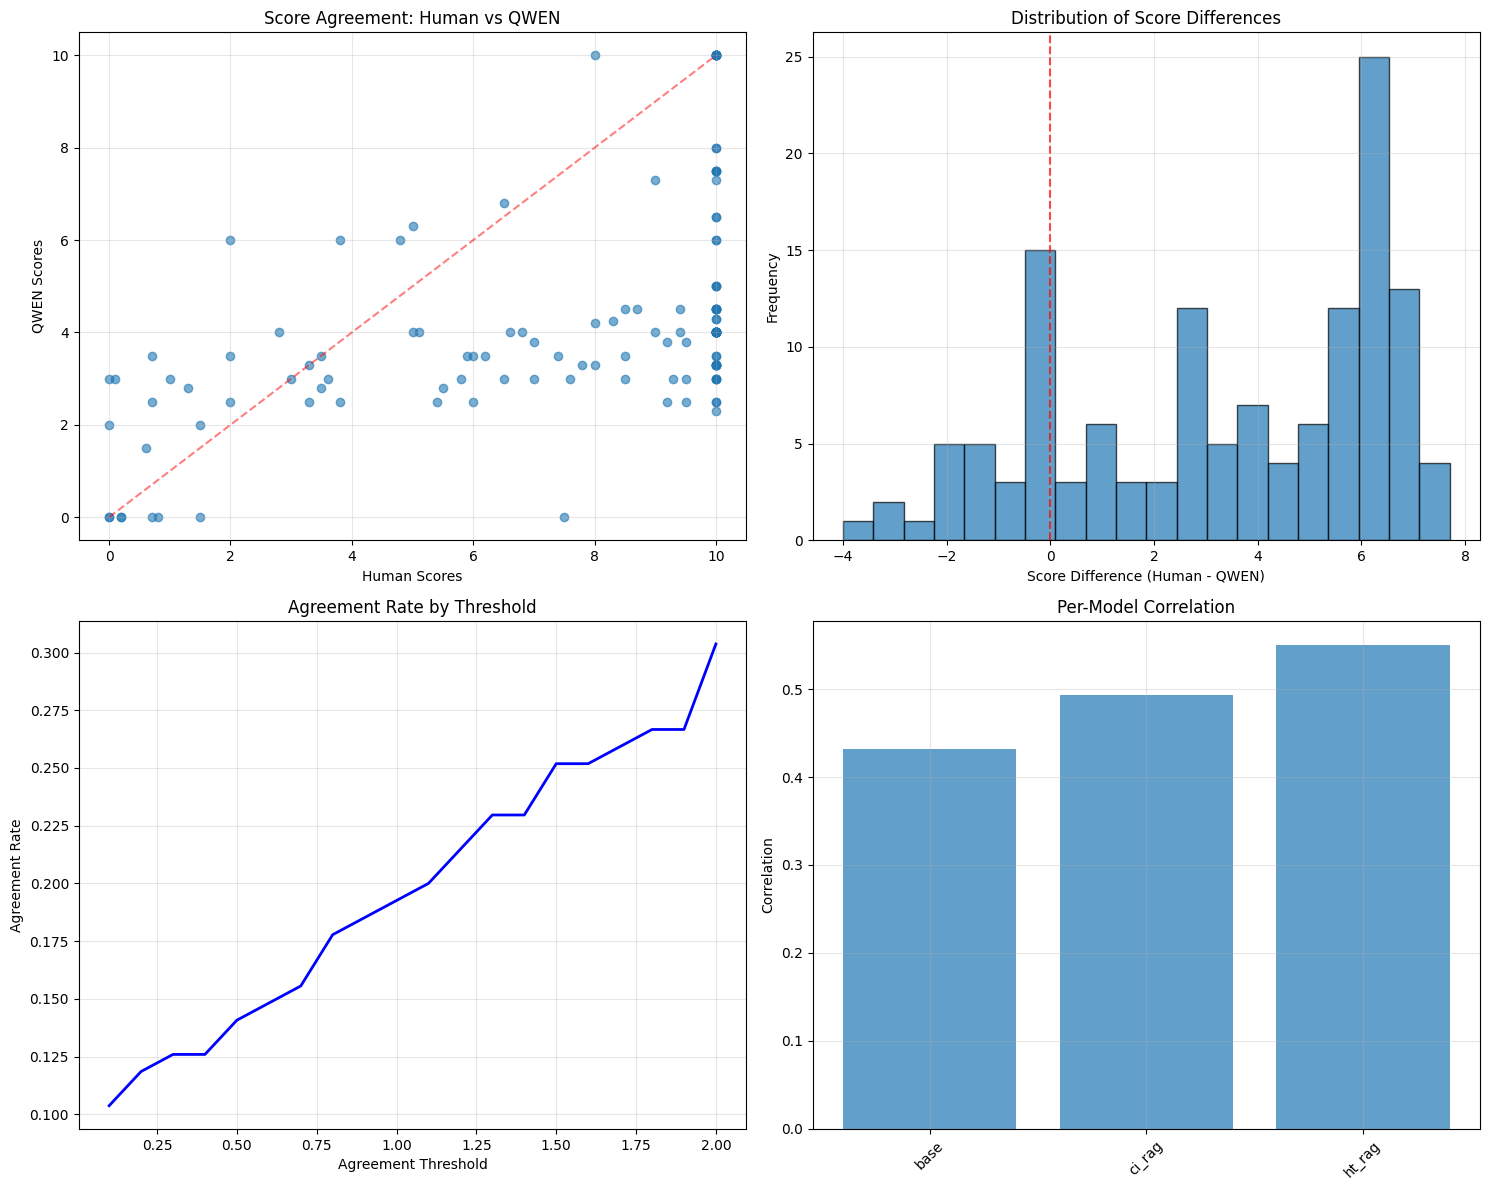


INTERPRETATION:
• Higher AC1/Kappa = Better agreement beyond chance
• AC1 typically more stable than Kappa for unbalanced data
• Binary agreement tests consistency in relative judgments
• Continuous agreement shows absolute score similarity
• Values > 0.6 = good agreement, > 0.8 = excellent


In [ ]:
def gwet_ac1_binary(y1, y2):
    y1 = np.asarray(y1); y2 = np.asarray(y2)
    mask = np.isfinite(y1) & np.isfinite(y2)
    y1 = y1[mask].astype(int); y2 = y2[mask].astype(int)
    if len(y1)==0: return np.nan
    Po = (y1==y2).mean()
    p1 = y1.mean(); p2 = y2.mean()
    e  = 0.5*(p1+p2)
    Pe = 2*e*(1-e)
    if Pe==1.0: return np.nan
    return (Po - Pe) / (1 - Pe)

def gwet_ac1_continuous(y1, y2, threshold=0.5):
    y1 = np.asarray(y1); y2 = np.asarray(y2)
    mask = np.isfinite(y1) & np.isfinite(y2)
    y1 = y1[mask]; y2 = y2[mask]
    if len(y1)==0: return np.nan
    
    Po = (np.abs(y1 - y2) <= threshold).mean()

    range_scores = max(y1.max(), y2.max()) - min(y1.min(), y2.min())
    if range_scores == 0:
        return 1.0  # Perfect agreement if no variation
    
    Pe = (2 * threshold) / range_scores if range_scores > 2 * threshold else 1.0
    Pe = min(Pe, 1.0)  # Cap at 1.0
    
    if Pe == 1.0: return np.nan
    return (Po - Pe) / (1 - Pe)
try:
    from sklearn.metrics import cohen_kappa_score
    HAS_SK = True
except ImportError:
    HAS_SK = False
    print("sklearn not availabl")

print("="*60)
print("INTER-JUDGE AGREEMENT ANALYSIS")
print("="*60)

human_data = df[df['judge'] == 'human'].set_index(['question_id', 'model'])
qwen_data = df[df['judge'] == 'qwen7b'].set_index(['question_id', 'model'])

common_idx = human_data.index.intersection(qwen_data.index)
print(f"Common question-model pairs: {len(common_idx)}")

if len(common_idx) > 0:
    human_scores = human_data.loc[common_idx, 'score_final'].values
    qwen_scores = qwen_data.loc[common_idx, 'score_final'].values
    
    print(f"\nScore comparison summary:")
    print(f"Human scores - Mean: {human_scores.mean():.3f}, Std: {human_scores.std():.3f}")
    print(f"QWEN scores - Mean: {qwen_scores.mean():.3f}, Std: {qwen_scores.std():.3f}")
    print(f"Correlation: {np.corrcoef(human_scores, qwen_scores)[0,1]:.3f}")
    
    # Method 1: Convert to binary decisions (above/below median)
    print(f"\n1. BINARY AGREEMENT (Above/Below Median):")
    print("-" * 40)
    
    # Use overall median across both judges
    overall_median = np.median(np.concatenate([human_scores, qwen_scores]))
    human_binary = (human_scores > overall_median).astype(int)
    qwen_binary = (qwen_scores > overall_median).astype(int)
    
    agreement_rate = (human_binary == qwen_binary).mean()
    print(f"Raw agreement rate: {agreement_rate:.3f}")
    
    # Gwet's AC1 for binary
    ac1_binary = gwet_ac1_binary(human_binary, qwen_binary)
    print(f"Gwet AC1 (binary): {ac1_binary:.3f}")
    
    # Cohen's kappa if available
    if HAS_SK:
        try:
            kappa_binary = cohen_kappa_score(human_binary, qwen_binary)
            print(f"Cohen's kappa (binary): {kappa_binary:.3f}")
        except Exception as e:
            print(f"Cohen's kappa error: {e}")
    
    # Method 2: Convert to ordinal categories (quintiles)
    print(f"\n2. ORDINAL AGREEMENT (Quintiles):")
    print("-" * 40)
    
    # Create quintile categories
    all_scores = np.concatenate([human_scores, qwen_scores])
    quintiles = np.percentile(all_scores, [20, 40, 60, 80])
    
    def score_to_quintile(scores):
        return np.digitize(scores, quintiles)
    
    human_quintiles = score_to_quintile(human_scores)
    qwen_quintiles = score_to_quintile(qwen_scores)
    
    quintile_agreement = (human_quintiles == qwen_quintiles).mean()
    print(f"Quintile agreement rate: {quintile_agreement:.3f}")
    
    # Gwet's AC1 for ordinal (treating as binary for each category)
    ac1_quintiles = gwet_ac1_binary(human_quintiles, qwen_quintiles)
    print(f"Gwet AC1 (quintiles): {ac1_quintiles:.3f}")
    
    if HAS_SK:
        try:
            kappa_quintiles = cohen_kappa_score(human_quintiles, qwen_quintiles)
            print(f"Cohen's kappa (quintiles): {kappa_quintiles:.3f}")
        except Exception as e:
            print(f"Cohen's kappa error: {e}")
    
    # Method 3: Continuous agreement with different thresholds
    print(f"\n3. CONTINUOUS AGREEMENT (Different Thresholds):")
    print("-" * 40)
    
    thresholds = [0.25, 0.5, 0.75, 1.0, 1.5]
    for threshold in thresholds:
        ac1_cont = gwet_ac1_continuous(human_scores, qwen_scores, threshold)
        agreement_rate = (np.abs(human_scores - qwen_scores) <= threshold).mean()
        print(f"Threshold ±{threshold}: Agreement={agreement_rate:.3f}, AC1={ac1_cont:.3f}")
    
    # Method 4: Per-model agreement analysis
    print(f"\n4. PER-MODEL AGREEMENT:")
    print("-" * 40)
    
    model_agreements = []
    for model in df['model'].unique():
        if pd.isna(model):
            continue
            
        model_pairs = [(qid, model) for qid, m in common_idx if m == model]
        if len(model_pairs) < 5:  # Need minimum samples
            continue
            
        h_scores = human_data.loc[model_pairs, 'score_final'].values
        q_scores = qwen_data.loc[model_pairs, 'score_final'].values
        
        correlation = np.corrcoef(h_scores, q_scores)[0,1] if len(h_scores) > 1 else np.nan
        mae = np.mean(np.abs(h_scores - q_scores))
        
        # Binary agreement for this model
        model_median = np.median(np.concatenate([h_scores, q_scores]))
        h_binary = (h_scores > model_median).astype(int)
        q_binary = (q_scores > model_median).astype(int)
        binary_agree = (h_binary == q_binary).mean()
        
        model_agreements.append({
            'model': model,
            'n_pairs': len(model_pairs),
            'correlation': correlation,
            'mae': mae,
            'binary_agreement': binary_agree
        })
    
    if model_agreements:
        agreement_df = pd.DataFrame(model_agreements)
        print("Per-model agreement summary:")
        print(agreement_df.round(3))
    
    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Scatter plot of scores
    axes[0,0].scatter(human_scores, qwen_scores, alpha=0.6)
    axes[0,0].plot([min(human_scores.min(), qwen_scores.min()), 
                    max(human_scores.max(), qwen_scores.max())], 
                   [min(human_scores.min(), qwen_scores.min()), 
                    max(human_scores.max(), qwen_scores.max())], 
                   'r--', alpha=0.5)
    axes[0,0].set_xlabel('Human Scores')
    axes[0,0].set_ylabel('QWEN Scores')
    axes[0,0].set_title('Score Agreement: Human vs QWEN')
    axes[0,0].grid(True, alpha=0.3)
    
    # Difference distribution
    differences = human_scores - qwen_scores
    axes[0,1].hist(differences, bins=20, alpha=0.7, edgecolor='black')
    axes[0,1].axvline(0, color='red', linestyle='--', alpha=0.7)
    axes[0,1].set_xlabel('Score Difference (Human - QWEN)')
    axes[0,1].set_ylabel('Frequency')
    axes[0,1].set_title('Distribution of Score Differences')
    axes[0,1].grid(True, alpha=0.3)
    
    # Agreement by threshold
    thresholds_plot = np.arange(0.1, 2.1, 0.1)
    agreement_rates = [(np.abs(differences) <= t).mean() for t in thresholds_plot]
    axes[1,0].plot(thresholds_plot, agreement_rates, 'b-', linewidth=2)
    axes[1,0].set_xlabel('Agreement Threshold')
    axes[1,0].set_ylabel('Agreement Rate')
    axes[1,0].set_title('Agreement Rate by Threshold')
    axes[1,0].grid(True, alpha=0.3)
    
    # Per-model correlation if we have the data
    if model_agreements:
        models = [m['model'] for m in model_agreements]
        correlations = [m['correlation'] for m in model_agreements]
        x_pos = range(len(models))
        axes[1,1].bar(x_pos, correlations, alpha=0.7)
        axes[1,1].set_xticks(x_pos)
        axes[1,1].set_xticklabels(models, rotation=45)
        axes[1,1].set_ylabel('Correlation')
        axes[1,1].set_title('Per-Model Correlation')
        axes[1,1].grid(True, alpha=0.3)
    else:
        axes[1,1].text(0.5, 0.5, 'Insufficient data\nfor per-model analysis', 
                       ha='center', va='center', transform=axes[1,1].transAxes)
        axes[1,1].set_title('Per-Model Analysis')
    
    plt.tight_layout()
    plt.show()
    
else:
    print("No common question-model pairs found between human and QWEN judges!")

print(f"\n" + "="*60)
print("INTERPRETATION:")
print("• Higher AC1/Kappa = Better agreement beyond chance")
print("• AC1 typically more stable than Kappa for unbalanced data")
print("• Binary agreement tests consistency in relative judgments")
print("• Continuous agreement shows absolute score similarity")
print("• Values > 0.6 = good agreement, > 0.8 = excellent")
print("="*60)

In [105]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import warnings

# Check for sklearn availability
try:
    from sklearn.metrics import cohen_kappa_score
    HAS_SK = True
except ImportError:
    HAS_SK = False
    print("sklearn not available - Cohen's kappa will be skipped")

def gwet_ac1(y1, y2):
    """Gwet's AC1 for categorical data"""
    y1 = np.asarray(y1); y2 = np.asarray(y2)
    mask = np.isfinite(y1) & np.isfinite(y2)
    y1 = y1[mask].astype(int); y2 = y2[mask].astype(int)
    if len(y1) == 0: 
        return np.nan
    
    # Observed agreement
    Po = (y1 == y2).mean()
    
    # Expected agreement by chance (Gwet's approach)
    categories = np.unique(np.concatenate([y1, y2]))
    k = len(categories)
    
    if k <= 1:
        return 1.0 if Po == 1.0 else np.nan
    
    # Marginal probabilities
    pi_vals = []
    for cat in categories:
        p1 = (y1 == cat).mean()
        p2 = (y2 == cat).mean()
        pi_vals.append(0.5 * (p1 + p2))
    
    # Gwet's chance agreement
    Pe = sum(pi * (1 - pi) for pi in pi_vals) / (k - 1) if k > 1 else 0
    Pe = min(Pe, 1.0)
    
    if Pe >= 1.0:
        return np.nan
    
    return (Po - Pe) / (1 - Pe)

def create_decisions(scores_a, scores_b, epsilon=0.5):
    """Convert score differences to win/tie/loss decisions"""
    diff = scores_a - scores_b
    decisions = np.zeros(len(diff), dtype=int)
    decisions[diff > epsilon] = 2    # win
    decisions[np.abs(diff) <= epsilon] = 1    # tie  
    decisions[diff < -epsilon] = 0    # loss
    return decisions

def bootstrap_agreement(decisions_a, decisions_b, n_bootstrap=1000, alpha=0.05):
    """Bootstrap confidence intervals for agreement metrics"""
    n = len(decisions_a)
    if n == 0:
        return np.nan, np.nan, np.nan, np.nan
    
    rng = np.random.default_rng(42)
    
    # Original metrics
    ac1_orig = gwet_ac1(decisions_a, decisions_b)
    kappa_orig = cohen_kappa_score(decisions_a, decisions_b) if HAS_SK else np.nan
    
    # Bootstrap samples
    ac1_boots = []
    kappa_boots = []
    
    for _ in range(n_bootstrap):
        idx = rng.choice(n, size=n, replace=True)
        dec_a_boot = decisions_a[idx]
        dec_b_boot = decisions_b[idx]
        
        ac1_boot = gwet_ac1(dec_a_boot, dec_b_boot)
        if not np.isnan(ac1_boot):
            ac1_boots.append(ac1_boot)
        
        if HAS_SK:
            try:
                kappa_boot = cohen_kappa_score(dec_a_boot, dec_b_boot)
                if not np.isnan(kappa_boot):
                    kappa_boots.append(kappa_boot)
            except:
                pass
    
    # Calculate confidence intervals
    if len(ac1_boots) > 0:
        ac1_ci = np.percentile(ac1_boots, [100*alpha/2, 100*(1-alpha/2)])
    else:
        ac1_ci = [np.nan, np.nan]
    
    if len(kappa_boots) > 0:
        kappa_ci = np.percentile(kappa_boots, [100*alpha/2, 100*(1-alpha/2)])
    else:
        kappa_ci = [np.nan, np.nan]
    
    return ac1_orig, ac1_ci, kappa_orig, kappa_ci

def icc_absolute_single(scores_matrix):
    """
    ICC(A,1) - Two-way random, absolute agreement, single rater
    scores_matrix: items × raters matrix
    """
    scores_matrix = np.asarray(scores_matrix)
    if scores_matrix.size == 0:
        return np.nan
    
    n_items, n_raters = scores_matrix.shape
    if n_items < 2 or n_raters < 2:
        return np.nan
    
    # Remove rows with any NaN
    valid_rows = ~np.isnan(scores_matrix).any(axis=1)
    if valid_rows.sum() < 2:
        return np.nan
    
    scores_clean = scores_matrix[valid_rows]
    n_items = scores_clean.shape[0]
    
    # Calculate means
    grand_mean = np.mean(scores_clean)
    item_means = np.mean(scores_clean, axis=1)
    rater_means = np.mean(scores_clean, axis=0)
    
    # Sum of squares
    SST = np.sum((scores_clean - grand_mean) ** 2)
    SSB = n_raters * np.sum((item_means - grand_mean) ** 2)  # Between items
    SSW = np.sum((scores_clean - item_means[:, np.newaxis]) ** 2)  # Within items
    SSE = SSW - (n_items * np.sum((rater_means - grand_mean) ** 2))  # Error
    
    # Mean squares
    MSB = SSB / (n_items - 1) if n_items > 1 else 0
    MSE = SSE / ((n_items - 1) * (n_raters - 1)) if (n_items > 1 and n_raters > 1) else 0
    MSW = SSW / (n_items * (n_raters - 1)) if n_raters > 1 else 0
    
    # ICC(A,1)
    if MSW == 0:
        return 1.0 if MSB > 0 else np.nan
    
    icc = (MSB - MSW) / (MSB + (n_raters - 1) * MSW)
    return max(0, icc)  # ICC can't be negative for absolute agreement

def bootstrap_icc(scores_matrix, n_bootstrap=1000, alpha=0.05):
    """Bootstrap confidence intervals for ICC"""
    scores_matrix = np.asarray(scores_matrix)
    valid_rows = ~np.isnan(scores_matrix).any(axis=1)
    
    if valid_rows.sum() < 2:
        return np.nan, [np.nan, np.nan]
    
    scores_clean = scores_matrix[valid_rows]
    n_items = scores_clean.shape[0]
    
    # Original ICC
    icc_orig = icc_absolute_single(scores_clean)
    
    # Bootstrap
    rng = np.random.default_rng(42)
    icc_boots = []
    
    for _ in range(n_bootstrap):
        # Resample items (rows)
        idx = rng.choice(n_items, size=n_items, replace=True)
        scores_boot = scores_clean[idx]
        
        icc_boot = icc_absolute_single(scores_boot)
        if not np.isnan(icc_boot):
            icc_boots.append(icc_boot)
    
    # Confidence interval
    if len(icc_boots) > 0:
        icc_ci = np.percentile(icc_boots, [100*alpha/2, 100*(1-alpha/2)])
    else:
        icc_ci = [np.nan, np.nan]
    
    return icc_orig, icc_ci

print("="*80)
print("AGREEMENT ANALYSIS: GWET'S AC1 & COHEN'S KAPPA ON WIN/TIE/LOSS DECISIONS")
print("="*80)

# 1. Overall Agreement Analysis
print("\n1. OVERALL AGREEMENT ANALYSIS")
print("-" * 50)

EPSILON = 0.5
models = sorted(df['model'].dropna().unique().tolist())
overall_results = []

for i, model_a in enumerate(models):
    for j, model_b in enumerate(models):
        if i >= j:  # Only upper triangle to avoid duplicates
            continue
            
        print(f"\nAnalyzing: {model_a} vs {model_b}")
        
        # Get data for both judges
        for judge_name in ['human', 'qwen7b']:
            sub = df[df['judge'] == judge_name]
            scores_a = sub[sub['model'] == model_a].set_index('question_id')['score_final']
            scores_b = sub[sub['model'] == model_b].set_index('question_id')['score_final']
            
            # Find common questions
            common_idx = scores_a.index.intersection(scores_b.index)
            
            if len(common_idx) < 5:  # Minimum sample size
                print(f"  {judge_name}: Insufficient data (n={len(common_idx)})")
                continue
                
            scores_a_vec = scores_a.loc[common_idx].values
            scores_b_vec = scores_b.loc[common_idx].values
            
            # Create win/tie/loss decisions
            decisions_a = create_decisions(scores_a_vec, scores_b_vec, EPSILON)
            decisions_b = create_decisions(scores_b_vec, scores_a_vec, EPSILON)
            
            # Calculate agreement with bootstrap CIs
            ac1, ac1_ci, kappa, kappa_ci = bootstrap_agreement(decisions_a, decisions_b)
            
            # Count decisions
            wins_a = (decisions_a == 2).sum()
            ties = (decisions_a == 1).sum()
            wins_b = (decisions_a == 0).sum()
            
            print(f"  {judge_name} (n={len(common_idx)}):")
            print(f"    Decisions - {model_a} wins: {wins_a}, Ties: {ties}, {model_b} wins: {wins_b}")
            print(f"    Gwet AC1: {ac1:.3f} [95% CI: {ac1_ci[0]:.3f}, {ac1_ci[1]:.3f}]")
            if HAS_SK and not np.isnan(kappa):
                print(f"    Cohen κ: {kappa:.3f} [95% CI: {kappa_ci[0]:.3f}, {kappa_ci[1]:.3f}]")
            
            overall_results.append({
                'model_pair': f"{model_a} vs {model_b}",
                'judge': judge_name,
                'n_comparisons': len(common_idx),
                'wins_a': wins_a,
                'ties': ties,
                'wins_b': wins_b,
                'gwet_ac1': ac1,
                'ac1_ci_lower': ac1_ci[0],
                'ac1_ci_upper': ac1_ci[1],
                'cohen_kappa': kappa,
                'kappa_ci_lower': kappa_ci[0],
                'kappa_ci_upper': kappa_ci[1]
            })

# 2. By-Category Agreement Analysis  
print("\n\n2. BY-CATEGORY AGREEMENT ANALYSIS")
print("-" * 50)

category_results = []

for category in df['category'].unique():
    print(f"\nCategory: {category}")
    
    for i, model_a in enumerate(models):
        for j, model_b in enumerate(models):
            if i >= j:
                continue
                
            for judge_name in ['human', 'qwen7b']:
                sub = df[(df['judge'] == judge_name) & (df['category'] == category)]
                scores_a = sub[sub['model'] == model_a].set_index('question_id')['score_final']
                scores_b = sub[sub['model'] == model_b].set_index('question_id')['score_final']
                
                common_idx = scores_a.index.intersection(scores_b.index)
                
                if len(common_idx) < 3:  # Lower threshold for categories
                    continue
                    
                scores_a_vec = scores_a.loc[common_idx].values
                scores_b_vec = scores_b.loc[common_idx].values
                
                decisions_a = create_decisions(scores_a_vec, scores_b_vec, EPSILON)
                decisions_b = create_decisions(scores_b_vec, scores_a_vec, EPSILON)
                
                ac1, ac1_ci, kappa, kappa_ci = bootstrap_agreement(decisions_a, decisions_b)
                
                wins_a = (decisions_a == 2).sum()
                ties = (decisions_a == 1).sum()
                wins_b = (decisions_a == 0).sum()
                
                print(f"  {model_a} vs {model_b} ({judge_name}, n={len(common_idx)}):")
                print(f"    AC1: {ac1:.3f} [{ac1_ci[0]:.3f}, {ac1_ci[1]:.3f}]", end="")
                if HAS_SK and not np.isnan(kappa):
                    print(f", κ: {kappa:.3f} [{kappa_ci[0]:.3f}, {kappa_ci[1]:.3f}]")
                else:
                    print()
                
                category_results.append({
                    'category': category,
                    'model_pair': f"{model_a} vs {model_b}",
                    'judge': judge_name,
                    'n_comparisons': len(common_idx),
                    'wins_a': wins_a,
                    'ties': ties,
                    'wins_b': wins_b,
                    'gwet_ac1': ac1,
                    'ac1_ci_lower': ac1_ci[0],
                    'ac1_ci_upper': ac1_ci[1],
                    'cohen_kappa': kappa,
                    'kappa_ci_lower': kappa_ci[0],
                    'kappa_ci_upper': kappa_ci[1]
                })

print("\n" + "="*80)
print("ICC(A,1) ANALYSIS: INTER-RATER RELIABILITY ON SCORES")
print("="*80)

# 3. ICC Analysis
print("\n3. ICC(A,1) FOR EACH MODEL")
print("-" * 50)

icc_results = []

for model in models:
    print(f"\nModel: {model}")
    
    # Get scores from both judges for this model
    human_scores = df[(df['judge'] == 'human') & (df['model'] == model)].set_index('question_id')['score_final']
    qwen_scores = df[(df['judge'] == 'qwen7b') & (df['model'] == model)].set_index('question_id')['score_final']
    
    # Find common questions
    common_idx = human_scores.index.intersection(qwen_scores.index)
    
    if len(common_idx) < 5:
        print(f"  Insufficient data (n={len(common_idx)})")
        continue
    
    # Create scores matrix: items × raters
    scores_matrix = np.column_stack([
        human_scores.loc[common_idx].values,
        qwen_scores.loc[common_idx].values
    ])
    
    # Calculate ICC with bootstrap CI
    icc_val, icc_ci = bootstrap_icc(scores_matrix)
    
    print(f"  ICC(A,1): {icc_val:.3f} [95% CI: {icc_ci[0]:.3f}, {icc_ci[1]:.3f}] (n={len(common_idx)})")
    
    # Overall ICC by category
    for category in df['category'].unique():
        cat_human = df[(df['judge'] == 'human') & (df['model'] == model) & (df['category'] == category)].set_index('question_id')['score_final']
        cat_qwen = df[(df['judge'] == 'qwen7b') & (df['model'] == model) & (df['category'] == category)].set_index('question_id')['score_final']
        
        cat_common = cat_human.index.intersection(cat_qwen.index)
        
        if len(cat_common) < 3:
            continue
            
        cat_matrix = np.column_stack([
            cat_human.loc[cat_common].values,
            cat_qwen.loc[cat_common].values
        ])
        
        cat_icc, cat_icc_ci = bootstrap_icc(cat_matrix)
        
        print(f"    {category}: ICC(A,1) = {cat_icc:.3f} [{cat_icc_ci[0]:.3f}, {cat_icc_ci[1]:.3f}] (n={len(cat_common)})")
        
        icc_results.append({
            'model': model,
            'category': category,
            'n_items': len(cat_common),
            'icc_a1': cat_icc,
            'icc_ci_lower': cat_icc_ci[0],
            'icc_ci_upper': cat_icc_ci[1]
        })
    
    # Overall for this model
    icc_results.append({
        'model': model,
        'category': 'Overall',
        'n_items': len(common_idx),
        'icc_a1': icc_val,
        'icc_ci_lower': icc_ci[0],
        'icc_ci_upper': icc_ci[1]
    })

# Create summary tables
if overall_results:
    overall_df = pd.DataFrame(overall_results)
    print(f"\n\nOVERALL AGREEMENT SUMMARY:")
    print(overall_df[['model_pair', 'judge', 'n_comparisons', 'gwet_ac1', 'cohen_kappa']].round(3))

if category_results:
    category_df = pd.DataFrame(category_results)
    print(f"\n\nCATEGORY AGREEMENT SUMMARY:")
    print(category_df[['category', 'model_pair', 'judge', 'gwet_ac1', 'cohen_kappa']].round(3))

if icc_results:
    icc_df = pd.DataFrame(icc_results)
    print(f"\n\nICC SUMMARY:")
    print(icc_df[['model', 'category', 'n_items', 'icc_a1']].round(3))

print(f"\n" + "="*80)
print("INTERPRETATION:")
print("• Gwet's AC1 & Cohen's κ: Agreement on win/tie/loss decisions")
print("• ICC(A,1): Absolute agreement between raters on raw scores")
print("• Values > 0.60 = good agreement, > 0.80 = excellent")
print("• Bootstrap 95% CIs account for sampling uncertainty")
print("• Win/Tie/Loss uses ε-margin of", EPSILON)
print("="*80)

AGREEMENT ANALYSIS: GWET'S AC1 & COHEN'S KAPPA ON WIN/TIE/LOSS DECISIONS

1. OVERALL AGREEMENT ANALYSIS
--------------------------------------------------

Analyzing: base vs ci_rag
  human (n=45):
    Decisions - base wins: 16, Ties: 19, ci_rag wins: 10
    Gwet AC1: 0.141 [95% CI: -0.095, 0.368]
    Cohen κ: 0.129 [95% CI: -0.072, 0.272]
  qwen7b (n=45):
    Decisions - base wins: 9, Ties: 23, ci_rag wins: 13
    Gwet AC1: 0.292 [95% CI: 0.034, 0.520]
    Cohen κ: 0.216 [95% CI: 0.062, 0.334]

Analyzing: base vs ht_rag
  human (n=45):
    Decisions - base wins: 11, Ties: 21, ht_rag wins: 13
    Gwet AC1: 0.216 [95% CI: -0.033, 0.482]
    Cohen κ: 0.168 [95% CI: -0.000, 0.310]
  qwen7b (n=45):
    Decisions - base wins: 6, Ties: 23, ht_rag wins: 16
    Gwet AC1: 0.292 [95% CI: 0.069, 0.520]
    Cohen κ: 0.241 [95% CI: 0.107, 0.358]

Analyzing: ci_rag vs ht_rag
  human (n=45):
    Decisions - ci_rag wins: 10, Ties: 21, ht_rag wins: 14
    Gwet AC1: 0.216 [95% CI: -0.033, 0.482]
    Coh

/Users/jordanfernandes/Desktop/Dissertation workspace/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/Users/jordanfernandes/Desktop/Dissertation workspace/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:897: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/Users/jordanfernandes/Desktop/Dissertation workspace/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/Users/jordanfernandes/Desktop/Dissertation workspace/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py

  base vs ci_rag (human, n=6):
    AC1: 0.273 [-0.212, 0.805], κ: 0.217 [-0.304, 0.455]
  base vs ci_rag (qwen7b, n=6):
    AC1: 0.805 [0.273, 1.000], κ: 0.455 [0.333, 0.455]


/Users/jordanfernandes/Desktop/Dissertation workspace/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/Users/jordanfernandes/Desktop/Dissertation workspace/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:897: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/Users/jordanfernandes/Desktop/Dissertation workspace/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/Users/jordanfernandes/Desktop/Dissertation workspace/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py

  base vs ht_rag (human, n=6):
    AC1: 0.556 [-0.000, 1.000], κ: 0.333 [0.000, 0.455]
  base vs ht_rag (qwen7b, n=6):
    AC1: 0.556 [-0.000, 1.000], κ: 0.400 [0.250, 0.455]


/Users/jordanfernandes/Desktop/Dissertation workspace/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/Users/jordanfernandes/Desktop/Dissertation workspace/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:897: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/Users/jordanfernandes/Desktop/Dissertation workspace/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/Users/jordanfernandes/Desktop/Dissertation workspace/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py

  ci_rag vs ht_rag (human, n=6):
    AC1: 0.556 [-0.000, 1.000], κ: 0.333 [0.000, 0.455]
  ci_rag vs ht_rag (qwen7b, n=6):
    AC1: 0.556 [-0.000, 1.000], κ: 0.400 [0.250, 0.455]

Category: Interpretation (CI to Hypothesis)


/Users/jordanfernandes/Desktop/Dissertation workspace/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/Users/jordanfernandes/Desktop/Dissertation workspace/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:897: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/Users/jordanfernandes/Desktop/Dissertation workspace/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/Users/jordanfernandes/Desktop/Dissertation workspace/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py

  base vs ci_rag (human, n=9):
    AC1: 0.368 [-0.151, 0.876], κ: 0.280 [0.000, 0.471]
  base vs ci_rag (qwen7b, n=8):
    AC1: -0.116 [-1.000, 0.487], κ: -0.091 [-0.882, 0.333]


/Users/jordanfernandes/Desktop/Dissertation workspace/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/Users/jordanfernandes/Desktop/Dissertation workspace/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:897: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/Users/jordanfernandes/Desktop/Dissertation workspace/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/Users/jordanfernandes/Desktop/Dissertation workspace/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py

  base vs ht_rag (human, n=9):
    AC1: 0.178 [-0.263, 0.727], κ: 0.151 [-0.440, 0.438]
  base vs ht_rag (qwen7b, n=8):
    AC1: 0.064 [-0.251, 0.686], κ: 0.149 [-0.302, 0.385]


/Users/jordanfernandes/Desktop/Dissertation workspace/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/Users/jordanfernandes/Desktop/Dissertation workspace/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:897: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/Users/jordanfernandes/Desktop/Dissertation workspace/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/Users/jordanfernandes/Desktop/Dissertation workspace/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py

  ci_rag vs ht_rag (human, n=9):
    AC1: 0.368 [-0.151, 0.876], κ: 0.250 [-0.189, 0.471]


/Users/jordanfernandes/Desktop/Dissertation workspace/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/Users/jordanfernandes/Desktop/Dissertation workspace/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:897: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/Users/jordanfernandes/Desktop/Dissertation workspace/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/Users/jordanfernandes/Desktop/Dissertation workspace/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py

  ci_rag vs ht_rag (qwen7b, n=9):
    AC1: 0.368 [-0.151, 0.876], κ: 0.280 [-0.105, 0.471]

Category: Checking Conditions

Category: Conceptual Application

Category: Conceptual Errors


/Users/jordanfernandes/Desktop/Dissertation workspace/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/Users/jordanfernandes/Desktop/Dissertation workspace/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:897: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/Users/jordanfernandes/Desktop/Dissertation workspace/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/Users/jordanfernandes/Desktop/Dissertation workspace/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py

  base vs ci_rag (human, n=7):
    AC1: 0.396 [-0.235, 1.000], κ: 0.276 [-0.061, 0.462]
  base vs ci_rag (qwen7b, n=8):
    AC1: 0.064 [-0.270, 0.686], κ: 0.070 [-0.436, 0.386]


/Users/jordanfernandes/Desktop/Dissertation workspace/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/Users/jordanfernandes/Desktop/Dissertation workspace/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:897: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/Users/jordanfernandes/Desktop/Dissertation workspace/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/Users/jordanfernandes/Desktop/Dissertation workspace/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py

  base vs ht_rag (human, n=7):
    AC1: 0.632 [0.152, 1.000], κ: 0.364 [0.081, 0.462]
  base vs ht_rag (qwen7b, n=8):
    AC1: -0.251 [-1.000, 0.064], κ: -0.302 [-1.000, 0.200]


/Users/jordanfernandes/Desktop/Dissertation workspace/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/Users/jordanfernandes/Desktop/Dissertation workspace/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:897: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/Users/jordanfernandes/Desktop/Dissertation workspace/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/Users/jordanfernandes/Desktop/Dissertation workspace/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py

  ci_rag vs ht_rag (human, n=7):
    AC1: 0.632 [0.152, 1.000], κ: 0.417 [0.300, 0.462]


/Users/jordanfernandes/Desktop/Dissertation workspace/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/Users/jordanfernandes/Desktop/Dissertation workspace/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:897: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/Users/jordanfernandes/Desktop/Dissertation workspace/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/Users/jordanfernandes/Desktop/Dissertation workspace/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py

  ci_rag vs ht_rag (qwen7b, n=8):
    AC1: 0.273 [-0.251, 0.859], κ: 0.333 [0.111, 0.429]

Category: Full Test Procedure
  base vs ci_rag (human, n=4):
    AC1: -1.000 [-1.000, -1.000], κ: 0.000 [0.000, 0.000]


/Users/jordanfernandes/Desktop/Dissertation workspace/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/Users/jordanfernandes/Desktop/Dissertation workspace/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:897: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/Users/jordanfernandes/Desktop/Dissertation workspace/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/Users/jordanfernandes/Desktop/Dissertation workspace/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py

  base vs ci_rag (qwen7b, n=4):
    AC1: 0.686 [-0.116, 1.000], κ: 0.429 [0.200, 0.429]
  base vs ht_rag (human, n=4):
    AC1: -1.000 [-1.000, -1.000], κ: -1.000 [-1.000, 0.000]


/Users/jordanfernandes/Desktop/Dissertation workspace/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/Users/jordanfernandes/Desktop/Dissertation workspace/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:897: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/Users/jordanfernandes/Desktop/Dissertation workspace/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/Users/jordanfernandes/Desktop/Dissertation workspace/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py

  base vs ht_rag (qwen7b, n=4):
    AC1: 1.000 [1.000, 1.000]
  ci_rag vs ht_rag (human, n=4):
    AC1: -1.000 [-1.000, -1.000], κ: -0.600 [-1.000, 0.000]


/Users/jordanfernandes/Desktop/Dissertation workspace/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/Users/jordanfernandes/Desktop/Dissertation workspace/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:897: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/Users/jordanfernandes/Desktop/Dissertation workspace/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/Users/jordanfernandes/Desktop/Dissertation workspace/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py

  ci_rag vs ht_rag (qwen7b, n=4):
    AC1: 0.686 [-0.116, 1.000], κ: 0.429 [0.200, 0.429]

Category: Interpretation of confidence interval
  base vs ci_rag (human, n=3):
    AC1: -1.000 [-1.000, -1.000], κ: -0.800 [-0.800, 0.000]
  base vs ci_rag (qwen7b, n=3):
    AC1: -1.000 [-1.000, -1.000], κ: 0.000 [0.000, 0.000]


/Users/jordanfernandes/Desktop/Dissertation workspace/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/Users/jordanfernandes/Desktop/Dissertation workspace/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:897: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/Users/jordanfernandes/Desktop/Dissertation workspace/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/Users/jordanfernandes/Desktop/Dissertation workspace/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py

  base vs ht_rag (human, n=3):
    AC1: -0.000 [-1.000, 1.000], κ: 0.000 [-0.800, 0.400]
  base vs ht_rag (qwen7b, n=3):
    AC1: -1.000 [-1.000, -1.000], κ: 0.000 [0.000, 0.000]


/Users/jordanfernandes/Desktop/Dissertation workspace/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/Users/jordanfernandes/Desktop/Dissertation workspace/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:897: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/Users/jordanfernandes/Desktop/Dissertation workspace/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/Users/jordanfernandes/Desktop/Dissertation workspace/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py

  ci_rag vs ht_rag (human, n=3):
    AC1: -0.000 [-1.000, 1.000], κ: 0.000 [-0.800, 0.400]
  ci_rag vs ht_rag (qwen7b, n=3):
    AC1: 0.556 [-1.000, 1.000], κ: 0.400 [0.000, 0.400]

Category: Interpretation of p-value

Category: Practical vs. Statistical Significance

Category: Full Test Procedure (Reasoning)


/Users/jordanfernandes/Desktop/Dissertation workspace/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/Users/jordanfernandes/Desktop/Dissertation workspace/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:897: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/Users/jordanfernandes/Desktop/Dissertation workspace/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/Users/jordanfernandes/Desktop/Dissertation workspace/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py

  base vs ci_rag (human, n=6):
    AC1: -1.000 [-1.000, -1.000], κ: -1.000 [-1.000, 0.000]
  base vs ci_rag (qwen7b, n=6):
    AC1: 0.805 [0.273, 1.000], κ: 0.455 [0.333, 0.455]


/Users/jordanfernandes/Desktop/Dissertation workspace/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/Users/jordanfernandes/Desktop/Dissertation workspace/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:897: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/Users/jordanfernandes/Desktop/Dissertation workspace/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/Users/jordanfernandes/Desktop/Dissertation workspace/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py

  base vs ht_rag (human, n=6):
    AC1: -0.000 [-1.000, 0.805], κ: 0.077 [-0.800, 0.404]


/Users/jordanfernandes/Desktop/Dissertation workspace/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/Users/jordanfernandes/Desktop/Dissertation workspace/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:897: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/Users/jordanfernandes/Desktop/Dissertation workspace/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/Users/jordanfernandes/Desktop/Dissertation workspace/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py

  base vs ht_rag (qwen7b, n=6):
    AC1: 0.805 [0.273, 1.000], κ: 0.455 [0.333, 0.455]
  ci_rag vs ht_rag (human, n=6):
    AC1: -0.212 [-1.000, 0.273], κ: -0.304 [-1.000, 0.250]


/Users/jordanfernandes/Desktop/Dissertation workspace/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/Users/jordanfernandes/Desktop/Dissertation workspace/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:897: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/Users/jordanfernandes/Desktop/Dissertation workspace/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/Users/jordanfernandes/Desktop/Dissertation workspace/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py

  ci_rag vs ht_rag (qwen7b, n=6):
    AC1: 0.556 [-0.000, 1.000], κ: 0.333 [0.000, 0.455]

Category: Full Test Procedure (Two-sample)

Category: Experiment Design
  base vs ci_rag (human, n=3):
    AC1: 1.000 [1.000, 1.000]


/Users/jordanfernandes/Desktop/Dissertation workspace/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/Users/jordanfernandes/Desktop/Dissertation workspace/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:897: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/Users/jordanfernandes/Desktop/Dissertation workspace/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/Users/jordanfernandes/Desktop/Dissertation workspace/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py

  base vs ci_rag (qwen7b, n=3):
    AC1: -0.000 [-1.000, 1.000], κ: 0.000 [-0.800, 0.400]


/Users/jordanfernandes/Desktop/Dissertation workspace/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/Users/jordanfernandes/Desktop/Dissertation workspace/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:897: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/Users/jordanfernandes/Desktop/Dissertation workspace/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/Users/jordanfernandes/Desktop/Dissertation workspace/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py

  base vs ht_rag (human, n=3):
    AC1: 0.556 [-1.000, 1.000], κ: 0.400 [0.000, 0.400]
  base vs ht_rag (qwen7b, n=3):
    AC1: 0.556 [-1.000, 1.000], κ: 0.400 [0.000, 0.400]
  ci_rag vs ht_rag (human, n=3):
    AC1: 0.556 [-1.000, 1.000], κ: 0.400 [0.000, 0.400]


/Users/jordanfernandes/Desktop/Dissertation workspace/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/Users/jordanfernandes/Desktop/Dissertation workspace/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:897: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/Users/jordanfernandes/Desktop/Dissertation workspace/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/Users/jordanfernandes/Desktop/Dissertation workspace/.venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py

  ci_rag vs ht_rag (qwen7b, n=3):
    AC1: 0.556 [-1.000, 1.000], κ: 0.400 [0.000, 0.400]

Category: Interpretation (CI to Hypothesis

ICC(A,1) ANALYSIS: INTER-RATER RELIABILITY ON SCORES

3. ICC(A,1) FOR EACH MODEL
--------------------------------------------------

Model: base
  ICC(A,1): 0.000 [95% CI: 0.000, 0.040] (n=45)
    Hypothesis Formulation: ICC(A,1) = 0.000 [0.000, 0.200] (n=6)
    Interpretation (CI to Hypothesis): ICC(A,1) = 0.000 [0.000, 0.109] (n=8)
    Conceptual Errors: ICC(A,1) = 0.065 [0.000, 0.477] (n=7)
    Full Test Procedure: ICC(A,1) = 0.000 [0.000, 0.143] (n=4)
    Interpretation of confidence interval: ICC(A,1) = 0.000 [0.000, 0.000] (n=3)
    Full Test Procedure (Reasoning): ICC(A,1) = 0.000 [0.000, 0.000] (n=6)
    Experiment Design: ICC(A,1) = 0.000 [0.000, 0.000] (n=3)

Model: ci_rag
  ICC(A,1): 0.086 [95% CI: 0.000, 0.341] (n=45)
    Hypothesis Formulation: ICC(A,1) = 0.000 [0.000, 0.000] (n=6)
    Interpretation (CI to Hypothesis): ICC(A,1) = 0.303 [0.

Creating Forest Plots...


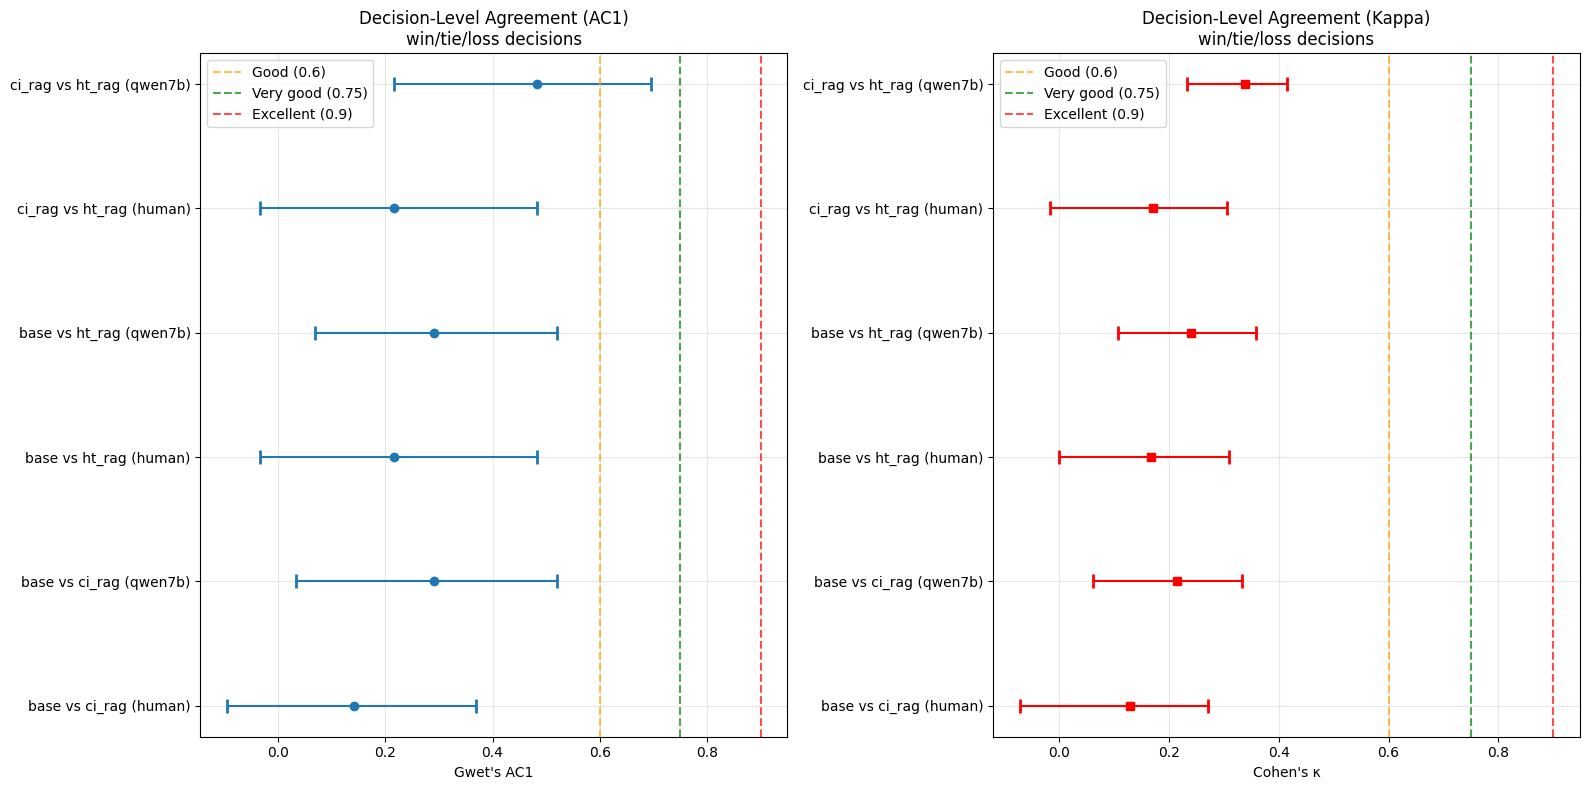

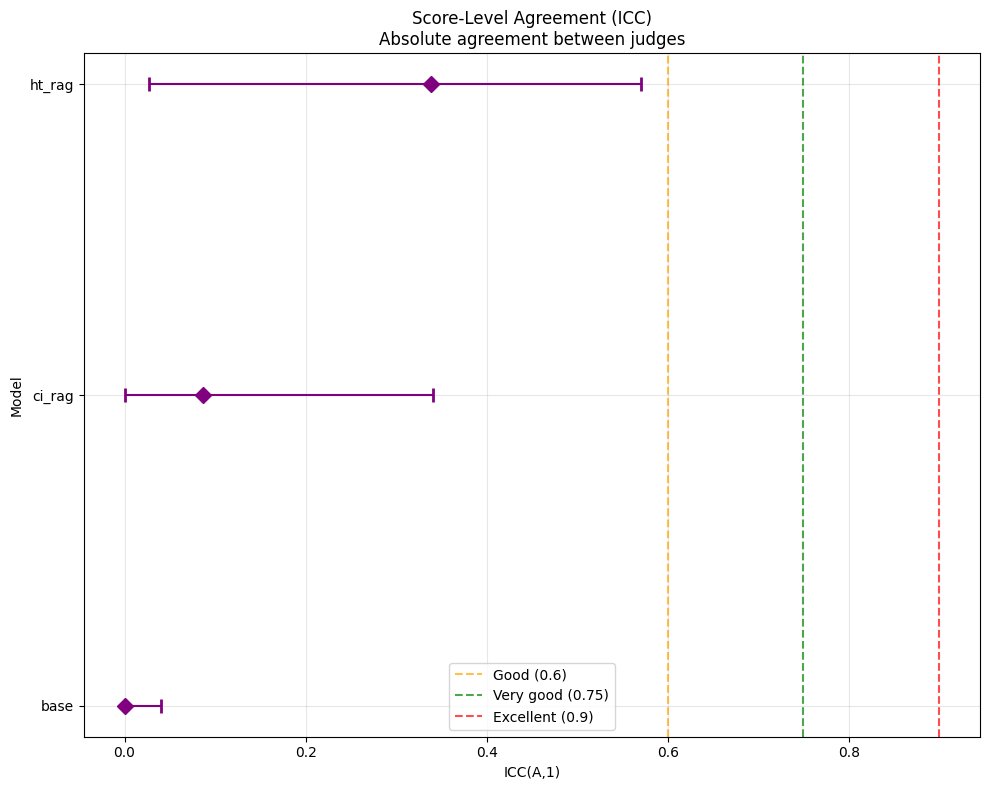


Creating Category Heatmaps...


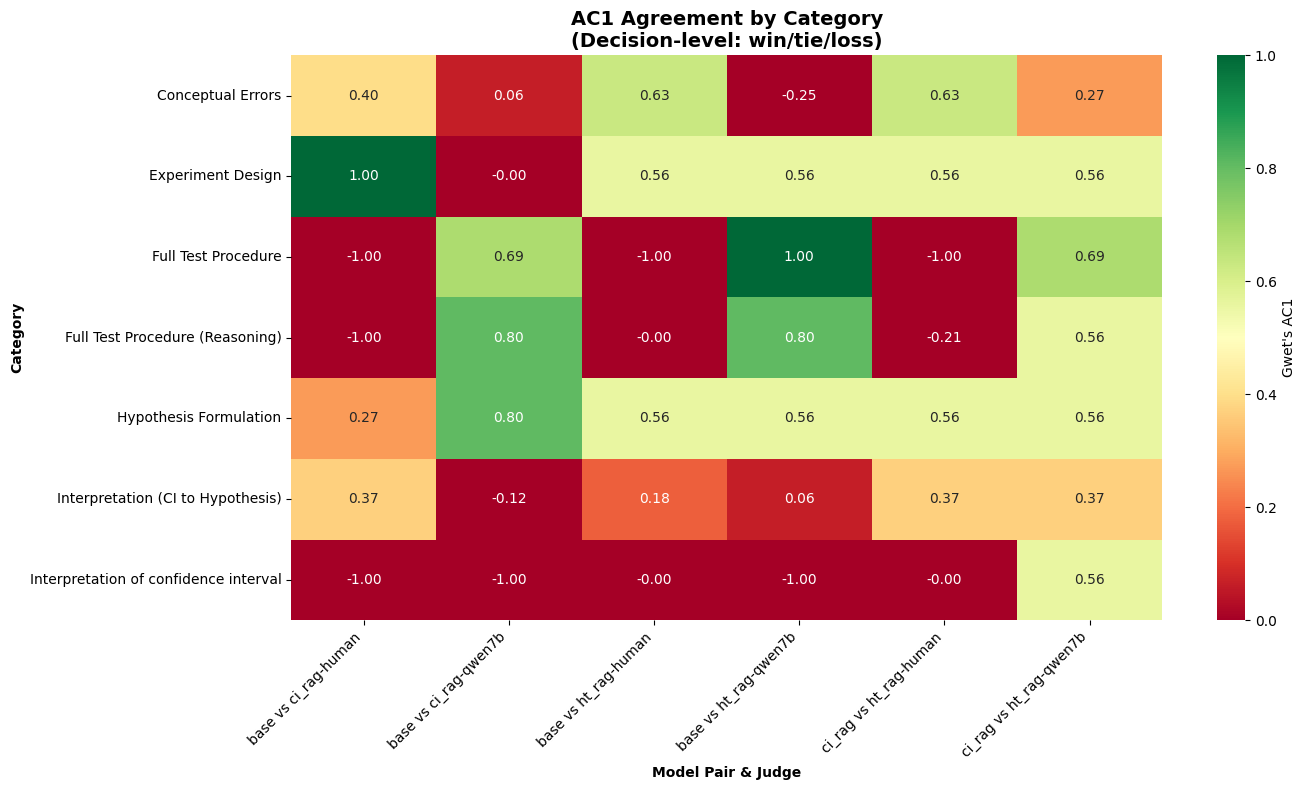

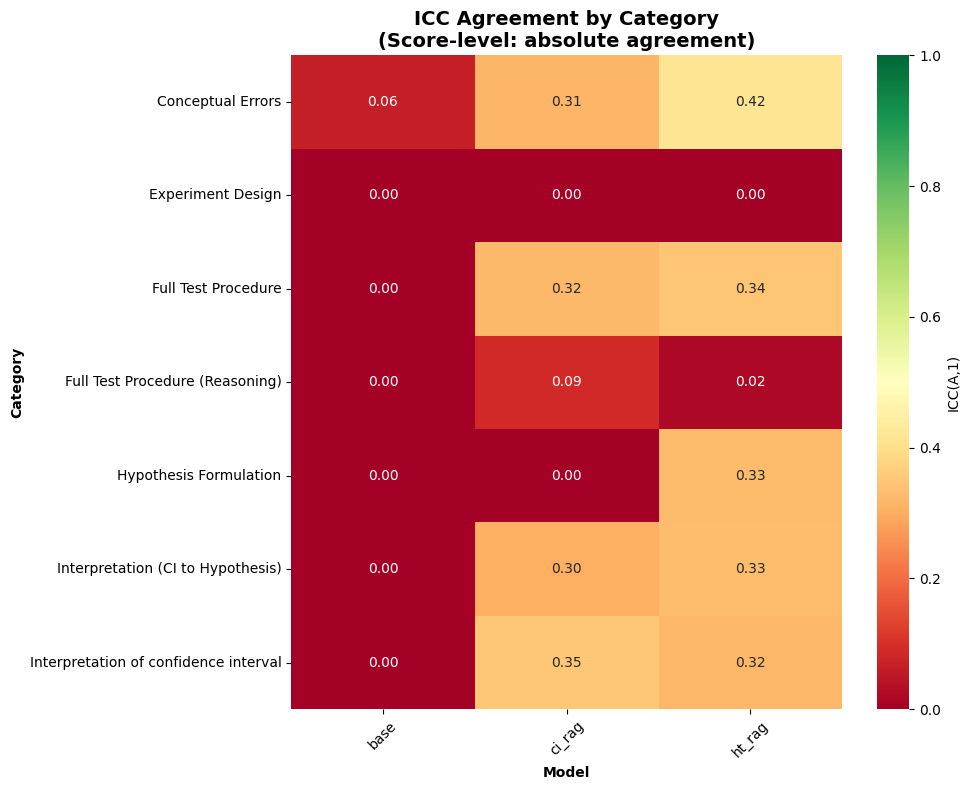


Creating Combined Summary...


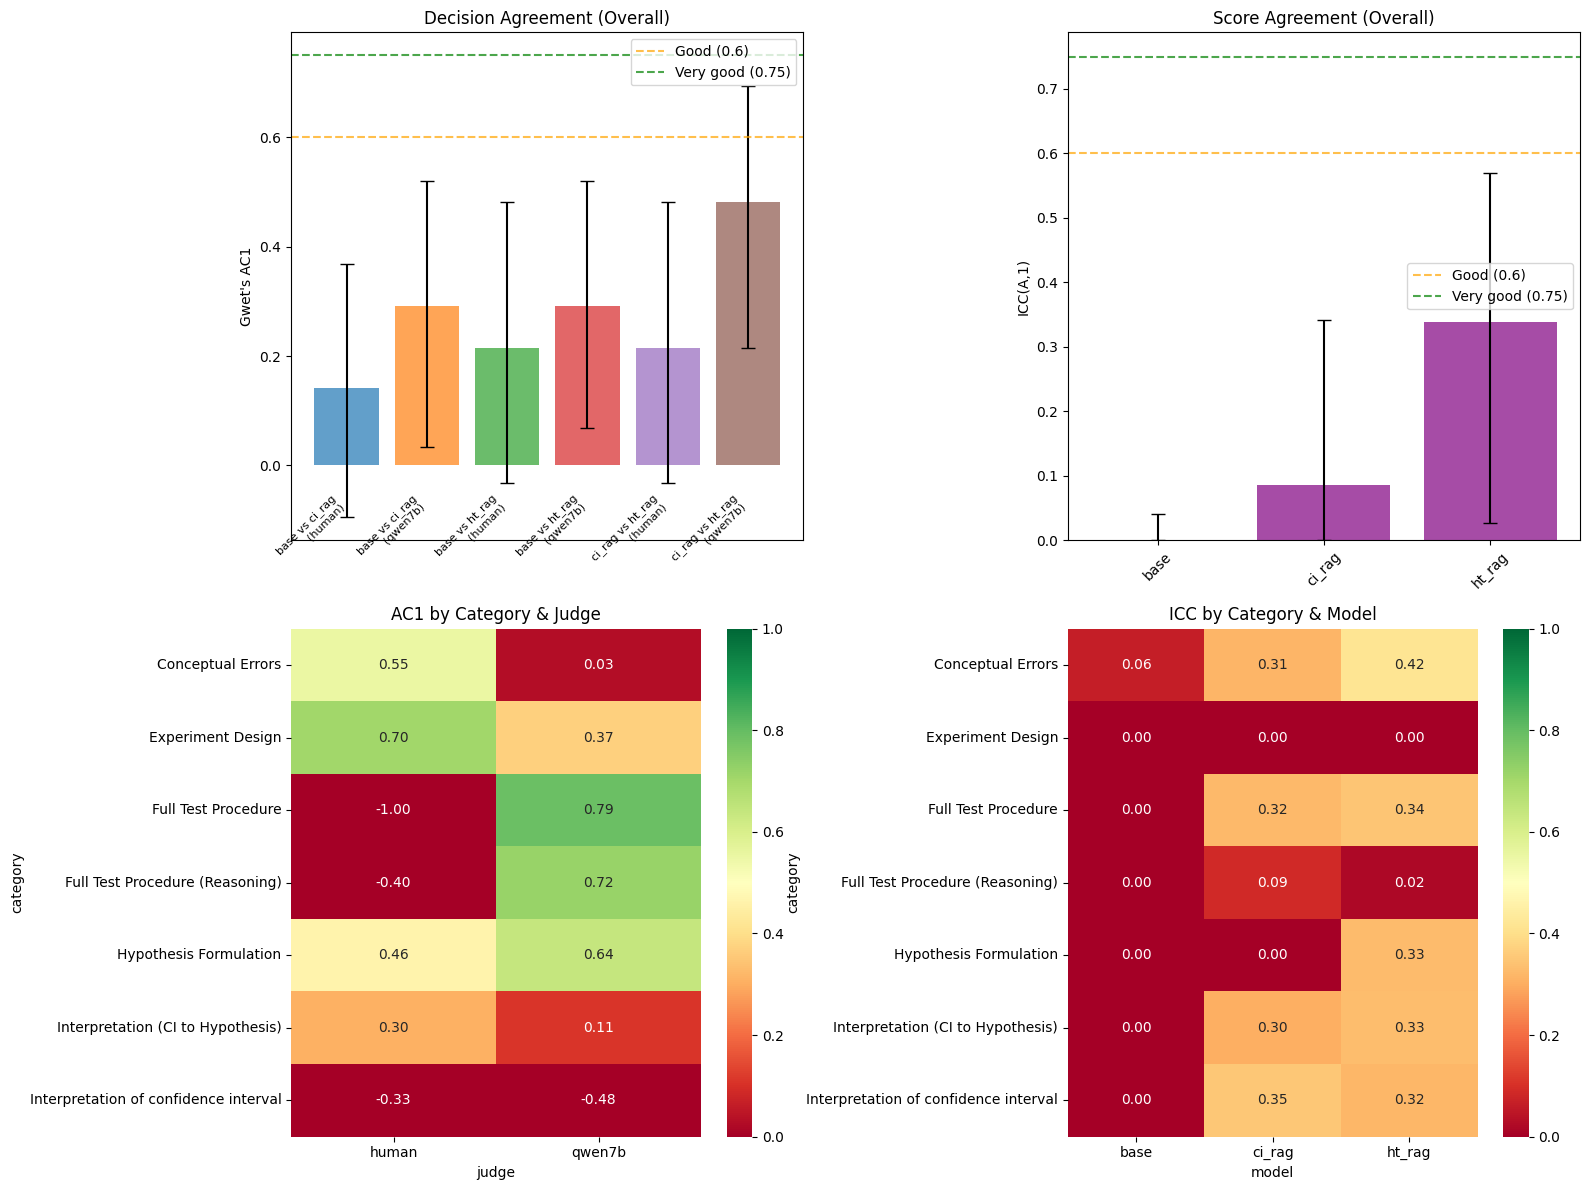


VISUALIZATION INTERPRETATION:
• Forest plots show agreement magnitude + uncertainty
• Error bars = 95% bootstrap confidence intervals
• Dashed lines = agreement quality thresholds
• Heatmaps reveal category-specific reliability patterns
• Green = good agreement, Red = poor agreement


In [106]:
# Forest plots and heatmaps for agreement analysis
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# 1. FOREST PLOTS
print("Creating Forest Plots...")

# Extract data from your existing results
if overall_results and icc_results:
    
    # AC1 & Kappa Forest Plot (Overall)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    # AC1 plot
    overall_df = pd.DataFrame(overall_results)
    ac1_data = overall_df[['model_pair', 'judge', 'gwet_ac1', 'ac1_ci_lower', 'ac1_ci_upper']].dropna()
    
    if len(ac1_data) > 0:
        y_positions = range(len(ac1_data))
        labels = [f"{row['model_pair']} ({row['judge']})" for _, row in ac1_data.iterrows()]
        
        # Plot AC1 with error bars
        ax1.errorbar(ac1_data['gwet_ac1'], y_positions,
                    xerr=[ac1_data['gwet_ac1'] - ac1_data['ac1_ci_lower'],
                          ac1_data['ac1_ci_upper'] - ac1_data['gwet_ac1']],
                    fmt='o', capsize=5, capthick=2, markersize=6)
        
        # Threshold lines
        for threshold, color, label in [(0.6, 'orange', 'Good (0.6)'), 
                                       (0.75, 'green', 'Very good (0.75)'),
                                       (0.9, 'red', 'Excellent (0.9)')]:
            ax1.axvline(x=threshold, color=color, linestyle='--', alpha=0.7, label=label)
        
        ax1.set_yticks(y_positions)
        ax1.set_yticklabels(labels)
        ax1.set_xlabel("Gwet's AC1")
        ax1.set_title("Decision-Level Agreement (AC1)\nwin/tie/loss decisions")
        ax1.legend()
        ax1.grid(True, alpha=0.3)
    
    # Kappa plot (if available)
    kappa_data = overall_df[['model_pair', 'judge', 'cohen_kappa', 'kappa_ci_lower', 'kappa_ci_upper']].dropna()
    
    if len(kappa_data) > 0:
        y_positions = range(len(kappa_data))
        labels = [f"{row['model_pair']} ({row['judge']})" for _, row in kappa_data.iterrows()]
        
        ax2.errorbar(kappa_data['cohen_kappa'], y_positions,
                    xerr=[kappa_data['cohen_kappa'] - kappa_data['kappa_ci_lower'],
                          kappa_data['kappa_ci_upper'] - kappa_data['cohen_kappa']],
                    fmt='s', capsize=5, capthick=2, markersize=6, color='red')
        
        # Threshold lines
        for threshold, color, label in [(0.6, 'orange', 'Good (0.6)'), 
                                       (0.75, 'green', 'Very good (0.75)'),
                                       (0.9, 'red', 'Excellent (0.9)')]:
            ax2.axvline(x=threshold, color=color, linestyle='--', alpha=0.7, label=label)
        
        ax2.set_yticks(y_positions)
        ax2.set_yticklabels(labels)
        ax2.set_xlabel("Cohen's κ")
        ax2.set_title("Decision-Level Agreement (Kappa)\nwin/tie/loss decisions")
        ax2.legend()
        ax2.grid(True, alpha=0.3)
    else:
        ax2.text(0.5, 0.5, 'Cohen κ not available', ha='center', va='center', transform=ax2.transAxes)
        ax2.set_title("Cohen's κ - Not Available")
    
    plt.tight_layout()
    plt.show()
    
    # ICC Forest Plot (Overall)
    plt.figure(figsize=(10, 8))
    
    icc_df = pd.DataFrame(icc_results)
    icc_overall = icc_df[icc_df['category'] == 'Overall'].copy()
    
    if len(icc_overall) > 0:
        y_positions = range(len(icc_overall))
        
        plt.errorbar(icc_overall['icc_a1'], y_positions,
                    xerr=[icc_overall['icc_a1'] - icc_overall['icc_ci_lower'],
                          icc_overall['icc_ci_upper'] - icc_overall['icc_a1']],
                    fmt='D', capsize=5, capthick=2, markersize=8, color='purple')
        
        # Threshold lines
        for threshold, color, label in [(0.6, 'orange', 'Good (0.6)'), 
                                       (0.75, 'green', 'Very good (0.75)'),
                                       (0.9, 'red', 'Excellent (0.9)')]:
            plt.axvline(x=threshold, color=color, linestyle='--', alpha=0.7, label=label)
        
        plt.yticks(y_positions, icc_overall['model'])
        plt.xlabel("ICC(A,1)")
        plt.ylabel("Model")
        plt.title("Score-Level Agreement (ICC)\nAbsolute agreement between judges")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

# 2. CATEGORY HEATMAPS
print("\nCreating Category Heatmaps...")

if category_results and icc_results:
    
    # AC1 by Category Heatmap
    category_df = pd.DataFrame(category_results)
    
    if len(category_df) > 0:
        # Pivot for AC1 heatmap
        ac1_pivot = category_df.pivot_table(
            values='gwet_ac1', 
            index='category', 
            columns=['model_pair', 'judge'], 
            aggfunc='mean'
        )
        
        plt.figure(figsize=(14, 8))
        
        # Create mask for missing values
        mask = ac1_pivot.isnull()
        
        sns.heatmap(ac1_pivot, 
                   annot=True, 
                   fmt='.2f',
                   cmap='RdYlGn',  # Red=poor, Yellow=moderate, Green=good
                   center=0.5,
                   vmin=0, 
                   vmax=1,
                   mask=mask,
                   square=False,
                   cbar_kws={'label': "Gwet's AC1"})
        
        plt.title("AC1 Agreement by Category\n(Decision-level: win/tie/loss)", 
                 fontsize=14, fontweight='bold')
        plt.xlabel("Model Pair & Judge", fontweight='bold')
        plt.ylabel("Category", fontweight='bold')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()
    
    # ICC by Category Heatmap  
    icc_df = pd.DataFrame(icc_results)
    icc_by_cat = icc_df[icc_df['category'] != 'Overall'].copy()
    
    if len(icc_by_cat) > 0:
        # Pivot for ICC heatmap
        icc_pivot = icc_by_cat.pivot_table(
            values='icc_a1',
            index='category',
            columns='model',
            aggfunc='mean'
        )
        
        plt.figure(figsize=(10, 8))
        
        # Create mask for missing values
        mask = icc_pivot.isnull()
        
        sns.heatmap(icc_pivot,
                   annot=True,
                   fmt='.2f', 
                   cmap='RdYlGn',  # Red=poor, Yellow=moderate, Green=good
                   center=0.5,
                   vmin=0,
                   vmax=1,
                   mask=mask,
                   square=False,
                   cbar_kws={'label': 'ICC(A,1)'})
        
        plt.title("ICC Agreement by Category\n(Score-level: absolute agreement)", 
                 fontsize=14, fontweight='bold')
        plt.xlabel("Model", fontweight='bold')
        plt.ylabel("Category", fontweight='bold')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

# 3. COMBINED SUMMARY VISUALIZATION
print("\nCreating Combined Summary...")

if overall_results and icc_results:
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # Top left: AC1 values with CIs
    overall_df = pd.DataFrame(overall_results)
    if len(overall_df) > 0:
        for i, (_, row) in enumerate(overall_df.iterrows()):
            label = f"{row['model_pair']}\n({row['judge']})"
            ax1.bar(i, row['gwet_ac1'], 
                   yerr=[[row['gwet_ac1'] - row['ac1_ci_lower']], 
                         [row['ac1_ci_upper'] - row['gwet_ac1']]], 
                   capsize=5, alpha=0.7)
            ax1.text(i, -0.05, label, rotation=45, ha='right', va='top', fontsize=8)
        
        ax1.axhline(y=0.6, color='orange', linestyle='--', alpha=0.7, label='Good (0.6)')
        ax1.axhline(y=0.75, color='green', linestyle='--', alpha=0.7, label='Very good (0.75)')
        ax1.set_ylabel("Gwet's AC1")
        ax1.set_title("Decision Agreement (Overall)")
        ax1.legend()
        ax1.set_xticks([])
    
    # Top right: ICC values with CIs
    icc_df = pd.DataFrame(icc_results)
    icc_overall = icc_df[icc_df['category'] == 'Overall'].copy()
    if len(icc_overall) > 0:
        for i, (_, row) in enumerate(icc_overall.iterrows()):
            ax2.bar(i, row['icc_a1'],
                   yerr=[[row['icc_a1'] - row['icc_ci_lower']],
                         [row['icc_ci_upper'] - row['icc_a1']]],
                   capsize=5, alpha=0.7, color='purple')
        
        ax2.axhline(y=0.6, color='orange', linestyle='--', alpha=0.7, label='Good (0.6)')
        ax2.axhline(y=0.75, color='green', linestyle='--', alpha=0.7, label='Very good (0.75)')
        ax2.set_xticks(range(len(icc_overall)))
        ax2.set_xticklabels(icc_overall['model'], rotation=45)
        ax2.set_ylabel("ICC(A,1)")
        ax2.set_title("Score Agreement (Overall)")
        ax2.legend()
    
    # Bottom: Category heatmaps (simplified)
    if len(category_df) > 0:
        ac1_simple = category_df.groupby(['category', 'judge'])['gwet_ac1'].mean().unstack()
        if not ac1_simple.empty:
            sns.heatmap(ac1_simple, annot=True, fmt='.2f', cmap='RdYlGn', 
                       center=0.5, vmin=0, vmax=1, ax=ax3)
            ax3.set_title("AC1 by Category & Judge")
    
    if len(icc_by_cat) > 0:
        icc_simple = icc_by_cat.groupby(['category', 'model'])['icc_a1'].mean().unstack()
        if not icc_simple.empty:
            sns.heatmap(icc_simple, annot=True, fmt='.2f', cmap='RdYlGn',
                       center=0.5, vmin=0, vmax=1, ax=ax4)
            ax4.set_title("ICC by Category & Model")
    
    plt.tight_layout()
    plt.show()

print("\n" + "="*60)
print("VISUALIZATION INTERPRETATION:")
print("• Forest plots show agreement magnitude + uncertainty")
print("• Error bars = 95% bootstrap confidence intervals")
print("• Dashed lines = agreement quality thresholds")
print("• Heatmaps reveal category-specific reliability patterns")
print("• Green = good agreement, Red = poor agreement")
print("="*60)

## Mixed-effects (or fixed-effects fallback) for Model × Domain (transfer)

In [110]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [ ]:
# First, check if statsmodels is available and import it
try:
    import statsmodels.api as sm
    import statsmodels.formula.api as smf
    HAS_SM = True
    print("statsmodels available")
except ImportError:
    HAS_SM = False
    print("statsmodels not available - install with: pip install statsmodels")

# Then run your mixed-effects analysis
needed = {'question_id','model','domain','score_final'}
if not needed.issubset(set(df.columns)):
    print("Missing required columns for mixed-effects; have:", list(df.columns))
else:
    d = df[['question_id','model','domain','score_final']].dropna().copy()
    d['model'] = d['model'].astype('category')
    d['domain'] = d['domain'].astype('category')
    
    print(f"Data shape: {d.shape}")
    print(f"Models: {d['model'].unique()}")
    print(f"Domains: {d['domain'].unique()}")
    print(f"Questions: {d['question_id'].nunique()}")
    
    if HAS_SM:
        try:
            # Mixed-effects model with question as random effect
            md = smf.mixedlm("score_final ~ model * domain", d, groups=d['question_id'])
            m = md.fit(method='lbfgs')
            print("\n" + "="*60)
            print("MIXED-EFFECTS MODEL RESULTS")
            print("="*60)
            print(m.summary())
            
        except Exception as e:
            print(f"MixedLM failed: {e}")
            print("Trying OLS with question fixed effects...")
            
            # Fallback: OLS with question dummies
            Q = pd.get_dummies(d['question_id'].astype(str), prefix='q', drop_first=True)
            X = pd.get_dummies(d[['model','domain']], drop_first=True)
            
            # Add interaction terms
            model_cols = [c for c in X.columns if c.startswith('model_')]
            domain_cols = [c for c in X.columns if c.startswith('domain_')]
            
            for mc in model_cols:
                for dc in domain_cols:
                    X[f'{mc}:{dc}'] = X[mc] * X[dc]
            
            # Combine with question dummies
            X_full = pd.concat([X, Q], axis=1)
            X_full = sm.add_constant(X_full)
            
            ols = sm.OLS(d['score_final'].values, X_full).fit()
            print("\n" + "="*60)
            print("OLS WITH FIXED EFFECTS RESULTS")
            print("="*60)
            print(ols.summary())
            
    else:
        print("statsmodels not available — install with: pip install statsmodels")

statsmodels available
Data shape: (270, 4)
Models: ['base', 'ci_rag', 'ht_rag']
Categories (3, object): ['base', 'ci_rag', 'ht_rag']
Domains: ['base_statistics', 'confidence_intervals', 'hypothesis_testing']
Categories (3, object): ['base_statistics', 'confidence_intervals', 'hypothesis_testing']
Questions: 45
MixedLM failed: Singular matrix
Trying OLS with question fixed effects...


ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

statsmodels available

CI_RAG TRANSFER LEARNING ANALYSIS
Data shape: (90, 5)
Model: ['ci_rag']
Question domains: ['confidence_intervals']
Transfer types: ['in_domain']
Questions: 45
Score range: 0.00 to 10.00

Performance by domain:
                       mean    std  count
domain                                   
confidence_intervals  5.707  3.341     90

Performance by transfer type:
                mean    std  count
transfer_type                     
in_domain      5.707  3.341     90

Attempting mixed-effects model for transfer learning...

MIXED-EFFECTS MODEL RESULTS: CI_RAG TRANSFER LEARNING
          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: score_final
No. Observations: 90      Method:             REML       
No. Groups:       45      Scale:              10.2131    
Min. group size:  2       Log-Likelihood:     -235.7406  
Max. group size:  2       Converged:          Yes        
Mean group size:  2.0                                  

/Users/jordanfernandes/Desktop/Dissertation workspace/.venv/lib/python3.13/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/Users/jordanfernandes/Desktop/Dissertation workspace/.venv/lib/python3.13/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)


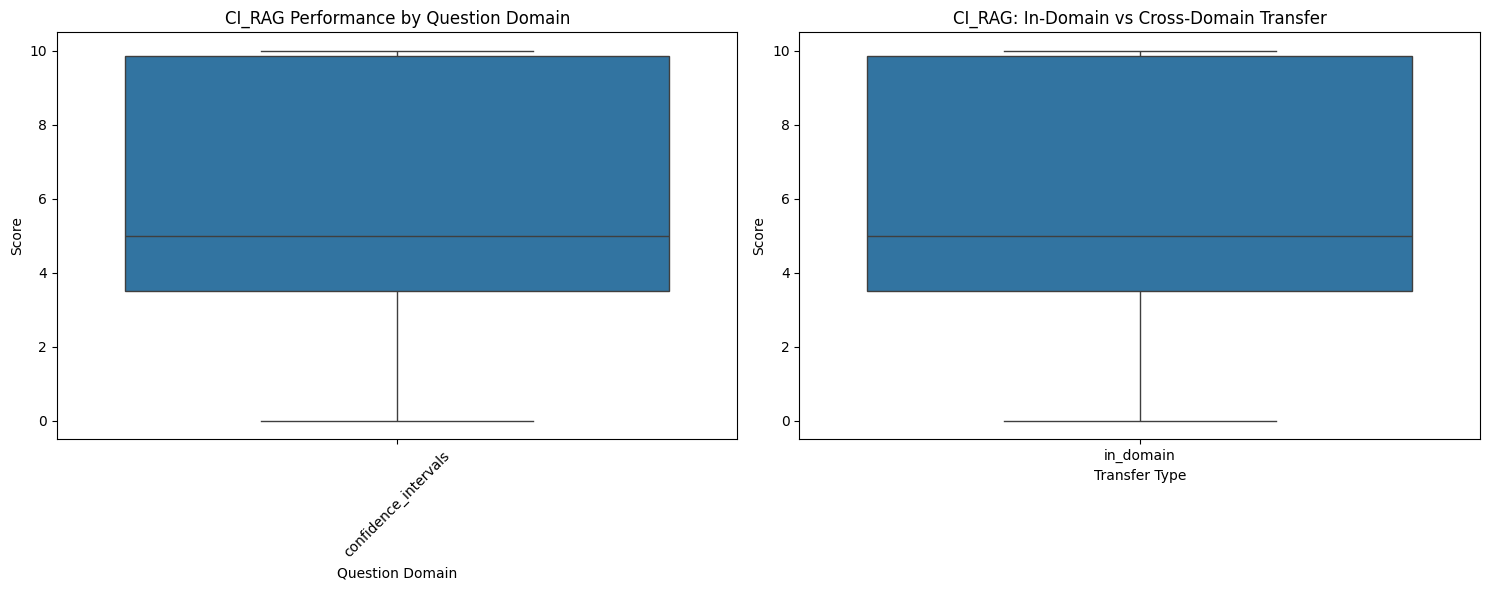


TRANSFER LEARNING SUMMARY:
• Model tested: ci_rag
• Training domain: confidence_intervals
• Transfer domains: hypothesis_testing, base_statistics
• Analysis tests if specialized training transfers to other domains
• Significant positive coefficient = in-domain advantage
• Non-significant difference = good transfer ability


In [114]:
# First, check if statsmodels is available and import it
try:
    import statsmodels.api as sm
    import statsmodels.formula.api as smf
    HAS_SM = True
    print("statsmodels available")
except ImportError:
    HAS_SM = False
    print("statsmodels not available - install with: pip install statsmodels")

# FOCUS ON CI_RAG TRANSFER LEARNING ONLY
needed = {'question_id','model','domain','score_final'}
if not needed.issubset(set(df.columns)):
    print("Missing required columns for mixed-effects; have:", list(df.columns))
else:
    # Filter to only ci_rag model for transfer learning analysis
    d = df[df['model'] == 'ci_rag'][['question_id','model','domain','score_final']].dropna().copy()
    
    # Convert to strings first to avoid categorical issues
    d['model'] = d['model'].astype(str)
    d['domain'] = d['domain'].astype(str)
    d['question_id'] = d['question_id'].astype(str)
    
    # Create transfer type indicator
    # ci_rag trained on confidence_intervals, so:
    # - confidence_intervals questions = in-domain
    # - hypothesis_testing questions = cross-domain transfer
    # - base_statistics questions = cross-domain transfer
    d['transfer_type'] = d['domain'].map({
        'confidence_intervals': 'in_domain',
        'hypothesis_testing': 'cross_domain_transfer',
        'base_statistics': 'cross_domain_transfer'
    })
    
    # Ensure score_final is numeric
    d['score_final'] = pd.to_numeric(d['score_final'], errors='coerce')
    d = d.dropna()  # Remove any rows that couldn't be converted
    
    print(f"\nCI_RAG TRANSFER LEARNING ANALYSIS")
    print("="*60)
    print(f"Data shape: {d.shape}")
    print(f"Model: {d['model'].unique()}")
    print(f"Question domains: {d['domain'].unique()}")
    print(f"Transfer types: {d['transfer_type'].unique()}")
    print(f"Questions: {d['question_id'].nunique()}")
    print(f"Score range: {d['score_final'].min():.2f} to {d['score_final'].max():.2f}")
    
    # Performance by domain
    domain_performance = d.groupby('domain')['score_final'].agg(['mean', 'std', 'count'])
    print(f"\nPerformance by domain:")
    print(domain_performance.round(3))
    
    # Performance by transfer type
    transfer_performance = d.groupby('transfer_type')['score_final'].agg(['mean', 'std', 'count'])
    print(f"\nPerformance by transfer type:")
    print(transfer_performance.round(3))
    
    if HAS_SM:
        try:
            # Mixed-effects model: score ~ transfer_type with question as random effect
            print("\nAttempting mixed-effects model for transfer learning...")
            md = smf.mixedlm("score_final ~ transfer_type", d, groups=d['question_id'])
            m = md.fit(method='lbfgs')
            print("\n" + "="*60)
            print("MIXED-EFFECTS MODEL RESULTS: CI_RAG TRANSFER LEARNING")
            print("="*60)
            print(m.summary())
            
            # Extract key results
            print("\n" + "="*60)
            print("KEY FINDINGS:")
            print("="*60)
            
            intercept = m.params['Intercept']
            transfer_coef = m.params.get('transfer_type[T.in_domain]', None)
            
            print(f"Baseline (cross-domain) performance: {intercept:.3f}")
            if transfer_coef is not None:
                transfer_pval = m.pvalues['transfer_type[T.in_domain]']
                sig = "***" if transfer_pval < 0.001 else "**" if transfer_pval < 0.01 else "*" if transfer_pval < 0.05 else ""
                print(f"In-domain boost: {transfer_coef:.3f} (p={transfer_pval:.3f}){sig}")
                print(f"In-domain performance: {intercept + transfer_coef:.3f}")
                
                if transfer_pval < 0.05:
                    if transfer_coef > 0:
                        print("✓ Significant IN-DOMAIN ADVANTAGE: ci_rag performs better on confidence interval questions")
                    else:
                        print("⚠ Significant IN-DOMAIN DISADVANTAGE: ci_rag performs worse on confidence interval questions")
                else:
                    print("○ NO SIGNIFICANT DIFFERENCE: ci_rag transfers well to other domains")
            
            # Alternative model: score ~ domain with question as random effect
            print("\n" + "-"*60)
            print("DETAILED DOMAIN ANALYSIS")
            print("-"*60)
            
            md2 = smf.mixedlm("score_final ~ domain", d, groups=d['question_id'])
            m2 = md2.fit(method='lbfgs')
            print(m2.summary())
            
        except Exception as e:
            print(f"MixedLM failed: {e}")
            print("Trying t-test for transfer learning...")
            
            # Fallback: Simple t-test comparison
            try:
                in_domain_scores = d[d['transfer_type'] == 'in_domain']['score_final']
                cross_domain_scores = d[d['transfer_type'] == 'cross_domain_transfer']['score_final']
                
                if len(in_domain_scores) > 0 and len(cross_domain_scores) > 0:
                    from scipy.stats import ttest_ind
                    
                    t_stat, p_val = ttest_ind(in_domain_scores, cross_domain_scores)
                    
                    print("\n" + "="*60)
                    print("T-TEST RESULTS: IN-DOMAIN vs CROSS-DOMAIN")
                    print("="*60)
                    print(f"In-domain mean: {in_domain_scores.mean():.3f} (n={len(in_domain_scores)})")
                    print(f"Cross-domain mean: {cross_domain_scores.mean():.3f} (n={len(cross_domain_scores)})")
                    print(f"Difference: {in_domain_scores.mean() - cross_domain_scores.mean():.3f}")
                    print(f"t-statistic: {t_stat:.3f}")
                    print(f"p-value: {p_val:.3f}")
                    
                    sig = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else ""
                    print(f"Significance: {sig}")
                    
                    if p_val < 0.05:
                        if in_domain_scores.mean() > cross_domain_scores.mean():
                            print("✓ SIGNIFICANT TRANSFER LIMITATION: ci_rag performs better in-domain")
                        else:
                            print("⚠ UNEXPECTED: ci_rag performs better cross-domain")
                    else:
                        print("○ GOOD TRANSFER: No significant difference between domains")
                        
            except Exception as e2:
                print(f"T-test also failed: {e2}")
                
    else:
        print("statsmodels not available — install with: pip install statsmodels")

    # Visualization of transfer performance
    print("\nCreating transfer learning visualization...")
    
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Box plot by domain
    sns.boxplot(data=d, x='domain', y='score_final', ax=ax1)
    ax1.set_title('CI_RAG Performance by Question Domain')
    ax1.set_xlabel('Question Domain')
    ax1.set_ylabel('Score')
    ax1.tick_params(axis='x', rotation=45)
    
    # Box plot by transfer type
    sns.boxplot(data=d, x='transfer_type', y='score_final', ax=ax2)
    ax2.set_title('CI_RAG: In-Domain vs Cross-Domain Transfer')
    ax2.set_xlabel('Transfer Type')
    ax2.set_ylabel('Score')
    
    plt.tight_layout()
    plt.show()
    
    # Summary statistics
    print("\n" + "="*60)
    print("TRANSFER LEARNING SUMMARY:")
    print("="*60)
    print("• Model tested: ci_rag")
    print("• Training domain: confidence_intervals")
    print("• Transfer domains: hypothesis_testing, base_statistics")
    print("• Analysis tests if specialized training transfers to other domains")
    print("• Significant positive coefficient = in-domain advantage")
    print("• Non-significant difference = good transfer ability")
    print("="*60)

## Interaction plot (Human means ±95% CI)

In [ ]:

sub = df[df['judge']=='human']
grp = sub.groupby(['model','domain'])['score_final'].agg(['mean','count','std']).reset_index()
if len(grp)==0:
    print("No data to plot.")
else:
    grp['se'] = grp['std'] / np.sqrt(grp['count'].clip(lower=1))
    models = sorted(grp['model'].unique().tolist())
    domains = sorted(grp['domain'].unique().tolist())
    plt.figure()
    for m in models:
        g = grp[grp['model']==m].set_index('domain')
        y = [g.loc[d,'mean'] if d in g.index else np.nan for d in domains]
        yerr = [1.96*g.loc[d,'se'] if d in g.index else 0.0 for d in domains]
        plt.errorbar(range(len(domains)), y, yerr=yerr, label=m)
    plt.xticks(range(len(domains)), domains)
    plt.title("Interaction: Model × Domain (Human means ±95%CI)")
    plt.xlabel("Domain"); plt.ylabel("Mean score")
    plt.legend(); plt.tight_layout(); plt.show()


## Waterfall plot of per-item differences

In [ ]:

if len(a_vec)>0:
    diff = np.sort(a_vec - b_vec)
    plt.figure()
    plt.plot(np.arange(len(diff)), diff)
    plt.axhline(0, linestyle='--')
    plt.title(f"Per-item differences (sorted): {MODEL_A} - {MODEL_B}")
    plt.xlabel("Item rank"); plt.ylabel("Difference")
    plt.tight_layout(); plt.show()
else:
    print("Not enough data for waterfall plot.")


#### Testing Domain Transfer capabilities for confidence intervals model

In [ ]:
models_to_keep = ['base', 'ci_rag', 'ht_rag']
judges_to_keep = ['human', 'qwen7b']

df_filtered = df[
    (df['model'].isin(models_to_keep)) & 
    (df['judge'].isin(judges_to_keep))
].copy()

print(f"Original data shape: {df.shape}")
print(f"Filtered data shape: {df_filtered.shape}")
print(f"Models kept: {df_filtered['model'].unique()}")
print(f"Judges kept: {df_filtered['judge'].unique()}")

ci_like_categories = [
    'Interpretation of confidence interval',
]

print(f"\nAvailable categories: {df_filtered['category'].unique()}")

def categorise_domain(row):
    category = str(row.get('category', '')).lower()
    domain = str(row.get('domain', '')).lower()
    
    # Check if it's CI-like based on category or domain
    if any(ci_cat.lower() in category for ci_cat in ci_like_categories):
        return 'CI_like'
    elif 'confidence' in category or 'confidence' in domain:
        return 'CI_like'
    else:
        return 'HT_like'

df_filtered['domain_flag'] = df_filtered.apply(categorise_domain, axis=1)

print(f"\nDomain flag distribution:")
print(df_filtered['domain_flag'].value_counts())

Original data shape: (270, 15)
Filtered data shape: (270, 15)
Models kept: ['base' 'ci_rag' 'ht_rag']
Judges kept: ['human' 'qwen7b']

Available categories: ['Hypothesis Formulation' 'Interpretation (CI to Hypothesis)'
 'Checking Conditions' 'Conceptual Application' 'Conceptual Errors'
 'Full Test Procedure' 'Interpretation of confidence interval'
 'Interpretation of p-value' 'Practical vs. Statistical Significance'
 'Full Test Procedure (Reasoning)' 'Full Test Procedure (Two-sample)'
 'Experiment Design' 'Interpretation (CI to Hypothesis']

Domain flag distribution:
domain_flag
HT_like    168
CI_like    102
Name: count, dtype: int64


In [119]:
def compute_descriptives(df_sub):
    results = []
    
    for judge in df_sub['judge'].unique():
        for domain_flag in df_sub['domain_flag'].unique():
            for model in df_sub['model'].unique():
                subset = df_sub[
                    (df_sub['judge'] == judge) & 
                    (df_sub['domain_flag'] == domain_flag) & 
                    (df_sub['model'] == model)
                ]
                
                if len(subset) == 0:
                    continue
                
                scores = subset['score_final'].dropna()
                n = len(scores)
                
                if n > 0:
                    mean_score = scores.mean()
                    std_score = scores.std(ddof=1) if n > 1 else 0
                    se_score = std_score / np.sqrt(n) if n > 0 else 0
                    ci_lower = mean_score - 1.96 * se_score
                    ci_upper = mean_score + 1.96 * se_score
                    
                    results.append({
                        'judge': judge,
                        'domain_flag': domain_flag,
                        'model': model,
                        'count': n,
                        'mean': mean_score,
                        'std': std_score,
                        'ci_lower': ci_lower,
                        'ci_upper': ci_upper
                    })
    
    return pd.DataFrame(results)

descriptives = compute_descriptives(df_filtered)

for judge in descriptives['judge'].unique():
    print(f"\n{judge.upper()} JUDGE:")
    judge_data = descriptives[descriptives['judge'] == judge]
    
    for domain in judge_data['domain_flag'].unique():
        print(f"\n  {domain}:")
        domain_data = judge_data[judge_data['domain_flag'] == domain]
        
        print("    Model      Count    Mean     Std      95% CI")
        print("    " + "-" * 50)
        for _, row in domain_data.iterrows():
            print(f"    {row['model']:<10} {row['count']:<8} {row['mean']:<8.3f} {row['std']:<8.3f} [{row['ci_lower']:.3f}, {row['ci_upper']:.3f}]")


HUMAN JUDGE:

  HT_like:
    Model      Count    Mean     Std      95% CI
    --------------------------------------------------
    base       42       7.752    3.020    [6.839, 8.666]
    ht_rag     42       7.510    3.825    [6.353, 8.666]

  CI_like:
    Model      Count    Mean     Std      95% CI
    --------------------------------------------------
    base       3        6.900    0.608    [6.212, 7.588]
    ci_rag     45       7.384    3.483    [6.367, 8.402]
    ht_rag     3        7.600    2.623    [4.632, 10.568]

QWEN7B JUDGE:

  HT_like:
    Model      Count    Mean     Std      95% CI
    --------------------------------------------------
    base       42       3.737    1.488    [3.287, 4.187]
    ht_rag     42       4.752    2.876    [3.883, 5.622]

  CI_like:
    Model      Count    Mean     Std      95% CI
    --------------------------------------------------
    base       3        3.333    0.577    [2.680, 3.987]
    ci_rag     45       4.029    2.168    [3.396, 

#### Win Rate Matrix 

In [ ]:
def compute_win_rate_matrix(df_sub, epsilon=0.5):
    models = sorted(df_sub['model'].unique())
    win_matrix = pd.DataFrame(np.nan, index=models, columns=models)
    count_matrix = pd.DataFrame(0, index=models, columns=models)
    
    for model_a in models:
        for model_b in models:
            if model_a == model_b:
                win_matrix.loc[model_a, model_b] = 0.5
                continue
                
            scores_a = df_sub[df_sub['model'] == model_a].set_index('question_id')['score_final']
            scores_b = df_sub[df_sub['model'] == model_b].set_index('question_id')['score_final']
            
            common_idx = scores_a.index.intersection(scores_b.index)
            
            if len(common_idx) == 0:
                continue
                
            diff = scores_a.loc[common_idx] - scores_b.loc[common_idx]
            win_rate = (diff > epsilon).mean()
            
            win_matrix.loc[model_a, model_b] = win_rate
            count_matrix.loc[model_a, model_b] = len(common_idx)
    
    return win_matrix, count_matrix


OVERALL PERFORMANCE ANALYSIS BY MODEL

HUMAN JUDGE PERFORMANCE:
------------------------------------------------------------
 Model  N  Mean   Std       95% CI
  base 45 7.696 2.926 [6.79, 8.49]
ci_rag 45 7.384 3.483 [6.29, 8.34]
ht_rag 45 7.516 3.734 [6.36, 8.56]

QWEN7B JUDGE PERFORMANCE:
------------------------------------------------------------
 Model  N  Mean   Std       95% CI
  base 45 3.710 1.445 [3.30, 4.13]
ci_rag 45 4.029 2.168 [3.36, 4.67]
ht_rag 45 4.924 2.894 [4.10, 5.76]


COMBINED PERFORMANCE SUMMARY TABLE:
 Model  Judge  N  Mean    SD       95% CI
  base  human 45 7.696 2.926 [6.79, 8.49]
  base qwen7b 45 3.710 1.445 [3.30, 4.13]
ci_rag  human 45 7.384 3.483 [6.29, 8.34]
ci_rag qwen7b 45 4.029 2.168 [3.36, 4.67]
ht_rag  human 45 7.516 3.734 [6.36, 8.56]
ht_rag qwen7b 45 4.924 2.894 [4.10, 5.76]

Creating comprehensive visualizations...


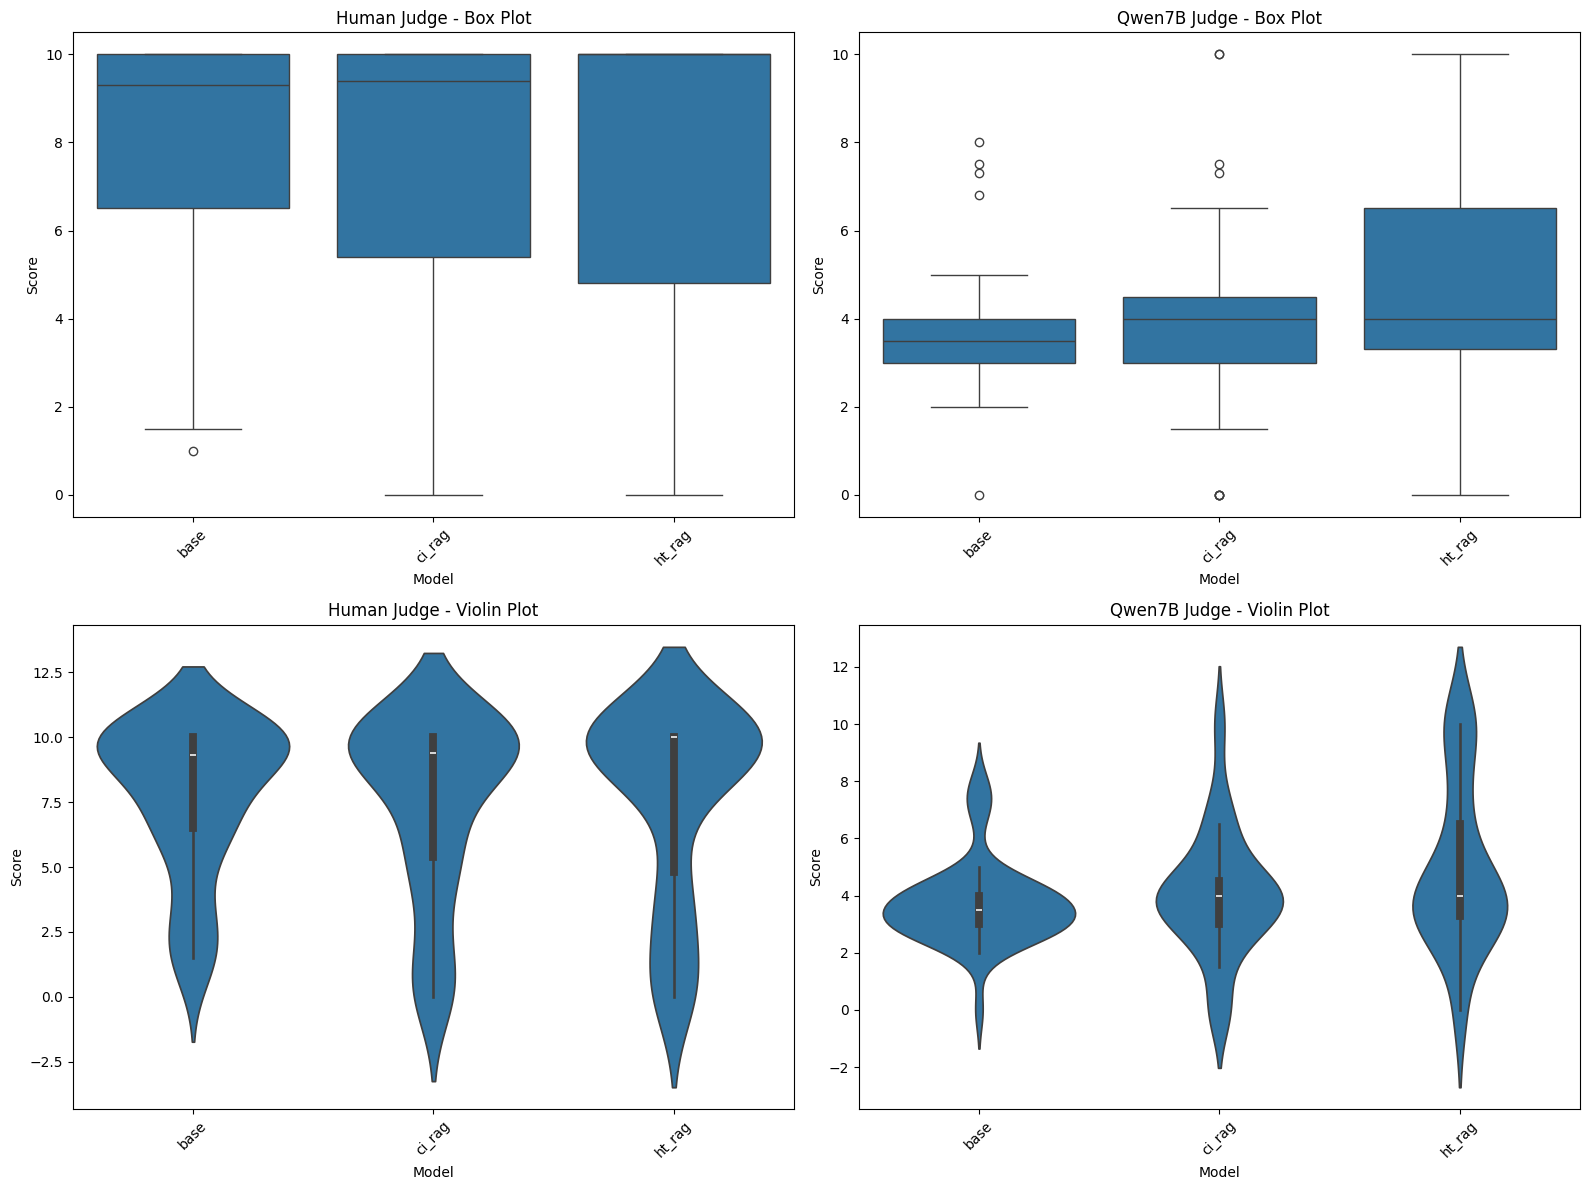

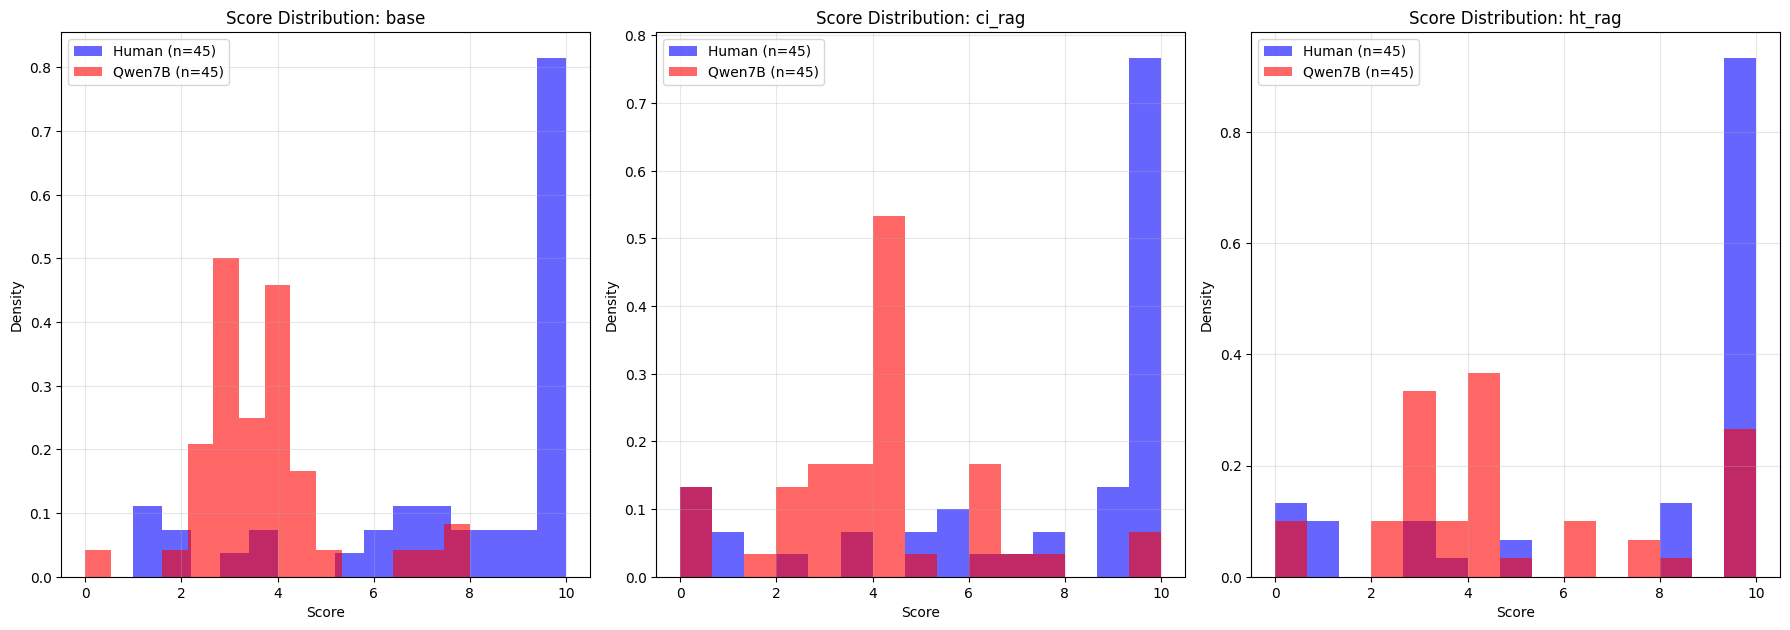

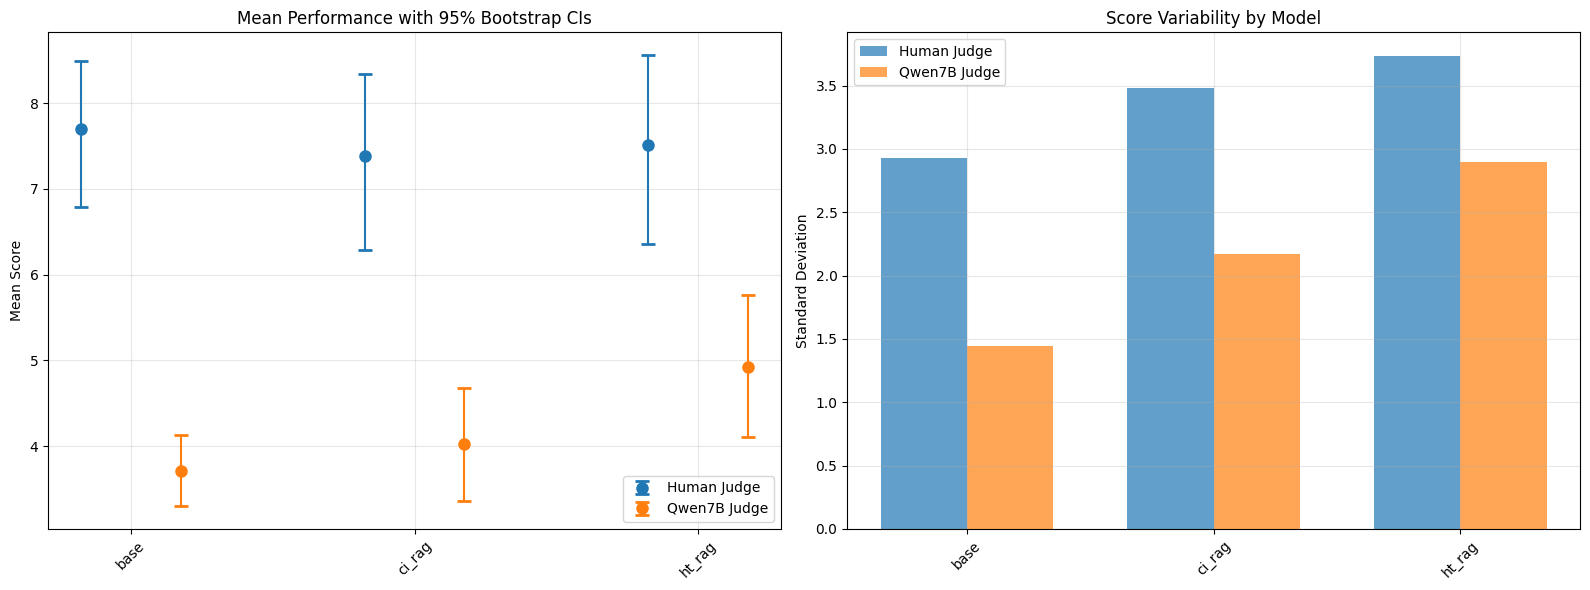

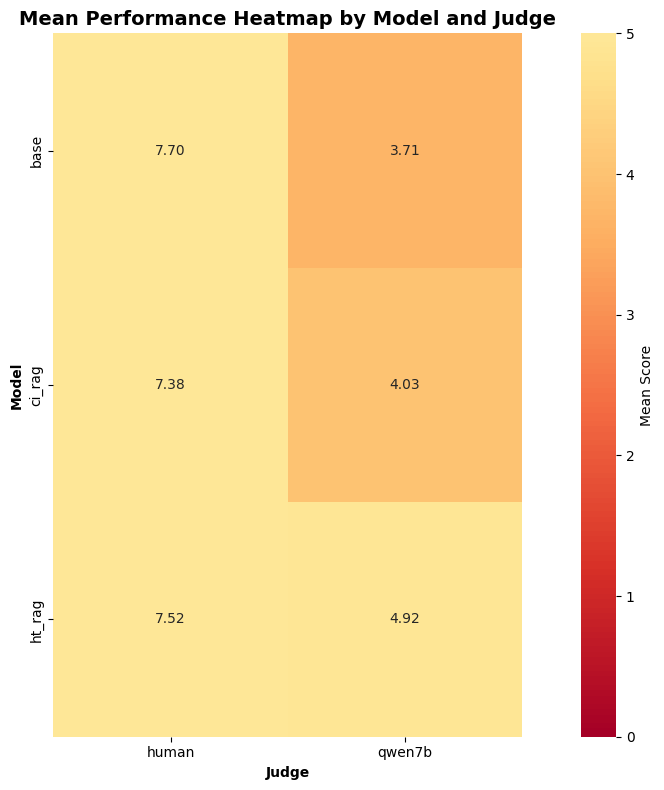


PERFORMANCE SUMMARY:
• Bootstrap 95% CIs provide robust uncertainty estimates
• Box plots show distribution shape and outliers
• Violin plots reveal distribution density patterns
• Histograms show detailed score distributions
• Error bar plots compare mean performance with uncertainty
• Higher mean scores indicate better performance
• Narrower CIs indicate more consistent performance


In [120]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings

def bootstrap_ci(data, n_bootstrap=1000, alpha=0.05):
    """Calculate bootstrap confidence intervals"""
    if len(data) <= 1:
        return np.nan, np.nan
    
    rng = np.random.default_rng(42)
    bootstrap_means = []
    
    for _ in range(n_bootstrap):
        sample = rng.choice(data, size=len(data), replace=True)
        bootstrap_means.append(np.mean(sample))
    
    ci_lower = np.percentile(bootstrap_means, 100 * alpha / 2)
    ci_upper = np.percentile(bootstrap_means, 100 * (1 - alpha / 2))
    
    return ci_lower, ci_upper

def compute_overall_performance(df, judge_name):
    """Compute comprehensive performance statistics by model"""
    sub = df[df['judge'] == judge_name]
    models = sorted(sub['model'].dropna().unique())
    
    results = []
    
    for model in models:
        model_data = sub[sub['model'] == model]
        scores = model_data['score_final'].dropna().values
        
        if len(scores) == 0:
            continue
            
        # Basic statistics
        n = len(scores)
        mean_score = np.mean(scores)
        std_score = np.std(scores, ddof=1) if n > 1 else 0
        median_score = np.median(scores)
        min_score = np.min(scores)
        max_score = np.max(scores)
        
        # Standard error and traditional 95% CI
        se_score = std_score / np.sqrt(n) if n > 0 else 0
        ci_traditional_lower = mean_score - 1.96 * se_score
        ci_traditional_upper = mean_score + 1.96 * se_score
        
        # Bootstrap 95% CI
        ci_bootstrap_lower, ci_bootstrap_upper = bootstrap_ci(scores)
        
        # Additional statistics
        q25 = np.percentile(scores, 25)
        q75 = np.percentile(scores, 75)
        iqr = q75 - q25
        
        results.append({
            'Model': model,
            'N': n,
            'Mean': mean_score,
            'Std': std_score,
            'SE': se_score,
            'Median': median_score,
            'Q25': q25,
            'Q75': q75,
            'IQR': iqr,
            'Min': min_score,
            'Max': max_score,
            'CI_Traditional_Lower': ci_traditional_lower,
            'CI_Traditional_Upper': ci_traditional_upper,
            'CI_Bootstrap_Lower': ci_bootstrap_lower,
            'CI_Bootstrap_Upper': ci_bootstrap_upper,
            'Judge': judge_name
        })
    
    return pd.DataFrame(results)

# Compute performance for both judges
print("="*80)
print("OVERALL PERFORMANCE ANALYSIS BY MODEL")
print("="*80)

all_performance = []

for judge_name in ['human', 'qwen7b']:
    perf_df = compute_overall_performance(df_filtered, judge_name)
    all_performance.append(perf_df)
    
    print(f"\n{judge_name.upper()} JUDGE PERFORMANCE:")
    print("-" * 60)
    
    # Create concise summary table
    summary_cols = ['Model', 'N', 'Mean', 'Std', 'CI_Bootstrap_Lower', 'CI_Bootstrap_Upper']
    summary_table = perf_df[summary_cols].copy()
    summary_table['95% CI'] = summary_table.apply(
        lambda row: f"[{row['CI_Bootstrap_Lower']:.2f}, {row['CI_Bootstrap_Upper']:.2f}]", 
        axis=1
    )
    
    display_table = summary_table[['Model', 'N', 'Mean', 'Std', '95% CI']].round(3)
    print(display_table.to_string(index=False))

# Combine results
combined_performance = pd.concat(all_performance, ignore_index=True)

# Create comprehensive summary table
print(f"\n\nCOMBINED PERFORMANCE SUMMARY TABLE:")
print("="*80)

# Pivot to show both judges side by side
pivot_mean = combined_performance.pivot(index='Model', columns='Judge', values='Mean')
pivot_std = combined_performance.pivot(index='Model', columns='Judge', values='Std')
pivot_n = combined_performance.pivot(index='Model', columns='Judge', values='N')
pivot_ci_lower = combined_performance.pivot(index='Model', columns='Judge', values='CI_Bootstrap_Lower')
pivot_ci_upper = combined_performance.pivot(index='Model', columns='Judge', values='CI_Bootstrap_Upper')

# Create final summary table
final_summary = []
for model in pivot_mean.index:
    for judge in pivot_mean.columns:
        if not pd.isna(pivot_mean.loc[model, judge]):
            final_summary.append({
                'Model': model,
                'Judge': judge,
                'N': int(pivot_n.loc[model, judge]),
                'Mean': pivot_mean.loc[model, judge],
                'SD': pivot_std.loc[model, judge],
                '95% CI': f"[{pivot_ci_lower.loc[model, judge]:.2f}, {pivot_ci_upper.loc[model, judge]:.2f}]"
            })

final_df = pd.DataFrame(final_summary)
print(final_df.round(3).to_string(index=False))

# VISUALIZATIONS
print(f"\nCreating comprehensive visualizations...")

# 1. Box plots by model and judge
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Box plot for each judge
for idx, judge_name in enumerate(['human', 'qwen7b']):
    sub = df_filtered[df_filtered['judge'] == judge_name]
    
    # Box plot
    sns.boxplot(data=sub, x='model', y='score_final', ax=axes[0, idx])
    axes[0, idx].set_title(f'{judge_name.title()} Judge - Box Plot')
    axes[0, idx].set_xlabel('Model')
    axes[0, idx].set_ylabel('Score')
    axes[0, idx].tick_params(axis='x', rotation=45)
    
    # Violin plot
    sns.violinplot(data=sub, x='model', y='score_final', ax=axes[1, idx])
    axes[1, idx].set_title(f'{judge_name.title()} Judge - Violin Plot')
    axes[1, idx].set_xlabel('Model')
    axes[1, idx].set_ylabel('Score')
    axes[1, idx].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# 2. Histograms with overlaid distributions
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
models = sorted(df_filtered['model'].unique())

for idx, model in enumerate(models):
    row = idx // 3
    col = idx % 3
    
    if row < 2 and col < 3:
        ax = axes[row, col]
        
        for judge_name, color in [('human', 'blue'), ('qwen7b', 'red')]:
            model_scores = df_filtered[
                (df_filtered['model'] == model) & 
                (df_filtered['judge'] == judge_name)
            ]['score_final'].dropna()
            
            if len(model_scores) > 0:
                ax.hist(model_scores, bins=15, alpha=0.6, 
                       label=f'{judge_name.title()} (n={len(model_scores)})',
                       color=color, density=True)
        
        ax.set_title(f'Score Distribution: {model}')
        ax.set_xlabel('Score')
        ax.set_ylabel('Density')
        ax.legend()
        ax.grid(True, alpha=0.3)

# Remove empty subplots
for idx in range(len(models), 6):
    row = idx // 3
    col = idx % 3
    if row < 2:
        fig.delaxes(axes[row, col])

plt.tight_layout()
plt.show()

# 3. Mean performance comparison with error bars
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Bootstrap CI comparison
for idx, judge_name in enumerate(['human', 'qwen7b']):
    perf_data = combined_performance[combined_performance['Judge'] == judge_name]
    
    x_pos = np.arange(len(perf_data)) + idx * 0.35
    
    ax1.errorbar(x_pos, perf_data['Mean'], 
                yerr=[perf_data['Mean'] - perf_data['CI_Bootstrap_Lower'],
                      perf_data['CI_Bootstrap_Upper'] - perf_data['Mean']],
                fmt='o', capsize=5, capthick=2, markersize=8,
                label=f'{judge_name.title()} Judge')

ax1.set_xticks(np.arange(len(models)) + 0.175)
ax1.set_xticklabels(models, rotation=45)
ax1.set_ylabel('Mean Score')
ax1.set_title('Mean Performance with 95% Bootstrap CIs')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Standard deviation comparison
for idx, judge_name in enumerate(['human', 'qwen7b']):
    perf_data = combined_performance[combined_performance['Judge'] == judge_name]
    
    x_pos = np.arange(len(perf_data)) + idx * 0.35
    
    ax2.bar(x_pos, perf_data['Std'], width=0.35, alpha=0.7,
           label=f'{judge_name.title()} Judge')

ax2.set_xticks(np.arange(len(models)) + 0.175)
ax2.set_xticklabels(models, rotation=45)
ax2.set_ylabel('Standard Deviation')
ax2.set_title('Score Variability by Model')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 4. Summary statistics table visualization
fig, ax = plt.subplots(figsize=(12, 8))

# Create heatmap of mean scores
heatmap_data = combined_performance.pivot(index='Model', columns='Judge', values='Mean')

sns.heatmap(heatmap_data, annot=True, fmt='.2f', cmap='RdYlGn',
           center=heatmap_data.values.mean(), vmin=0, vmax=5,
           square=True, cbar_kws={'label': 'Mean Score'}, ax=ax)

ax.set_title('Mean Performance Heatmap by Model and Judge', 
             fontsize=14, fontweight='bold')
ax.set_xlabel('Judge', fontweight='bold')
ax.set_ylabel('Model', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n" + "="*80)
print("PERFORMANCE SUMMARY:")
print("="*80)
print("• Bootstrap 95% CIs provide robust uncertainty estimates")
print("• Box plots show distribution shape and outliers")
print("• Violin plots reveal distribution density patterns")
print("• Histograms show detailed score distributions")
print("• Error bar plots compare mean performance with uncertainty")
print("• Higher mean scores indicate better performance")
print("• Narrower CIs indicate more consistent performance")
print("="*80)